In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
from control.matlab import ss, c2d, dlqr,ss2tf, tf, step
import control 

from scipy.signal import ss2zpk, cont2discrete

from mushroom_rl.algorithms.policy_search import REINFORCE, GPOMDP, eNAC, RWR, PGPE, REPS, ConstrainedREPS, MORE
from mushroom_rl.approximators.parametric import LinearApproximator
from mushroom_rl.approximators.regressor import Regressor
from mushroom_rl.core import Core, Logger
from mushroom_rl.policy import StateStdGaussianPolicy
from mushroom_rl.policy import DeterministicPolicy
from mushroom_rl.utils.dataset import compute_J
from mushroom_rl.utils.optimizers import AdaptiveOptimizer
from mushroom_rl.core import Environment, MDPInfo
from mushroom_rl.utils import spaces
from mushroom_rl.distributions import GaussianCholeskyDistribution

from mushroom_rl.core import Serializable

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import matlab.engine
import matlab
import os
from numpy import array
import random
import math 
from pathlib import Path

In [84]:
class LQR2(Environment):
    """
    This class implements a Linear-Quadratic Regulator.
    This task aims to minimize the undesired deviations from nominal values of
    some controller settings in control problems.
    The system equations in this task are:

    .. math::
        x_{t+1} = Ax_t + Bu_t

    where x is the state and u is the control signal.

    The reward function is given by:

    .. math::
        r_t = -\\left( x_t^TQx_t + u_t^TRu_t \\right)

    "Policy gradient approaches for multi-objective sequential decision making".
    Parisi S., Pirotta M., Smacchia N., Bascetta L., Restelli M.. 2014

    """
    def __init__(self, max_pos=np.inf, max_action=10,  random_init=True, episodic=False, gamma=0.9,
                 horizon=50, initial_state=None, dt=1):
        """
        Constructor.

            Args:
                A (np.ndarray): the state dynamics matrix;
                B (np.ndarray): the action dynamics matrix;
                Q (np.ndarray): reward weight matrix for state;
                R (np.ndarray): reward weight matrix for action;
                max_pos (float, np.inf): maximum value of the state;
                max_action (float, np.inf): maximum value of the action;
                random_init (bool, False): start from a random state;
                episodic (bool, False): end the episode when the state goes over
                the threshold;
                gamma (float, 0.9): discount factor;
                horizon (int, 50): horizon of the mdp;
                dt (float, 0.1): the control timestep of the environment.

        """
        g = 0.0025
        force = 1.1115
        #p = gravity / (polelength * (4/3 - masspole / (masscart + masspole)))
        k = 3
        p_state =-5.0
        delta_t = 1
        gk2 = g*k*delta_t

        A = np.array([[1+gk2, 1],
                  [gk2, 1]])

        B = np.array([[delta_t],
                      [delta_t]])

        C = np.array([[1, 0],
                  [0, 1]])

        D = np.array([[0],
                      [0]])

        Q = np.dot(C.T, C)

        R = 1
        
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.gravity = 0.0025
        self.k = 3
        # self._max_pos = max_pos
        self._max_pos = max_pos
        self._max_action = max_action
        self._episodic = episodic
        self.random_init = random_init
        self.collect_reward = []
        self.goal_pos = 0.0001
        self.delta_t = delta_t
        self.beta = np.array([0.1,0])

        #self._initial_state = np.array([-8,0.0])
        self._initial_state = None

        # MDP properties
        #high_x = self._max_pos * np.ones(A.shape[0])
        high_x = np.array([self._max_pos, np.inf])
        low_x = -high_x

        high_u = self._max_action * np.ones(B.shape[1])
        low_u = -high_u

        observation_space = spaces.Box(low=low_x, high=high_x)
        action_space = spaces.Box(low=low_u, high=high_u)
        mdp_info = MDPInfo(observation_space, action_space, gamma, horizon)

        self._state = None

        super().__init__(mdp_info)

    @staticmethod
    def generate(dimensions=None, s_dim=None, a_dim=None, max_pos=np.inf, max_action=np.inf, eps=.1,
                 index=0, scale=1.0, random_init=False, episodic=False,
                 gamma=.9, horizon=50, initial_state=None):
        """
        Factory method that generates an lqr with identity dynamics and
        symmetric reward matrices.

        Args:
            dimensions (int): number of state-action dimensions;
            s_dim (int): number of state dimensions;
            a_dim (int): number of action dimensions;
            max_pos (float, np.inf): maximum value of the state;
            max_action (float, np.inf): maximum value of the action;
            eps (double, .1): reward matrix weights specifier;
            index (int, 0): selector for the principal state;
            scale (float, 1.0): scaling factor for the reward function;
            random_init (bool, False): start from a random state;
            episodic (bool, False): end the episode when the state goes over the
                threshold;
            gamma (float, .9): discount factor;
            horizon (int, 50): horizon of the mdp.

        """
        assert dimensions != None or (s_dim != None and a_dim != None)

        if s_dim == None or a_dim == None:
            s_dim = dimensions
            a_dim = dimensions
        A = np.eye(s_dim)
        B = np.eye(s_dim, a_dim)
        Q = eps * np.eye(s_dim) * scale
        R = (1. - eps) * np.eye(a_dim) * scale

        Q[index, index] = (1. - eps) * scale
        R[index, index] = eps * scale

        return LQR(A, B, Q, R, max_pos, max_action, random_init, episodic,
                   gamma, horizon, initial_state)
        

    def reset(self, state=None):
        if state is None:
            if self.random_init:
                self._state = self._bound(
                    np.random.uniform(-3, 3, size=self.A.shape[0]),
                    self.info.observation_space.low,
                    self.info.observation_space.high
                )
            elif self._initial_state is not None:
                self._state = self._initial_state
            else:
                init_value = .9 * self._max_pos if np.isfinite(
                    self._max_pos) else 10
                self._state = init_value * np.ones(self.A.shape[0])
        else:
            self._state = state

        #print("intial state: ", self._state)
        return self._state

    def step(self, action):
        x = self._state
        u = self._bound(action, self.info.action_space.low,
                        self.info.action_space.high)
        
        #if (np.abs(u) > 1.0):  #1.1115
            #u = 1.0 * (u/np.abs(u))
        #print(u)

        #reward = -(x.dot(self.Q).dot(x) + u.dot(self.R).dot(u))
        if(x[0] < 0.0):
            x_new = -1*(x)
        else:
            x_new = x
        
        x_minus_beta = x_new - self.beta
        alpha = 0.5*(1 + (x_minus_beta / np.abs(x_minus_beta))[0]) #if tail based
        #alpha = 1 #if LQR
        #print(alpha)
        
        reward = -(x.dot(self.Q).dot(x)*alpha + u.dot(self.R).dot(u))
        
        #self._state = self.A.dot(x) + self.B.dot(u)
        self._state[1] = self._state[1] + u*self.delta_t + (self.gravity*self.delta_t* math.sin(self.k*self._state[0]))
        self._state[0] = self._state[0] + self._state[1] 
        # print(self._state)

        absorbing = False

        if np.any(np.abs(self._state[0]) > self._max_pos):
            if self._episodic:
                reward = -self._max_pos ** 2 * 10
                print("Max pos exceeded")
                absorbing = True
            else:
                self._state = self._bound(self._state, self.info.observation_space.low,
                                          self.info.observation_space.high)

        if np.any(np.abs(self._state[0]) < self.goal_pos):
            print("Goal reached")
            if self._episodic:
                reward = 0
                absorbing = True
            else:
                 self._state = self._bound(self._state, self.info.observation_space.low,
                                           self.info.observation_space.high)
            self.collect_reward.append(reward)

        return self._state, reward, absorbing, {}

    def print_graph(self):
        plt.plot(self.collect_reward) 

In [85]:
def experiment(alg, n_epochs, n_iterations, ep_per_run):
    np.random.seed()

    logger = Logger(alg.__name__, results_dir=None)
    logger.strong_line()
    logger.info('Experiment Algorithm: ' + alg.__name__)

    # MDP
    mdp = LQR2()

    approximator = Regressor(LinearApproximator,
                             input_shape=mdp.info.observation_space.shape,
                             output_shape=mdp.info.action_space.shape)

    sigma = Regressor(LinearApproximator,
                      input_shape=mdp.info.observation_space.shape,
                      output_shape=mdp.info.action_space.shape)

    sigma_weights = 0.25 * np.ones(sigma.weights_size)
    sigma.set_weights(sigma_weights)

    policy = StateStdGaussianPolicy(approximator, sigma)

    # Agent
    optimizer = AdaptiveOptimizer(eps=1e-2)
    algorithm_params = dict(optimizer=optimizer)
    agent = alg(mdp.info, policy, **algorithm_params)

    # Train
    alg_reward = []
    core = Core(agent, mdp)
    dataset_eval = core.evaluate(n_episodes=ep_per_run)
    J = compute_J(dataset_eval, gamma=mdp.info.gamma)
    logger.epoch_info(0, J=np.mean(J), policy_weights=policy.get_weights().tolist())

    for i in trange(n_epochs, leave=False):
        core.learn(n_episodes=n_iterations * ep_per_run,
                   n_episodes_per_fit=ep_per_run)
        dataset_eval = core.evaluate(n_episodes=ep_per_run)
        J = compute_J(dataset_eval, gamma=mdp.info.gamma)
        logger.epoch_info(i+1, J=np.mean(J), policy_weights=policy.get_weights().tolist())
        alg_reward.append(np.mean(J))
        
    plt.plot(alg_reward)
    
    return agent
    

  8%|▊         | 16/200 [00:00<00:01, 150.31it/s]

27/10/2023 16:38:21 [INFO] ###################################################################################################
27/10/2023 16:38:21 [INFO] Experiment Algorithm: eNAC



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  2%|▏         | 12/800 [00:00<00:07, 105.49it/s]

27/10/2023 16:38:23 [INFO] Epoch 0 | J: -274058.6532883762 policy_weights: [0.0, 0.0, 0.25, 0.25]




  3%|▎         | 26/800 [00:00<00:06, 121.06it/s]

  5%|▍         | 39/800 [00:00<00:06, 118.75it/s]

  6%|▋         | 52/800 [00:00<00:06, 118.93it/s]

  8%|▊         | 64/800 [00:00<00:06, 110.25it/s]

 10%|▉         | 77/800 [00:00<00:06, 116.07it/s]

 11%|█         | 89/800 [00:00<00:06, 114.85it/s]

 13%|█▎        | 103/800 [00:00<00:05, 117.01it/s]

 14%|█▍        | 115/800 [00:00<00:05, 115.41it/s]

 16%|█▌        | 127/800 [00:01<00:05, 112.26it/s]

 17%|█▋        | 139/800 [00:01<00:05, 111.35it/s]

 19%|█▉        | 151/800 [00:01<00:05, 111.17it/s]

 20%|██        | 163/800 [00:01<00:05, 111.61it/s]

 22%|██▏       | 175/800 [00:01<00:05, 111.63it/s]

 23%|██▎       | 187/800 [00:01<00:05, 107.88it/s]

 25%|██▍       | 199/800 [00:01<00:05, 110.04it/s]

 26%|██▋       | 211/800 [00:02<00:16, 35.74it/s] 

 28%|██▊       | 223/800 [00:02<00:12, 45.26it/s]

 30%|██▉       | 237/800 [00:02<00:09, 58.31it/s]

 31%|███▏      | 251/800 [00:02<00:07, 71.16it/s]

 33%|███▎      | 26

Goal reached




 41%|████      | 327/800 [00:03<00:04, 110.17it/s]

 43%|████▎     | 342/800 [00:03<00:03, 119.18it/s]

 44%|████▍     | 356/800 [00:03<00:03, 122.01it/s]

 46%|████▋     | 370/800 [00:03<00:03, 124.98it/s]

 48%|████▊     | 383/800 [00:04<00:03, 125.21it/s]

 50%|████▉     | 397/800 [00:04<00:03, 128.42it/s]

Goal reached




 51%|█████▏    | 411/800 [00:04<00:09, 40.44it/s] 

 53%|█████▎    | 423/800 [00:05<00:07, 49.19it/s]

 55%|█████▍    | 436/800 [00:05<00:06, 59.87it/s]

 56%|█████▌    | 448/800 [00:05<00:05, 69.11it/s]

 57%|█████▊    | 460/800 [00:05<00:04, 75.30it/s]

 59%|█████▉    | 471/800 [00:05<00:04, 76.10it/s]

 60%|██████    | 484/800 [00:05<00:03, 86.56it/s]

Goal reached




 62%|██████▏   | 496/800 [00:05<00:03, 91.51it/s]

 64%|██████▎   | 509/800 [00:05<00:02, 99.27it/s]

 65%|██████▌   | 521/800 [00:05<00:02, 104.53it/s]

 67%|██████▋   | 533/800 [00:06<00:02, 105.72it/s]

 68%|██████▊   | 545/800 [00:06<00:02, 107.63it/s]

 70%|██████▉   | 559/800 [00:06<00:02, 113.93it/s]

 71%|███████▏  | 571/800 [00:06<00:02, 111.18it/s]

 73%|███████▎  | 583/800 [00:06<00:02, 101.45it/s]

 74%|███████▍  | 594/800 [00:06<00:02, 90.23it/s] 

 76%|███████▌  | 604/800 [00:07<00:06, 31.80it/s]

 77%|███████▋  | 617/800 [00:07<00:04, 42.17it/s]

 79%|███████▉  | 630/800 [00:07<00:03, 53.48it/s]

Goal reached
Goal reached




 80%|████████  | 641/800 [00:07<00:02, 62.12it/s]

 82%|████████▏ | 653/800 [00:08<00:02, 72.68it/s]



Goal reached
Goal reached
Goal reached


 83%|████████▎ | 667/800 [00:08<00:01, 85.50it/s]

 85%|████████▍ | 679/800 [00:08<00:01, 92.05it/s]

 86%|████████▋ | 692/800 [00:08<00:01, 99.50it/s]

Goal reached




 88%|████████▊ | 704/800 [00:08<00:00, 101.55it/s]

 90%|████████▉ | 716/800 [00:08<00:00, 91.23it/s] 

 91%|█████████ | 727/800 [00:08<00:00, 77.08it/s]

Goal reached
Goal reached




 92%|█████████▏| 736/800 [00:08<00:00, 78.84it/s]

 94%|█████████▎| 749/800 [00:09<00:00, 89.74it/s]

 95%|█████████▌| 761/800 [00:09<00:00, 96.63it/s]

 97%|█████████▋| 774/800 [00:09<00:00, 104.07it/s]

 98%|█████████▊| 787/800 [00:09<00:00, 109.92it/s]

Goal reached
Goal reached
Goal reached




100%|█████████▉| 799/800 [00:09<00:00, 111.74it/s]

Goal reached




                                                  

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 117.56it/s]

 12%|█▏        | 24/200 [00:00<00:01, 114.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 36/200 [00:00<00:01, 98.31it/s] 

 25%|██▌       | 50/200 [00:00<00:01, 110.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:00<00:01, 113.53it/s]

 38%|███▊      | 76/200 [00:00<00:01, 119.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 89/200 [00:00<00:00, 119.55it/s]

 51%|█████     | 102/200 [00:00<00:00, 110.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 114/200 [00:01<00:00, 107.45it/s]

 64%|██████▎   | 127/200 [00:01<00:00, 113.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 141/200 [00:01<00:00, 119.35it/s]

 78%|███████▊  | 155/200 [00:01<00:00, 124.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 169/200 [00:01<00:00, 126.72it/s]

 91%|█████████ | 182/200 [00:01<00:00, 118.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 195/200 [00:01<00:00, 99.68it/s] 

                                                 

Goal reached
Goal reached
Goal reached


                                         
  3%|▎         | 1/30 [00:11<05:47, 11.99s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  2%|▏         | 12/800 [00:00<00:07, 110.90it/s]

27/10/2023 16:38:35 [INFO] Epoch 1 | J: -30.627064721567272 policy_weights: [-0.2709996027755922, -0.2701515930639511, 0.17063999025550053, 0.16839648554101935]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 26/800 [00:00<00:06, 127.46it/s]

  5%|▌         | 40/800 [00:00<00:05, 130.08it/s]

  7%|▋         | 54/800 [00:00<00:05, 127.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 67/800 [00:00<00:05, 123.78it/s]

 10%|█         | 82/800 [00:00<00:05, 130.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 96/800 [00:00<00:05, 129.99it/s]

 14%|█▍        | 110/800 [00:00<00:05, 122.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 123/800 [00:00<00:05, 123.51it/s]

 17%|█▋        | 136/800 [00:01<00:05, 123.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▊        | 149/800 [00:01<00:05, 124.87it/s]

 21%|██        | 165/800 [00:01<00:04, 131.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 179/800 [00:01<00:05, 122.95it/s]

 24%|██▍       | 192/800 [00:01<00:04, 122.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 205/800 [00:02<00:14, 42.29it/s] 

 27%|██▋       | 217/800 [00:02<00:11, 51.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 228/800 [00:02<00:09, 59.02it/s]

 30%|███       | 241/800 [00:02<00:07, 70.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 253/800 [00:02<00:06, 79.00it/s]

 33%|███▎      | 264/800 [00:02<00:06, 80.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 275/800 [00:03<00:06, 81.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 285/800 [00:03<00:06, 73.99it/s]

 37%|███▋      | 295/800 [00:03<00:06, 78.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 307/800 [00:03<00:05, 88.04it/s]

 40%|███▉      | 319/800 [00:03<00:05, 96.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 330/800 [00:03<00:04, 97.98it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 43%|████▎     | 344/800 [00:03<00:04, 107.73it/s]

 44%|████▍     | 356/800 [00:03<00:04, 107.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 368/800 [00:03<00:03, 110.05it/s]

 48%|████▊     | 381/800 [00:04<00:03, 113.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 394/800 [00:04<00:03, 116.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 406/800 [00:04<00:09, 41.16it/s] 

 52%|█████▏    | 417/800 [00:04<00:07, 49.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 427/800 [00:05<00:06, 56.47it/s]

 55%|█████▍    | 438/800 [00:05<00:05, 65.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 450/800 [00:05<00:04, 74.36it/s]

 58%|█████▊    | 461/800 [00:05<00:04, 81.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 473/800 [00:05<00:03, 90.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 484/800 [00:05<00:03, 93.88it/s]

 62%|██████▏   | 496/800 [00:05<00:03, 100.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 507/800 [00:05<00:03, 96.57it/s] 

 65%|██████▍   | 518/800 [00:05<00:02, 98.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 529/800 [00:06<00:02, 92.03it/s]

 67%|██████▋   | 539/800 [00:06<00:02, 91.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 550/800 [00:06<00:02, 95.12it/s]

 70%|███████   | 563/800 [00:06<00:02, 104.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 575/800 [00:06<00:02, 108.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 589/800 [00:06<00:01, 112.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:07<00:04, 40.04it/s] 

 76%|███████▋  | 612/800 [00:07<00:03, 48.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 623/800 [00:07<00:03, 57.42it/s]

 79%|███████▉  | 633/800 [00:07<00:02, 62.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 646/800 [00:07<00:02, 75.57it/s]

 82%|████████▏ | 658/800 [00:07<00:01, 84.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 672/800 [00:08<00:01, 96.99it/s]

 86%|████████▌ | 684/800 [00:08<00:01, 102.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 697/800 [00:08<00:00, 107.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▊ | 709/800 [00:08<00:00, 102.65it/s]

 90%|█████████ | 721/800 [00:08<00:00, 104.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 733/800 [00:08<00:00, 106.61it/s]

 93%|█████████▎| 745/800 [00:08<00:00, 104.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▍| 758/800 [00:08<00:00, 109.72it/s]

 96%|█████████▋| 770/800 [00:08<00:00, 110.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 98%|█████████▊| 782/800 [00:09<00:00, 112.06it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 794/800 [00:09<00:00, 105.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                  

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 127.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:01, 125.49it/s]

 20%|█▉        | 39/200 [00:00<00:01, 107.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 50/200 [00:00<00:01, 100.29it/s]

 30%|███       | 61/200 [00:00<00:01, 102.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 72/200 [00:00<00:01, 98.14it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 82/200 [00:00<00:01, 98.28it/s]

 47%|████▋     | 94/200 [00:00<00:01, 103.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 52%|█████▎    | 105/200 [00:01<00:00, 98.33it/s]

 57%|█████▊    | 115/200 [00:01<00:00, 95.89it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 126/200 [00:01<00:00, 99.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 137/200 [00:01<00:00, 98.54it/s]

 74%|███████▎  | 147/200 [00:01<00:00, 95.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 157/200 [00:01<00:00, 96.51it/s]

 84%|████████▎ | 167/200 [00:01<00:00, 93.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 178/200 [00:01<00:00, 96.34it/s]

 94%|█████████▍| 189/200 [00:01<00:00, 96.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 199/200 [00:02<00:00, 94.30it/s]

                                                 
  7%|▋         | 2/30 [00:24<05:37, 12.07s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:38:47 [INFO] Epoch 2 | J: -14.65828508787621 policy_weights: [-0.5409642662083644, -0.5454294995977066, 0.08987478791480816, 0.11051559691954317]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:08, 89.27it/s]

  2%|▏         | 19/800 [00:00<00:08, 94.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▎         | 29/800 [00:00<00:08, 86.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▍         | 38/800 [00:00<00:10, 73.31it/s]

  6%|▌         | 46/800 [00:00<00:10, 73.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 56/800 [00:00<00:09, 79.51it/s]

  8%|▊         | 65/800 [00:00<00:09, 79.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 74/800 [00:00<00:08, 81.60it/s]

 10%|█         | 83/800 [00:01<00:09, 77.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 92/800 [00:01<00:08, 80.93it/s]

 13%|█▎        | 101/800 [00:01<00:08, 81.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 110/800 [00:01<00:08, 82.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▍        | 119/800 [00:01<00:08, 82.37it/s]

 16%|█▌        | 128/800 [00:01<00:08, 83.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 137/800 [00:01<00:07, 83.70it/s]

 18%|█▊        | 146/800 [00:01<00:08, 79.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 155/800 [00:01<00:08, 79.64it/s]

 20%|██        | 163/800 [00:02<00:08, 78.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 173/800 [00:02<00:07, 81.94it/s]

 23%|██▎       | 182/800 [00:02<00:07, 82.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 191/800 [00:02<00:07, 83.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 200/800 [00:02<00:07, 82.49it/s]

Goal reached




 26%|██▌       | 209/800 [00:03<00:24, 23.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 218/800 [00:03<00:19, 30.27it/s]

 28%|██▊       | 225/800 [00:03<00:16, 34.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 233/800 [00:03<00:13, 40.79it/s]

 30%|███       | 241/800 [00:03<00:11, 46.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███▏      | 250/800 [00:04<00:10, 54.48it/s]

 32%|███▏      | 259/800 [00:04<00:08, 61.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▎      | 268/800 [00:04<00:07, 67.76it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 35%|███▍      | 277/800 [00:04<00:07, 72.03it/s]

 36%|███▌      | 286/800 [00:04<00:06, 76.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 295/800 [00:04<00:06, 74.37it/s]

 38%|███▊      | 305/800 [00:04<00:06, 78.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 315/800 [00:04<00:05, 83.25it/s]

 41%|████      | 326/800 [00:04<00:05, 89.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 336/800 [00:04<00:05, 88.07it/s]

 43%|████▎     | 346/800 [00:05<00:05, 89.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 356/800 [00:05<00:04, 88.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 365/800 [00:05<00:04, 88.26it/s]

 47%|████▋     | 374/800 [00:05<00:04, 86.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 383/800 [00:05<00:04, 86.41it/s]

 49%|████▉     | 393/800 [00:05<00:04, 89.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 402/800 [00:06<00:14, 26.75it/s]

 51%|█████▏    | 411/800 [00:06<00:11, 33.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 419/800 [00:06<00:09, 39.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 427/800 [00:06<00:08, 42.11it/s]

 54%|█████▍    | 434/800 [00:07<00:07, 46.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 55%|█████▌    | 441/800 [00:07<00:07, 51.09it/s]

 56%|█████▌    | 449/800 [00:07<00:06, 57.21it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 457/800 [00:07<00:05, 58.46it/s]

 58%|█████▊    | 466/800 [00:07<00:05, 65.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 475/800 [00:07<00:04, 70.93it/s]

 60%|██████    | 484/800 [00:07<00:04, 74.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 494/800 [00:07<00:03, 78.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 503/800 [00:07<00:03, 81.13it/s]

 64%|██████▍   | 512/800 [00:07<00:03, 83.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 521/800 [00:08<00:03, 80.05it/s]

 66%|██████▋   | 530/800 [00:08<00:03, 78.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 538/800 [00:08<00:03, 76.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 546/800 [00:08<00:03, 75.95it/s]

 69%|██████▉   | 554/800 [00:08<00:03, 75.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 562/800 [00:08<00:03, 74.00it/s]

 71%|███████▏  | 570/800 [00:08<00:03, 73.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 578/800 [00:08<00:03, 70.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 586/800 [00:09<00:03, 68.42it/s]

 74%|███████▍  | 594/800 [00:09<00:02, 70.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 602/800 [00:10<00:09, 20.06it/s]

 77%|███████▋  | 613/800 [00:10<00:06, 28.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 78%|███████▊  | 623/800 [00:10<00:04, 36.91it/s]

 79%|███████▉  | 633/800 [00:10<00:03, 45.16it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 641/800 [00:10<00:03, 50.11it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 81%|████████▏ | 651/800 [00:10<00:02, 59.59it/s]

 83%|████████▎ | 662/800 [00:10<00:01, 69.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 672/800 [00:10<00:01, 75.09it/s]

 85%|████████▌ | 682/800 [00:11<00:01, 77.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 692/800 [00:11<00:01, 80.43it/s]

 88%|████████▊ | 701/800 [00:11<00:01, 80.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 710/800 [00:11<00:01, 81.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 723/800 [00:11<00:00, 91.26it/s]

 92%|█████████▏| 733/800 [00:11<00:00, 91.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 743/800 [00:11<00:00, 90.92it/s]

 94%|█████████▍| 754/800 [00:11<00:00, 94.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 764/800 [00:11<00:00, 91.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 774/800 [00:12<00:00, 91.64it/s]

 98%|█████████▊| 784/800 [00:12<00:00, 93.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 795/800 [00:12<00:00, 98.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 102.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 22/200 [00:00<00:01, 90.38it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 32/200 [00:00<00:02, 81.49it/s]

 20%|██        | 41/200 [00:00<00:01, 80.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 51/200 [00:00<00:01, 84.81it/s]

 30%|███       | 60/200 [00:00<00:01, 80.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 69/200 [00:00<00:01, 82.37it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 40%|███▉      | 79/200 [00:00<00:01, 85.73it/s]

 44%|████▍     | 88/200 [00:01<00:01, 83.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 97/200 [00:01<00:01, 83.28it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 85.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▊    | 115/200 [00:01<00:01, 83.94it/s]

 62%|██████▏   | 124/200 [00:01<00:00, 84.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 133/200 [00:01<00:00, 83.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████   | 142/200 [00:01<00:00, 81.15it/s]

 76%|███████▌  | 151/200 [00:01<00:00, 79.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 159/200 [00:01<00:00, 76.58it/s]

 84%|████████▍ | 168/200 [00:02<00:00, 78.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 176/200 [00:02<00:00, 77.25it/s]

 92%|█████████▎| 185/200 [00:02<00:00, 78.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 194/200 [00:02<00:00, 80.85it/s]

                                                 
 10%|█         | 3/30 [00:39<06:10, 13.72s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:39:03 [INFO] Epoch 3 | J: -12.2571669150058 policy_weights: [-0.7801098284380082, -0.8077004234300748, 0.03318682099366812, 0.09551720424355764]
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:10, 78.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 18/800 [00:00<00:09, 80.06it/s]

  3%|▎         | 27/800 [00:00<00:09, 81.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 36/800 [00:00<00:09, 76.97it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  6%|▌         | 44/800 [00:00<00:10, 70.71it/s]

  7%|▋         | 53/800 [00:00<00:09, 75.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 61/800 [00:00<00:09, 76.86it/s]

  9%|▉         | 70/800 [00:00<00:09, 78.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 10%|▉         | 79/800 [00:01<00:09, 79.90it/s]

 11%|█         | 88/800 [00:01<00:09, 78.30it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 96/800 [00:01<00:08, 78.43it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 13%|█▎        | 105/800 [00:01<00:08, 79.23it/s]

 14%|█▍        | 113/800 [00:01<00:08, 78.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 123/800 [00:01<00:08, 82.04it/s]

 16%|█▋        | 132/800 [00:01<00:08, 80.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 141/800 [00:01<00:08, 76.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▊        | 149/800 [00:01<00:08, 76.05it/s]

 20%|█▉        | 157/800 [00:02<00:09, 71.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 165/800 [00:02<00:09, 70.03it/s]

 22%|██▏       | 173/800 [00:02<00:08, 70.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 183/800 [00:02<00:08, 76.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 192/800 [00:02<00:07, 78.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:03<00:24, 24.77it/s]

 26%|██▌       | 208/800 [00:03<00:20, 29.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 216/800 [00:03<00:16, 35.60it/s]

 28%|██▊       | 223/800 [00:03<00:15, 38.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 231/800 [00:03<00:12, 45.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 240/800 [00:04<00:10, 53.21it/s]

 31%|███       | 248/800 [00:04<00:09, 57.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 256/800 [00:04<00:08, 62.11it/s]

 33%|███▎      | 265/800 [00:04<00:07, 68.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 273/800 [00:04<00:07, 70.53it/s]

 35%|███▌      | 281/800 [00:04<00:07, 69.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 291/800 [00:04<00:06, 77.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 300/800 [00:04<00:06, 80.25it/s]

 39%|███▉      | 311/800 [00:04<00:05, 87.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 321/800 [00:04<00:05, 89.00it/s]

 42%|████▏     | 332/800 [00:05<00:05, 92.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 342/800 [00:05<00:05, 89.22it/s]

 44%|████▍     | 353/800 [00:05<00:04, 93.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 45%|████▌     | 363/800 [00:05<00:04, 94.15it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 375/800 [00:05<00:04, 98.08it/s]

 48%|████▊     | 385/800 [00:05<00:04, 94.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 395/800 [00:05<00:04, 94.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:06<00:12, 31.01it/s]

 52%|█████▏    | 414/800 [00:06<00:10, 37.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 422/800 [00:06<00:08, 43.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 430/800 [00:06<00:07, 46.28it/s]

 55%|█████▍    | 438/800 [00:07<00:06, 51.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 448/800 [00:07<00:05, 61.57it/s]

 57%|█████▋    | 456/800 [00:07<00:05, 65.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 58%|█████▊    | 464/800 [00:07<00:04, 67.84it/s]

 59%|█████▉    | 474/800 [00:07<00:04, 73.35it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 483/800 [00:07<00:04, 75.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 492/800 [00:07<00:03, 78.12it/s]

 63%|██████▎   | 503/800 [00:07<00:03, 86.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 513/800 [00:07<00:03, 84.80it/s]

 65%|██████▌   | 523/800 [00:08<00:03, 88.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 533/800 [00:08<00:03, 85.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 542/800 [00:08<00:03, 82.33it/s]

 69%|██████▉   | 552/800 [00:08<00:02, 86.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 562/800 [00:08<00:02, 88.07it/s]

 71%|███████▏  | 571/800 [00:08<00:02, 83.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 580/800 [00:08<00:02, 85.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:08<00:02, 86.75it/s]

 75%|███████▍  | 599/800 [00:08<00:02, 86.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 608/800 [00:09<00:07, 25.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 616/800 [00:09<00:05, 31.31it/s]

 78%|███████▊  | 623/800 [00:10<00:04, 35.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 630/800 [00:10<00:04, 37.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 637/800 [00:10<00:03, 42.36it/s]

 80%|████████  | 644/800 [00:10<00:03, 46.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████▏ | 651/800 [00:10<00:02, 49.97it/s]

 82%|████████▏ | 659/800 [00:10<00:02, 55.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 668/800 [00:10<00:02, 62.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 676/800 [00:10<00:01, 63.91it/s]

 86%|████████▌ | 686/800 [00:11<00:01, 71.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 695/800 [00:11<00:01, 75.03it/s]

 88%|████████▊ | 705/800 [00:11<00:01, 79.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 714/800 [00:11<00:01, 76.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 722/800 [00:11<00:01, 76.90it/s]

 91%|█████████▏| 730/800 [00:11<00:00, 77.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▎| 740/800 [00:11<00:00, 82.95it/s]

 94%|█████████▍| 751/800 [00:11<00:00, 89.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 761/800 [00:11<00:00, 92.12it/s]

 96%|█████████▋| 771/800 [00:11<00:00, 89.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 781/800 [00:12<00:00, 86.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 791/800 [00:12<00:00, 89.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:02, 88.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 19/200 [00:00<00:02, 81.95it/s]

 14%|█▍        | 28/200 [00:00<00:02, 79.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 38/200 [00:00<00:01, 84.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 47/200 [00:00<00:01, 82.35it/s]

 28%|██▊       | 57/200 [00:00<00:01, 85.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 66/200 [00:00<00:01, 86.23it/s]

 38%|███▊      | 75/200 [00:00<00:01, 81.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▎     | 85/200 [00:01<00:01, 84.50it/s]

 47%|████▋     | 94/200 [00:01<00:01, 85.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 103/200 [00:01<00:01, 81.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 112/200 [00:01<00:01, 76.36it/s]

 60%|██████    | 120/200 [00:01<00:01, 76.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 128/200 [00:01<00:00, 72.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 136/200 [00:01<00:00, 69.70it/s]

 72%|███████▏  | 144/200 [00:01<00:00, 64.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 151/200 [00:01<00:00, 63.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 158/200 [00:02<00:00, 61.32it/s]

 82%|████████▎ | 165/200 [00:02<00:00, 58.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 173/200 [00:02<00:00, 62.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 180/200 [00:02<00:00, 61.79it/s]

 94%|█████████▎| 187/200 [00:02<00:00, 60.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 194/200 [00:02<00:00, 59.86it/s]

                                                 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


                                         
 13%|█▎        | 4/30 [00:55<06:21, 14.66s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:00<00:16, 47.19it/s]

27/10/2023 16:39:19 [INFO] Epoch 4 | J: -13.728984358174596 policy_weights: [-0.7963547556924284, -0.8472800131868461, -0.062411584379822055, 0.02323049368156472]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|▏         | 10/800 [00:00<00:16, 46.88it/s]

  2%|▏         | 15/800 [00:00<00:18, 43.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▎         | 20/800 [00:00<00:17, 44.61it/s]

  4%|▎         | 28/800 [00:00<00:14, 53.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 36/800 [00:00<00:12, 60.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 43/800 [00:00<00:12, 59.49it/s]

  6%|▋         | 50/800 [00:00<00:12, 62.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 57/800 [00:00<00:11, 63.19it/s]

  8%|▊         | 65/800 [00:01<00:10, 67.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 73/800 [00:01<00:10, 69.52it/s]

 10%|█         | 81/800 [00:01<00:10, 71.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 89/800 [00:01<00:10, 69.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 97/800 [00:01<00:10, 69.91it/s]

 13%|█▎        | 105/800 [00:01<00:09, 72.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 113/800 [00:01<00:10, 68.56it/s]

 15%|█▌        | 122/800 [00:01<00:09, 73.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 130/800 [00:01<00:08, 74.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 17%|█▋        | 139/800 [00:02<00:08, 76.24it/s]

 18%|█▊        | 148/800 [00:02<00:08, 78.51it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 156/800 [00:02<00:08, 76.70it/s]

 21%|██        | 165/800 [00:02<00:08, 77.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 174/800 [00:02<00:07, 79.45it/s]

 23%|██▎       | 184/800 [00:02<00:07, 84.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 193/800 [00:02<00:07, 84.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 202/800 [00:03<00:26, 22.77it/s]

 26%|██▋       | 212/800 [00:03<00:19, 30.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 222/800 [00:04<00:15, 38.46it/s]

 29%|██▉       | 232/800 [00:04<00:12, 47.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 30%|███       | 241/800 [00:04<00:10, 53.41it/s]

 31%|███▏      | 250/800 [00:04<00:09, 59.59it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 259/800 [00:04<00:08, 61.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▎      | 269/800 [00:04<00:07, 69.71it/s]

 35%|███▍      | 278/800 [00:04<00:07, 72.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 288/800 [00:04<00:06, 77.77it/s]

 37%|███▋      | 298/800 [00:04<00:06, 82.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 307/800 [00:05<00:06, 80.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:05<00:06, 78.86it/s]

 41%|████      | 327/800 [00:05<00:05, 83.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 337/800 [00:05<00:05, 85.29it/s]

 44%|████▎     | 348/800 [00:05<00:04, 90.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▍     | 358/800 [00:05<00:04, 89.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 368/800 [00:05<00:04, 90.14it/s]

 47%|████▋     | 379/800 [00:05<00:04, 94.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▊     | 389/800 [00:05<00:04, 92.71it/s]

 50%|████▉     | 399/800 [00:06<00:04, 91.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 409/800 [00:07<00:15, 25.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 419/800 [00:07<00:11, 32.95it/s]

 54%|█████▎    | 428/800 [00:07<00:09, 39.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 436/800 [00:07<00:08, 44.99it/s]

 56%|█████▌    | 444/800 [00:07<00:07, 50.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 454/800 [00:07<00:05, 58.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 462/800 [00:07<00:05, 61.40it/s]

 59%|█████▉    | 471/800 [00:07<00:04, 67.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 60%|██████    | 481/800 [00:07<00:04, 74.10it/s]

 61%|██████▏   | 491/800 [00:08<00:03, 80.17it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 502/800 [00:08<00:03, 87.92it/s]

 64%|██████▍   | 512/800 [00:08<00:03, 90.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 523/800 [00:08<00:02, 94.54it/s]

 67%|██████▋   | 534/800 [00:08<00:02, 97.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 544/800 [00:08<00:02, 96.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 69%|██████▉   | 554/800 [00:08<00:02, 96.17it/s]

 71%|███████   | 565/800 [00:08<00:02, 98.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 575/800 [00:08<00:02, 93.64it/s]

 73%|███████▎  | 585/800 [00:09<00:02, 94.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 595/800 [00:09<00:02, 91.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 605/800 [00:10<00:07, 26.14it/s]

 77%|███████▋  | 614/800 [00:10<00:05, 32.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 622/800 [00:10<00:04, 37.97it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 79%|███████▉  | 631/800 [00:10<00:03, 45.23it/s]

 80%|████████  | 640/800 [00:10<00:03, 53.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████▏ | 650/800 [00:10<00:02, 61.89it/s]

 82%|████████▎ | 660/800 [00:10<00:02, 69.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 670/800 [00:10<00:01, 75.34it/s]

 85%|████████▍ | 679/800 [00:11<00:01, 76.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 688/800 [00:11<00:01, 75.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 698/800 [00:11<00:01, 80.84it/s]

 88%|████████▊ | 707/800 [00:11<00:01, 82.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 90%|████████▉ | 716/800 [00:11<00:00, 84.29it/s]

 91%|█████████ | 726/800 [00:11<00:00, 88.32it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 737/800 [00:11<00:00, 94.04it/s]

 93%|█████████▎| 747/800 [00:11<00:00, 95.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▍| 757/800 [00:11<00:00, 93.80it/s]

 96%|█████████▌| 767/800 [00:11<00:00, 91.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 777/800 [00:12<00:00, 92.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 787/800 [00:12<00:00, 90.41it/s]

100%|█████████▉| 797/800 [00:12<00:00, 89.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:01, 96.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 20/200 [00:00<00:01, 90.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 30/200 [00:00<00:02, 77.78it/s]

 20%|█▉        | 39/200 [00:00<00:01, 80.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 49/200 [00:00<00:01, 84.36it/s]

 30%|███       | 60/200 [00:00<00:01, 90.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 70/200 [00:00<00:01, 90.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 80/200 [00:00<00:01, 84.43it/s]

 45%|████▌     | 90/200 [00:01<00:01, 87.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 99/200 [00:01<00:01, 87.61it/s]

 54%|█████▍    | 108/200 [00:01<00:01, 86.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 117/200 [00:01<00:01, 81.50it/s]

 63%|██████▎   | 126/200 [00:01<00:00, 81.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 135/200 [00:01<00:00, 79.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 144/200 [00:01<00:00, 76.00it/s]

 76%|███████▌  | 152/200 [00:01<00:00, 75.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 160/200 [00:02<00:00, 66.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 84%|████████▍ | 168/200 [00:02<00:00, 66.78it/s]

 88%|████████▊ | 175/200 [00:02<00:00, 67.59it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 183/200 [00:02<00:00, 68.81it/s]

 95%|█████████▌| 190/200 [00:02<00:00, 67.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 197/200 [00:02<00:00, 66.10it/s]

                                                 
 17%|█▋        | 5/30 [01:11<06:17, 15.09s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:39:35 [INFO] Epoch 5 | J: -11.287756022124906 policy_weights: [-0.6376799628723334, -0.8809329588480098, -0.09459345964332402, 0.029053242912660458]
Goal reached
Goal reached




  1%|          | 6/800 [00:00<00:13, 56.75it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  2%|▏         | 12/800 [00:00<00:15, 50.37it/s]

  2%|▏         | 19/800 [00:00<00:14, 55.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 27/800 [00:00<00:12, 61.34it/s]

  4%|▍         | 35/800 [00:00<00:11, 65.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 43/800 [00:00<00:11, 67.72it/s]

  6%|▋         | 51/800 [00:00<00:10, 68.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 58/800 [00:00<00:10, 68.72it/s]

  8%|▊         | 66/800 [00:01<00:10, 71.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  9%|▉         | 75/800 [00:01<00:09, 76.70it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 83/800 [00:01<00:09, 77.14it/s]

 11%|█▏        | 91/800 [00:01<00:09, 77.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▎        | 100/800 [00:01<00:08, 79.01it/s]

 14%|█▎        | 109/800 [00:01<00:08, 81.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▍        | 118/800 [00:01<00:08, 81.08it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 16%|█▌        | 127/800 [00:01<00:08, 76.97it/s]

 17%|█▋        | 135/800 [00:01<00:09, 68.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 143/800 [00:02<00:10, 64.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 151/800 [00:02<00:09, 68.11it/s]

 20%|█▉        | 158/800 [00:02<00:09, 67.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 21%|██        | 166/800 [00:02<00:09, 70.16it/s]

 22%|██▏       | 174/800 [00:02<00:08, 72.18it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 182/800 [00:02<00:08, 73.13it/s]

 24%|██▍       | 190/800 [00:02<00:08, 73.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▍       | 198/800 [00:02<00:08, 71.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 206/800 [00:04<00:32, 18.09it/s]

 27%|██▋       | 215/800 [00:04<00:24, 24.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 224/800 [00:04<00:18, 31.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 232/800 [00:04<00:15, 37.37it/s]

 30%|███       | 241/800 [00:04<00:12, 45.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███▏      | 250/800 [00:04<00:10, 52.80it/s]

 32%|███▏      | 258/800 [00:04<00:09, 58.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 266/800 [00:04<00:08, 62.98it/s]

 34%|███▍      | 274/800 [00:04<00:07, 66.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:04<00:07, 70.06it/s]

 36%|███▋      | 290/800 [00:05<00:07, 71.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 298/800 [00:05<00:06, 72.18it/s]

 38%|███▊      | 306/800 [00:05<00:06, 72.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 314/800 [00:05<00:06, 69.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 322/800 [00:05<00:06, 68.29it/s]

 41%|████      | 329/800 [00:05<00:07, 64.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 337/800 [00:05<00:06, 66.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 345/800 [00:05<00:06, 69.77it/s]

 44%|████▍     | 353/800 [00:05<00:06, 70.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 361/800 [00:06<00:06, 63.47it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 46%|████▌     | 368/800 [00:06<00:07, 60.40it/s]

 47%|████▋     | 375/800 [00:06<00:07, 56.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 381/800 [00:06<00:07, 52.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 387/800 [00:06<00:08, 47.69it/s]

 49%|████▉     | 392/800 [00:06<00:09, 44.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 50%|████▉     | 397/800 [00:06<00:08, 45.71it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 402/800 [00:08<00:30, 13.15it/s]

 51%|█████▏    | 411/800 [00:08<00:19, 20.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 52%|█████▏    | 419/800 [00:08<00:14, 26.99it/s]

 53%|█████▎    | 426/800 [00:08<00:11, 32.92it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 433/800 [00:08<00:09, 38.26it/s]

 55%|█████▌    | 440/800 [00:08<00:08, 44.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 56%|█████▌    | 448/800 [00:08<00:06, 51.47it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 457/800 [00:08<00:05, 58.35it/s]

 58%|█████▊    | 466/800 [00:08<00:05, 64.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 59%|█████▉    | 474/800 [00:09<00:04, 65.51it/s]

 60%|██████    | 482/800 [00:09<00:04, 68.77it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████▏   | 490/800 [00:09<00:04, 71.47it/s]

 62%|██████▏   | 499/800 [00:09<00:04, 74.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 507/800 [00:09<00:04, 73.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 515/800 [00:09<00:04, 69.96it/s]

 65%|██████▌   | 523/800 [00:09<00:04, 65.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 66%|██████▋   | 530/800 [00:09<00:04, 60.99it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 537/800 [00:09<00:04, 59.60it/s]

 68%|██████▊   | 546/800 [00:10<00:03, 65.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 554/800 [00:10<00:03, 68.34it/s]

 70%|███████   | 562/800 [00:10<00:03, 70.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████▏  | 570/800 [00:10<00:03, 71.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 578/800 [00:10<00:03, 68.01it/s]

 73%|███████▎  | 585/800 [00:10<00:03, 67.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 593/800 [00:10<00:02, 69.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:11<00:10, 19.55it/s]

 76%|███████▌  | 609/800 [00:11<00:07, 25.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 617/800 [00:12<00:05, 31.35it/s]

 78%|███████▊  | 624/800 [00:12<00:04, 35.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 632/800 [00:12<00:03, 42.72it/s]

 80%|███████▉  | 639/800 [00:12<00:03, 47.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 646/800 [00:12<00:02, 52.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 654/800 [00:12<00:02, 58.03it/s]

 83%|████████▎ | 661/800 [00:12<00:02, 59.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 668/800 [00:12<00:02, 58.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 675/800 [00:12<00:02, 55.42it/s]

 85%|████████▌ | 681/800 [00:13<00:02, 51.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 689/800 [00:13<00:01, 57.04it/s]

 87%|████████▋ | 696/800 [00:13<00:01, 59.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 704/800 [00:13<00:01, 63.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 712/800 [00:13<00:01, 64.68it/s]

 90%|████████▉ | 719/800 [00:13<00:01, 65.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 727/800 [00:13<00:01, 68.98it/s]

 92%|█████████▏| 735/800 [00:13<00:00, 71.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 743/800 [00:13<00:00, 69.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 751/800 [00:14<00:00, 69.01it/s]

 95%|█████████▍| 758/800 [00:14<00:00, 69.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 766/800 [00:14<00:00, 70.50it/s]

 97%|█████████▋| 774/800 [00:14<00:00, 67.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 781/800 [00:14<00:00, 67.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 788/800 [00:14<00:00, 61.32it/s]

 99%|█████████▉| 795/800 [00:14<00:00, 56.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▎         | 7/200 [00:00<00:02, 65.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 14/200 [00:00<00:02, 67.55it/s]

 10%|█         | 21/200 [00:00<00:02, 65.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 28/200 [00:00<00:02, 65.19it/s]

 18%|█▊        | 36/200 [00:00<00:02, 69.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 44/200 [00:00<00:02, 72.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 52/200 [00:00<00:02, 65.78it/s]

 30%|███       | 60/200 [00:00<00:02, 67.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 68/200 [00:00<00:01, 70.31it/s]

 38%|███▊      | 77/200 [00:01<00:01, 74.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▎     | 85/200 [00:01<00:01, 76.02it/s]

 46%|████▋     | 93/200 [00:01<00:01, 74.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 101/200 [00:01<00:01, 75.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 109/200 [00:01<00:01, 75.20it/s]

 59%|█████▉    | 118/200 [00:01<00:01, 76.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 126/200 [00:01<00:00, 76.19it/s]

 67%|██████▋   | 134/200 [00:01<00:00, 77.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████   | 142/200 [00:01<00:00, 75.90it/s]

 76%|███████▌  | 151/200 [00:02<00:00, 77.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 159/200 [00:02<00:00, 76.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 167/200 [00:02<00:00, 77.27it/s]

 88%|████████▊ | 175/200 [00:02<00:00, 74.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 183/200 [00:02<00:00, 68.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 190/200 [00:02<00:00, 62.53it/s]

 98%|█████████▊| 197/200 [00:02<00:00, 56.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 20%|██        | 6/30 [01:31<06:36, 16.54s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:39:54 [INFO] Epoch 6 | J: -11.536705998522452 policy_weights: [-0.5349257122883323, -0.9306249544759387, 0.09129498520089799, 0.04836063558165349]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  0%|          | 4/800 [00:00<00:23, 33.45it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  1%|          | 8/800 [00:00<00:23, 33.54it/s]

  2%|▏         | 12/800 [00:00<00:22, 34.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 16/800 [00:00<00:22, 34.91it/s]

  2%|▎         | 20/800 [00:00<00:22, 35.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 24/800 [00:00<00:21, 35.87it/s]

  4%|▎         | 29/800 [00:00<00:19, 39.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  4%|▍         | 34/800 [00:00<00:18, 40.33it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▍         | 39/800 [00:01<00:17, 43.11it/s]

  6%|▌         | 45/800 [00:01<00:16, 46.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▋         | 52/800 [00:01<00:14, 51.46it/s]

  7%|▋         | 58/800 [00:01<00:14, 50.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:01<00:15, 48.36it/s]

  9%|▉         | 70/800 [00:01<00:14, 51.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 76/800 [00:01<00:13, 53.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 83/800 [00:01<00:12, 55.31it/s]

 11%|█▏        | 91/800 [00:01<00:11, 60.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 98/800 [00:02<00:11, 60.26it/s]

 13%|█▎        | 105/800 [00:02<00:11, 62.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 112/800 [00:02<00:11, 60.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 120/800 [00:02<00:10, 63.70it/s]

 16%|█▌        | 127/800 [00:02<00:10, 64.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 136/800 [00:02<00:09, 69.54it/s]

 18%|█▊        | 144/800 [00:02<00:09, 70.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 152/800 [00:02<00:09, 71.59it/s]

 20%|██        | 161/800 [00:02<00:08, 75.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 169/800 [00:03<00:08, 75.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 177/800 [00:03<00:08, 74.52it/s]

 23%|██▎       | 185/800 [00:03<00:08, 70.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 193/800 [00:03<00:09, 65.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 200/800 [00:03<00:09, 64.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 207/800 [00:04<00:33, 17.85it/s]

 27%|██▋       | 216/800 [00:04<00:23, 24.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 223/800 [00:04<00:19, 29.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 231/800 [00:04<00:15, 36.35it/s]

 30%|███       | 240/800 [00:05<00:12, 44.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 248/800 [00:05<00:10, 50.53it/s]

 32%|███▏      | 257/800 [00:05<00:09, 58.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 266/800 [00:05<00:08, 63.20it/s]

 34%|███▍      | 274/800 [00:05<00:07, 66.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 283/800 [00:05<00:07, 71.37it/s]

 36%|███▋      | 292/800 [00:05<00:06, 74.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 301/800 [00:05<00:06, 76.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 310/800 [00:05<00:06, 78.44it/s]

 40%|███▉      | 319/800 [00:06<00:06, 78.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 328/800 [00:06<00:06, 76.71it/s]

 42%|████▏     | 336/800 [00:06<00:06, 76.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 344/800 [00:06<00:06, 75.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 352/800 [00:06<00:06, 74.26it/s]

 45%|████▌     | 360/800 [00:06<00:07, 62.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 367/800 [00:06<00:06, 63.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 375/800 [00:06<00:06, 66.44it/s]

 48%|████▊     | 383/800 [00:07<00:06, 67.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 391/800 [00:07<00:05, 70.25it/s]

 50%|████▉     | 399/800 [00:07<00:05, 72.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 407/800 [00:08<00:16, 23.32it/s]

 52%|█████▏    | 419/800 [00:08<00:11, 33.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▎    | 429/800 [00:08<00:08, 41.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 437/800 [00:08<00:07, 46.69it/s]

 56%|█████▌    | 445/800 [00:08<00:06, 52.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 456/800 [00:08<00:05, 62.76it/s]

 58%|█████▊    | 466/800 [00:08<00:04, 70.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 475/800 [00:08<00:04, 74.80it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 60%|██████    | 484/800 [00:08<00:04, 74.89it/s]

 62%|██████▏   | 495/800 [00:09<00:03, 81.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 504/800 [00:09<00:03, 83.55it/s]

 65%|██████▍   | 517/800 [00:09<00:02, 95.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 528/800 [00:09<00:02, 95.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 538/800 [00:09<00:03, 84.89it/s]

 68%|██████▊   | 547/800 [00:09<00:03, 78.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 556/800 [00:09<00:03, 67.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 564/800 [00:10<00:03, 66.16it/s]

 72%|███████▏  | 572/800 [00:10<00:03, 67.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 580/800 [00:10<00:03, 65.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 587/800 [00:10<00:03, 63.53it/s]

 74%|███████▍  | 594/800 [00:10<00:03, 60.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:12<00:20,  9.64it/s]

 76%|███████▌  | 606/800 [00:12<00:16, 11.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▋  | 611/800 [00:13<00:13, 13.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 616/800 [00:13<00:11, 16.67it/s]

 78%|███████▊  | 622/800 [00:13<00:08, 20.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 627/800 [00:13<00:07, 24.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 634/800 [00:13<00:05, 30.99it/s]

 80%|████████  | 641/800 [00:13<00:04, 37.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 647/800 [00:13<00:03, 41.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 653/800 [00:13<00:03, 39.66it/s]

 82%|████████▏ | 658/800 [00:14<00:03, 37.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 663/800 [00:14<00:03, 38.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 668/800 [00:14<00:03, 39.17it/s]

 84%|████████▍ | 673/800 [00:14<00:03, 40.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 679/800 [00:14<00:02, 43.97it/s]

 86%|████████▌ | 685/800 [00:14<00:02, 47.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 692/800 [00:14<00:02, 51.33it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 87%|████████▋ | 698/800 [00:14<00:01, 52.76it/s]

 88%|████████▊ | 704/800 [00:14<00:01, 53.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 89%|████████▉ | 710/800 [00:15<00:01, 53.97it/s]

 90%|████████▉ | 716/800 [00:15<00:01, 54.88it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 722/800 [00:15<00:01, 52.23it/s]

 91%|█████████ | 728/800 [00:15<00:01, 53.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 734/800 [00:15<00:01, 54.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 741/800 [00:15<00:01, 57.14it/s]

 94%|█████████▎| 748/800 [00:15<00:00, 58.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 755/800 [00:15<00:00, 61.04it/s]

 95%|█████████▌| 762/800 [00:16<00:00, 56.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 768/800 [00:16<00:00, 54.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 774/800 [00:16<00:00, 50.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 780/800 [00:16<00:00, 49.35it/s]

 98%|█████████▊| 787/800 [00:16<00:00, 53.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 793/800 [00:16<00:00, 53.92it/s]

100%|██████████| 800/800 [00:16<00:00, 57.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▎         | 7/200 [00:00<00:03, 62.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 14/200 [00:00<00:02, 63.39it/s]

 10%|█         | 21/200 [00:00<00:03, 53.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▎        | 27/200 [00:00<00:03, 48.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 32/200 [00:00<00:03, 44.60it/s]

 19%|█▉        | 38/200 [00:00<00:03, 46.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 44/200 [00:00<00:03, 49.40it/s]

 25%|██▌       | 50/200 [00:00<00:02, 51.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 56/200 [00:01<00:02, 52.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:01<00:03, 45.31it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 34%|███▎      | 67/200 [00:01<00:03, 44.01it/s]

 36%|███▌      | 72/200 [00:01<00:02, 43.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 79/200 [00:01<00:02, 49.82it/s]

 43%|████▎     | 86/200 [00:01<00:02, 53.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 92/200 [00:01<00:02, 53.75it/s]

 49%|████▉     | 98/200 [00:01<00:01, 53.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 104/200 [00:02<00:01, 52.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 110/200 [00:02<00:01, 53.31it/s]

 58%|█████▊    | 116/200 [00:02<00:01, 53.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 122/200 [00:02<00:01, 53.82it/s]

 64%|██████▍   | 128/200 [00:02<00:01, 53.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 134/200 [00:02<00:01, 54.31it/s]

 70%|███████   | 140/200 [00:02<00:01, 54.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 146/200 [00:02<00:00, 54.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▋  | 153/200 [00:02<00:00, 57.31it/s]

 80%|████████  | 161/200 [00:03<00:00, 61.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 169/200 [00:03<00:00, 64.22it/s]

 88%|████████▊ | 177/200 [00:03<00:00, 68.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 184/200 [00:03<00:00, 66.78it/s]

 96%|█████████▌| 192/200 [00:03<00:00, 68.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



                                                 
 23%|██▎       | 7/30 [01:52<06:58, 18.20s/it]

  0%|          | 0/800 [00:00<?, ?it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:40:16 [INFO] Epoch 7 | J: -11.132644577248106 policy_weights: [-0.5215761892916579, -0.8396898097475568, -0.0895250286671305, 0.01883305180418058]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 7/800 [00:00<00:11, 66.61it/s]

  2%|▏         | 16/800 [00:00<00:10, 75.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 24/800 [00:00<00:10, 77.34it/s]

  4%|▍         | 32/800 [00:00<00:09, 77.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 40/800 [00:00<00:10, 75.46it/s]

  6%|▌         | 48/800 [00:00<00:09, 75.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 56/800 [00:00<00:10, 71.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:11, 61.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 71/800 [00:01<00:13, 56.03it/s]

 10%|▉         | 77/800 [00:01<00:13, 55.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 83/800 [00:01<00:13, 54.58it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 11%|█▏        | 90/800 [00:01<00:12, 57.46it/s]

 12%|█▏        | 98/800 [00:01<00:11, 62.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 106/800 [00:01<00:10, 65.63it/s]

 14%|█▍        | 114/800 [00:01<00:10, 67.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 122/800 [00:01<00:09, 69.76it/s]

 16%|█▋        | 130/800 [00:01<00:09, 72.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 138/800 [00:02<00:08, 73.68it/s]

 18%|█▊        | 146/800 [00:02<00:08, 75.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 154/800 [00:02<00:08, 76.43it/s]

 20%|██        | 163/800 [00:02<00:08, 78.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██▏       | 171/800 [00:02<00:08, 70.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 179/800 [00:02<00:08, 71.63it/s]

 23%|██▎       | 187/800 [00:02<00:08, 69.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 195/800 [00:02<00:08, 71.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 203/800 [00:03<00:31, 19.06it/s]

 26%|██▋       | 211/800 [00:04<00:23, 24.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 219/800 [00:04<00:19, 30.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 226/800 [00:04<00:16, 34.95it/s]

 29%|██▉       | 234/800 [00:04<00:13, 41.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 241/800 [00:04<00:11, 46.73it/s]

 31%|███▏      | 250/800 [00:04<00:10, 54.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 258/800 [00:04<00:09, 59.01it/s]

 33%|███▎      | 266/800 [00:04<00:08, 62.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 275/800 [00:04<00:07, 67.72it/s]

 36%|███▌      | 284/800 [00:05<00:07, 72.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 293/800 [00:05<00:06, 76.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 302/800 [00:05<00:06, 77.97it/s]

 39%|███▉      | 311/800 [00:05<00:06, 78.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 320/800 [00:05<00:06, 77.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 328/800 [00:05<00:06, 72.14it/s]

 42%|████▏     | 336/800 [00:05<00:06, 67.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 343/800 [00:05<00:06, 65.65it/s]

 44%|████▍     | 350/800 [00:06<00:06, 66.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▍     | 357/800 [00:06<00:06, 67.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 364/800 [00:06<00:06, 65.38it/s]

 46%|████▋     | 371/800 [00:06<00:06, 65.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 378/800 [00:06<00:06, 60.69it/s]

 48%|████▊     | 386/800 [00:06<00:06, 64.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 393/800 [00:06<00:06, 62.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 400/800 [00:06<00:06, 62.31it/s]

Goal reached
Goal reached
Goal reached




 51%|█████     | 407/800 [00:08<00:27, 14.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 412/800 [00:08<00:22, 17.28it/s]

 52%|█████▏    | 417/800 [00:08<00:19, 19.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 423/800 [00:08<00:15, 24.47it/s]

 54%|█████▎    | 428/800 [00:08<00:13, 27.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 435/800 [00:08<00:10, 34.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 442/800 [00:08<00:08, 40.56it/s]

 56%|█████▋    | 450/800 [00:08<00:07, 48.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 458/800 [00:09<00:06, 55.04it/s]

 58%|█████▊    | 466/800 [00:09<00:05, 60.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 474/800 [00:09<00:05, 64.27it/s]

 60%|██████    | 483/800 [00:09<00:04, 70.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████▏   | 491/800 [00:09<00:04, 69.08it/s]

 62%|██████▏   | 499/800 [00:09<00:04, 71.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 507/800 [00:09<00:03, 73.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 515/800 [00:09<00:04, 71.21it/s]

 66%|██████▌   | 524/800 [00:09<00:03, 75.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 533/800 [00:10<00:03, 75.70it/s]

 68%|██████▊   | 541/800 [00:10<00:03, 73.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▊   | 549/800 [00:10<00:03, 73.20it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 70%|██████▉   | 557/800 [00:10<00:03, 72.13it/s]

 71%|███████   | 565/800 [00:10<00:03, 69.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 572/800 [00:10<00:03, 66.47it/s]

 72%|███████▎  | 580/800 [00:10<00:03, 68.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:10<00:02, 74.75it/s]

 75%|███████▍  | 599/800 [00:10<00:02, 77.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 607/800 [00:11<00:07, 26.46it/s]

 77%|███████▋  | 618/800 [00:11<00:05, 36.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 630/800 [00:11<00:03, 47.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 639/800 [00:12<00:02, 54.45it/s]

 81%|████████  | 649/800 [00:12<00:02, 62.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▎ | 660/800 [00:12<00:01, 72.56it/s]

 84%|████████▍ | 670/800 [00:12<00:01, 76.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▌ | 681/800 [00:12<00:01, 83.03it/s]

 86%|████████▋ | 691/800 [00:12<00:01, 84.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 701/800 [00:12<00:01, 84.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 711/800 [00:12<00:01, 85.25it/s]

 90%|█████████ | 721/800 [00:12<00:00, 87.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 732/800 [00:13<00:00, 91.96it/s]

 93%|█████████▎| 743/800 [00:13<00:00, 94.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 753/800 [00:13<00:00, 94.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 763/800 [00:13<00:00, 90.32it/s]

 97%|█████████▋| 773/800 [00:13<00:00, 84.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 782/800 [00:13<00:00, 79.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 792/800 [00:13<00:00, 82.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:02, 92.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 20/200 [00:00<00:01, 93.51it/s]

 15%|█▌        | 30/200 [00:00<00:01, 85.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 40/200 [00:00<00:01, 88.02it/s]

 24%|██▍       | 49/200 [00:00<00:01, 87.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|██▉       | 59/200 [00:00<00:01, 90.17it/s]

 35%|███▌      | 70/200 [00:00<00:01, 93.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 80/200 [00:00<00:01, 87.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 89/200 [00:01<00:01, 87.08it/s]

 50%|████▉     | 99/200 [00:01<00:01, 87.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 108/200 [00:01<00:01, 86.63it/s]

 60%|█████▉    | 119/200 [00:01<00:00, 93.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 129/200 [00:01<00:00, 82.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 138/200 [00:01<00:00, 82.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 147/200 [00:01<00:00, 78.60it/s]

 78%|███████▊  | 156/200 [00:01<00:00, 75.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 164/200 [00:01<00:00, 68.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 171/200 [00:02<00:00, 62.18it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 89%|████████▉ | 178/200 [00:02<00:00, 59.02it/s]

 92%|█████████▎| 185/200 [00:02<00:00, 54.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 191/200 [00:02<00:00, 55.45it/s]

 98%|█████████▊| 197/200 [00:02<00:00, 56.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 27%|██▋       | 8/30 [02:10<06:34, 17.95s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:40:33 [INFO] Epoch 8 | J: -11.246872619578317 policy_weights: [-0.5585452778794731, -0.8533867703777247, -0.10418606223199864, 0.01635651321780864]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 6/800 [00:00<00:13, 57.66it/s]

  2%|▏         | 13/800 [00:00<00:12, 60.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▎         | 20/800 [00:00<00:12, 63.76it/s]

  3%|▎         | 27/800 [00:00<00:11, 65.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 35/800 [00:00<00:11, 68.55it/s]

  5%|▌         | 43/800 [00:00<00:10, 69.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▋         | 50/800 [00:00<00:11, 67.31it/s]

  7%|▋         | 57/800 [00:00<00:11, 67.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 66/800 [00:00<00:10, 71.56it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  9%|▉         | 74/800 [00:01<00:10, 71.39it/s]

 10%|█         | 82/800 [00:01<00:10, 68.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 90/800 [00:01<00:10, 70.99it/s]

 12%|█▏        | 98/800 [00:01<00:09, 72.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 107/800 [00:01<00:09, 76.80it/s]

 14%|█▍        | 115/800 [00:01<00:09, 75.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 123/800 [00:01<00:08, 75.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 131/800 [00:01<00:08, 75.85it/s]

 18%|█▊        | 141/800 [00:01<00:08, 81.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 150/800 [00:02<00:08, 78.60it/s]

 20%|█▉        | 158/800 [00:02<00:08, 76.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 166/800 [00:02<00:08, 74.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 174/800 [00:02<00:08, 71.41it/s]

 23%|██▎       | 182/800 [00:02<00:09, 68.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 189/800 [00:02<00:08, 68.65it/s]

 25%|██▍       | 197/800 [00:02<00:08, 70.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 205/800 [00:03<00:27, 21.65it/s]

 27%|██▋       | 214/800 [00:03<00:20, 28.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 223/800 [00:03<00:16, 35.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 232/800 [00:04<00:12, 43.89it/s]

 30%|███       | 242/800 [00:04<00:10, 53.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 31%|███▏      | 250/800 [00:04<00:09, 57.88it/s]

 32%|███▏      | 258/800 [00:04<00:08, 61.61it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 33%|███▎      | 266/800 [00:04<00:08, 63.23it/s]

 34%|███▍      | 274/800 [00:04<00:07, 65.82it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:04<00:07, 67.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 290/800 [00:04<00:07, 66.78it/s]

 37%|███▋      | 298/800 [00:04<00:07, 69.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 306/800 [00:05<00:07, 67.90it/s]

 40%|███▉      | 316/800 [00:05<00:06, 74.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 324/800 [00:05<00:06, 75.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 42%|████▏     | 332/800 [00:05<00:06, 72.95it/s]

 43%|████▎     | 341/800 [00:05<00:06, 74.89it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 44%|████▎     | 349/800 [00:05<00:06, 70.85it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▍     | 357/800 [00:05<00:06, 67.58it/s]

 46%|████▌     | 364/800 [00:05<00:06, 65.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 373/800 [00:05<00:06, 69.68it/s]

 48%|████▊     | 381/800 [00:06<00:06, 68.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 390/800 [00:06<00:05, 72.48it/s]

 50%|████▉     | 398/800 [00:06<00:05, 73.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 406/800 [00:07<00:18, 21.30it/s]

 52%|█████▏    | 416/800 [00:07<00:13, 29.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 53%|█████▎    | 425/800 [00:07<00:10, 36.39it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 435/800 [00:07<00:08, 44.98it/s]

 56%|█████▌    | 444/800 [00:07<00:06, 51.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 453/800 [00:07<00:05, 58.84it/s]

 58%|█████▊    | 462/800 [00:07<00:05, 63.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 471/800 [00:08<00:04, 69.97it/s]

 60%|██████    | 482/800 [00:08<00:03, 79.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 492/800 [00:08<00:03, 81.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 501/800 [00:08<00:03, 81.87it/s]

 64%|██████▍   | 512/800 [00:08<00:03, 87.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 522/800 [00:08<00:03, 87.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 532/800 [00:08<00:03, 81.78it/s]

 68%|██████▊   | 541/800 [00:08<00:03, 77.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▊   | 549/800 [00:09<00:03, 73.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 557/800 [00:09<00:03, 69.08it/s]

 71%|███████   | 565/800 [00:09<00:03, 67.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 573/800 [00:09<00:03, 69.98it/s]

 73%|███████▎  | 582/800 [00:09<00:02, 74.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:09<00:02, 75.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▍  | 598/800 [00:09<00:02, 73.93it/s]

Goal reached
Goal reached
Goal reached




 76%|███████▌  | 606/800 [00:10<00:09, 21.10it/s]

 77%|███████▋  | 617/800 [00:10<00:06, 29.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 627/800 [00:10<00:04, 38.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 638/800 [00:11<00:03, 48.15it/s]

 81%|████████  | 647/800 [00:11<00:02, 55.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 658/800 [00:11<00:02, 64.68it/s]

 83%|████████▎ | 667/800 [00:11<00:01, 69.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 678/800 [00:11<00:01, 78.00it/s]

 86%|████████▌ | 688/800 [00:11<00:01, 82.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 698/800 [00:11<00:01, 85.68it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 88%|████████▊ | 708/800 [00:11<00:01, 85.08it/s]

 90%|████████▉ | 718/800 [00:11<00:01, 77.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 727/800 [00:12<00:01, 71.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 737/800 [00:12<00:00, 76.95it/s]

 93%|█████████▎| 746/800 [00:12<00:00, 78.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 756/800 [00:12<00:00, 83.13it/s]

 96%|█████████▌| 766/800 [00:12<00:00, 84.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 775/800 [00:12<00:00, 85.17it/s]

 98%|█████████▊| 785/800 [00:12<00:00, 88.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 794/800 [00:12<00:00, 86.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 102.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 11%|█         | 22/200 [00:00<00:01, 103.70it/s]

 16%|█▋        | 33/200 [00:00<00:01, 99.98it/s] 


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 44/200 [00:00<00:01, 102.35it/s]

 28%|██▊       | 55/200 [00:00<00:01, 100.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 66/200 [00:00<00:01, 91.53it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 76/200 [00:00<00:01, 87.82it/s]

 42%|████▎     | 85/200 [00:00<00:01, 88.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 48%|████▊     | 95/200 [00:01<00:01, 88.32it/s]

 54%|█████▎    | 107/200 [00:01<00:00, 95.74it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 117/200 [00:01<00:00, 90.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▎   | 127/200 [00:01<00:00, 88.68it/s]

 68%|██████▊   | 136/200 [00:01<00:00, 86.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 145/200 [00:01<00:00, 82.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 154/200 [00:01<00:00, 84.56it/s]

 82%|████████▏ | 163/200 [00:01<00:00, 85.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 173/200 [00:01<00:00, 87.88it/s]

 92%|█████████▏| 184/200 [00:02<00:00, 92.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 195/200 [00:02<00:00, 96.48it/s]

                                                 
 30%|███       | 9/30 [02:26<06:04, 17.34s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:40:49 [INFO] Epoch 9 | J: -11.581656114530743 policy_weights: [-0.44842041258061155, -0.8866538521009663, -0.1629676755203556, 0.038388635957711796]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:09, 86.28it/s]

  2%|▎         | 20/800 [00:00<00:08, 95.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  4%|▍         | 30/800 [00:00<00:08, 94.45it/s]

  5%|▌         | 42/800 [00:00<00:07, 101.33it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  7%|▋         | 53/800 [00:00<00:07, 99.77it/s] 


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 63/800 [00:00<00:07, 97.43it/s]

  9%|▉         | 73/800 [00:00<00:08, 90.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 85/800 [00:00<00:07, 97.75it/s]

 12%|█▏        | 96/800 [00:00<00:06, 101.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 107/800 [00:01<00:07, 91.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 15%|█▍        | 117/800 [00:01<00:07, 91.72it/s]

 16%|█▋        | 130/800 [00:01<00:06, 98.58it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 140/800 [00:01<00:06, 95.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 19%|█▉        | 151/800 [00:01<00:06, 95.10it/s]

 20%|██        | 162/800 [00:01<00:06, 98.49it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 172/800 [00:01<00:06, 89.83it/s]

 23%|██▎       | 183/800 [00:01<00:06, 94.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 193/800 [00:02<00:06, 95.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 203/800 [00:03<00:24, 24.71it/s]

 27%|██▋       | 213/800 [00:03<00:18, 31.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 222/800 [00:03<00:15, 38.09it/s]

 29%|██▉       | 230/800 [00:03<00:13, 42.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|██▉       | 238/800 [00:03<00:11, 47.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 248/800 [00:03<00:09, 56.42it/s]

 32%|███▏      | 257/800 [00:03<00:08, 62.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 266/800 [00:03<00:07, 67.39it/s]

 34%|███▍      | 275/800 [00:04<00:07, 72.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 284/800 [00:04<00:06, 76.75it/s]

 37%|███▋      | 293/800 [00:04<00:06, 77.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 302/800 [00:04<00:06, 74.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 310/800 [00:04<00:07, 69.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 318/800 [00:04<00:07, 68.25it/s]

 41%|████      | 326/800 [00:04<00:07, 66.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 333/800 [00:04<00:07, 65.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▎     | 340/800 [00:05<00:08, 55.63it/s]

 43%|████▎     | 346/800 [00:05<00:08, 52.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 353/800 [00:05<00:08, 54.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▍     | 359/800 [00:05<00:08, 53.78it/s]

 46%|████▌     | 365/800 [00:05<00:08, 51.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▋     | 371/800 [00:05<00:08, 49.58it/s]

 47%|████▋     | 378/800 [00:05<00:07, 54.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 385/800 [00:05<00:07, 57.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 394/800 [00:06<00:06, 64.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 401/800 [00:07<00:21, 18.53it/s]

 51%|█████▏    | 411/800 [00:07<00:14, 26.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 421/800 [00:07<00:10, 35.29it/s]

 54%|█████▎    | 429/800 [00:07<00:09, 40.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 437/800 [00:07<00:07, 46.81it/s]

 56%|█████▌    | 445/800 [00:07<00:06, 53.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 454/800 [00:07<00:05, 60.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 462/800 [00:07<00:05, 63.99it/s]

 59%|█████▉    | 471/800 [00:07<00:04, 69.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 482/800 [00:08<00:04, 77.89it/s]

 62%|██████▏   | 494/800 [00:08<00:03, 87.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 504/800 [00:08<00:03, 90.72it/s]

 64%|██████▍   | 514/800 [00:08<00:03, 89.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 524/800 [00:08<00:03, 87.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 534/800 [00:08<00:03, 83.30it/s]

 68%|██████▊   | 543/800 [00:08<00:03, 81.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 552/800 [00:08<00:03, 77.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 70%|███████   | 561/800 [00:08<00:02, 80.32it/s]

 71%|███████▏  | 570/800 [00:09<00:02, 81.38it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 580/800 [00:09<00:02, 84.77it/s]

 74%|███████▍  | 590/800 [00:09<00:02, 87.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:10<00:07, 28.10it/s]

 77%|███████▋  | 613/800 [00:10<00:04, 37.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 623/800 [00:10<00:03, 45.51it/s]

 79%|███████▉  | 632/800 [00:10<00:03, 51.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 641/800 [00:10<00:02, 55.97it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 81%|████████▏ | 651/800 [00:10<00:02, 64.60it/s]

 82%|████████▎ | 660/800 [00:10<00:02, 68.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 670/800 [00:10<00:01, 75.70it/s]

 85%|████████▌ | 680/800 [00:11<00:01, 81.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 692/800 [00:11<00:01, 87.42it/s]

 88%|████████▊ | 703/800 [00:11<00:01, 91.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 714/800 [00:11<00:00, 96.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 725/800 [00:11<00:00, 94.50it/s]

 92%|█████████▏| 735/800 [00:11<00:00, 94.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 745/800 [00:11<00:00, 94.32it/s]

 94%|█████████▍| 755/800 [00:11<00:00, 88.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 764/800 [00:11<00:00, 82.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 773/800 [00:12<00:00, 82.40it/s]

 98%|█████████▊| 784/800 [00:12<00:00, 89.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 794/800 [00:12<00:00, 89.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 113.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 12%|█▏        | 24/200 [00:00<00:01, 109.67it/s]

 18%|█▊        | 35/200 [00:00<00:01, 100.56it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 46/200 [00:00<00:01, 91.76it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 56/200 [00:00<00:01, 91.74it/s]

 33%|███▎      | 66/200 [00:00<00:01, 94.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 76/200 [00:00<00:01, 93.90it/s]

 43%|████▎     | 86/200 [00:00<00:01, 89.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 96/200 [00:01<00:01, 86.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▎    | 105/200 [00:01<00:01, 82.08it/s]

 58%|█████▊    | 116/200 [00:01<00:00, 87.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 128/200 [00:01<00:00, 96.35it/s]

 70%|███████   | 140/200 [00:01<00:00, 100.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 151/200 [00:01<00:00, 86.44it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 161/200 [00:01<00:00, 86.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▌ | 170/200 [00:01<00:00, 81.08it/s]

 90%|████████▉ | 179/200 [00:02<00:00, 81.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 190/200 [00:02<00:00, 88.32it/s]

                                                 
 33%|███▎      | 10/30 [02:41<05:34, 16.74s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:41:04 [INFO] Epoch 10 | J: -11.797616413396351 policy_weights: [-0.40743985824630036, -0.8239614481727459, 0.11194089467785673, 0.1520009200505567]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  1%|▏         | 10/800 [00:00<00:08, 92.31it/s]

  3%|▎         | 21/800 [00:00<00:08, 97.33it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 31/800 [00:00<00:08, 91.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 41/800 [00:00<00:08, 92.55it/s]

  7%|▋         | 53/800 [00:00<00:07, 101.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:07, 101.89it/s]

 10%|▉         | 76/800 [00:00<00:06, 106.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 87/800 [00:00<00:07, 101.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 98/800 [00:01<00:07, 92.42it/s] 

 14%|█▎        | 109/800 [00:01<00:07, 95.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▍        | 119/800 [00:01<00:07, 92.96it/s]

 16%|█▌        | 129/800 [00:01<00:07, 90.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 139/800 [00:01<00:07, 90.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▊        | 149/800 [00:01<00:07, 90.17it/s]

 20%|█▉        | 159/800 [00:01<00:07, 90.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 169/800 [00:01<00:07, 88.34it/s]

 23%|██▎       | 181/800 [00:01<00:06, 93.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 191/800 [00:02<00:06, 91.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:03<00:22, 27.15it/s]

 26%|██▋       | 212/800 [00:03<00:16, 35.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 221/800 [00:03<00:13, 42.33it/s]

 29%|██▉       | 231/800 [00:03<00:11, 50.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 242/800 [00:03<00:09, 60.52it/s]

 32%|███▏      | 252/800 [00:03<00:08, 65.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 261/800 [00:03<00:08, 66.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 270/800 [00:03<00:07, 70.13it/s]

 35%|███▌      | 280/800 [00:03<00:06, 75.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 289/800 [00:04<00:06, 77.01it/s]

 37%|███▋      | 298/800 [00:04<00:06, 80.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 308/800 [00:04<00:05, 85.39it/s]

 40%|████      | 320/800 [00:04<00:05, 92.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 331/800 [00:04<00:04, 96.18it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 43%|████▎     | 342/800 [00:04<00:04, 100.03it/s]

 44%|████▍     | 353/800 [00:04<00:04, 94.93it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 365/800 [00:04<00:04, 100.03it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 47%|████▋     | 376/800 [00:04<00:04, 93.15it/s] 

 48%|████▊     | 386/800 [00:05<00:04, 88.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 396/800 [00:05<00:04, 81.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:06<00:18, 21.73it/s]

 52%|█████▏    | 414/800 [00:06<00:14, 27.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 424/800 [00:06<00:10, 35.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 433/800 [00:06<00:08, 41.97it/s]

 55%|█████▌    | 441/800 [00:06<00:07, 47.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 449/800 [00:06<00:06, 53.23it/s]

 57%|█████▋    | 459/800 [00:07<00:05, 62.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 468/800 [00:07<00:05, 62.80it/s]

 60%|█████▉    | 478/800 [00:07<00:04, 69.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 487/800 [00:07<00:04, 73.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 496/800 [00:07<00:04, 73.84it/s]

 63%|██████▎   | 505/800 [00:07<00:04, 72.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 515/800 [00:07<00:03, 78.23it/s]

 66%|██████▌   | 524/800 [00:07<00:03, 79.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 533/800 [00:07<00:03, 80.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 542/800 [00:08<00:03, 80.55it/s]

 69%|██████▉   | 551/800 [00:08<00:03, 80.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 563/800 [00:08<00:02, 88.96it/s]

 72%|███████▏  | 572/800 [00:08<00:02, 86.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 581/800 [00:08<00:02, 84.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:08<00:02, 81.20it/s]

 75%|███████▍  | 599/800 [00:08<00:02, 81.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 608/800 [00:09<00:07, 24.09it/s]

 77%|███████▋  | 619/800 [00:09<00:05, 32.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▊  | 629/800 [00:09<00:04, 40.90it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 80%|███████▉  | 638/800 [00:10<00:03, 47.49it/s]

 81%|████████  | 648/800 [00:10<00:02, 56.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 82%|████████▏ | 658/800 [00:10<00:02, 64.74it/s]

 84%|████████▎ | 668/800 [00:10<00:01, 71.24it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 678/800 [00:10<00:01, 76.04it/s]

 86%|████████▌ | 688/800 [00:10<00:01, 80.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 698/800 [00:10<00:01, 77.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 708/800 [00:10<00:01, 82.07it/s]

 90%|████████▉ | 717/800 [00:10<00:00, 83.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 91%|█████████ | 726/800 [00:11<00:00, 84.94it/s]

 92%|█████████▏| 735/800 [00:11<00:00, 85.83it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 745/800 [00:11<00:00, 88.63it/s]

 94%|█████████▍| 756/800 [00:11<00:00, 92.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 767/800 [00:11<00:00, 96.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 778/800 [00:11<00:00, 100.18it/s]

 99%|█████████▊| 789/800 [00:11<00:00, 98.95it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 799/800 [00:11<00:00, 95.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 112.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 24/200 [00:00<00:01, 109.45it/s]

 18%|█▊        | 35/200 [00:00<00:01, 89.50it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▎       | 45/200 [00:00<00:01, 77.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 54/200 [00:00<00:02, 71.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 63/200 [00:00<00:01, 73.95it/s]

 36%|███▌      | 72/200 [00:00<00:01, 76.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 80/200 [00:00<00:01, 77.71it/s]

 44%|████▍     | 89/200 [00:01<00:01, 80.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 98/200 [00:01<00:01, 74.51it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 75.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 114/200 [00:01<00:01, 74.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 122/200 [00:01<00:01, 73.73it/s]

 65%|██████▌   | 130/200 [00:01<00:00, 73.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 138/200 [00:01<00:00, 74.70it/s]

 73%|███████▎  | 146/200 [00:01<00:00, 75.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 155/200 [00:01<00:00, 77.88it/s]

 82%|████████▏ | 163/200 [00:02<00:00, 76.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 172/200 [00:02<00:00, 77.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 182/200 [00:02<00:00, 82.89it/s]

 96%|█████████▋| 193/200 [00:02<00:00, 87.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 37%|███▋      | 11/30 [02:56<05:09, 16.31s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 8/800 [00:00<00:10, 77.87it/s]

Goal reached
Goal reached
Goal reached
27/10/2023 16:41:20 [INFO] Epoch 11 | J: -11.245554784715644 policy_weights: [-0.45182873147610153, -0.8609394547710665, 0.058752867700169645, 0.06853053012774765]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 16/800 [00:00<00:10, 75.59it/s]

  3%|▎         | 27/800 [00:00<00:08, 88.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 36/800 [00:00<00:09, 84.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▌         | 45/800 [00:00<00:09, 82.38it/s]

  7%|▋         | 55/800 [00:00<00:08, 85.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:08, 85.08it/s]

  9%|▉         | 73/800 [00:00<00:08, 83.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 82/800 [00:01<00:09, 78.94it/s]

 11%|█▏        | 91/800 [00:01<00:08, 81.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 13%|█▎        | 104/800 [00:01<00:07, 93.38it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 114/800 [00:01<00:07, 89.61it/s]

 16%|█▌        | 125/800 [00:01<00:07, 94.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 135/800 [00:01<00:07, 93.36it/s]

 18%|█▊        | 145/800 [00:01<00:07, 87.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 155/800 [00:01<00:07, 88.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 164/800 [00:01<00:07, 84.77it/s]

 22%|██▏       | 175/800 [00:02<00:06, 90.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 185/800 [00:02<00:06, 90.59it/s]

 25%|██▍       | 197/800 [00:02<00:06, 97.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 207/800 [00:02<00:17, 33.94it/s]

 27%|██▋       | 217/800 [00:03<00:14, 41.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 225/800 [00:03<00:12, 47.05it/s]

 29%|██▉       | 233/800 [00:03<00:10, 51.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 242/800 [00:03<00:09, 58.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 252/800 [00:03<00:08, 67.55it/s]

 33%|███▎      | 262/800 [00:03<00:07, 74.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 271/800 [00:03<00:07, 74.70it/s]

 35%|███▌      | 282/800 [00:03<00:06, 81.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 293/800 [00:03<00:05, 87.43it/s]

 38%|███▊      | 305/800 [00:04<00:05, 93.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 315/800 [00:04<00:05, 90.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 326/800 [00:04<00:05, 94.18it/s]

 42%|████▏     | 336/800 [00:04<00:05, 92.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▎     | 348/800 [00:04<00:04, 97.34it/s]

 45%|████▍     | 358/800 [00:04<00:04, 94.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 369/800 [00:04<00:04, 97.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 379/800 [00:04<00:04, 92.78it/s]

 49%|████▊     | 389/800 [00:04<00:04, 91.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 399/800 [00:05<00:04, 93.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 409/800 [00:06<00:13, 28.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 417/800 [00:06<00:11, 33.41it/s]

 53%|█████▎    | 425/800 [00:06<00:10, 37.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 432/800 [00:06<00:09, 39.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 439/800 [00:06<00:08, 43.38it/s]

 56%|█████▌    | 447/800 [00:06<00:07, 49.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 455/800 [00:06<00:06, 55.90it/s]

 58%|█████▊    | 462/800 [00:06<00:06, 55.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 59%|█████▉    | 471/800 [00:06<00:05, 61.57it/s]

 60%|█████▉    | 479/800 [00:07<00:04, 64.98it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 489/800 [00:07<00:04, 72.64it/s]

 62%|██████▏   | 497/800 [00:07<00:04, 72.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 507/800 [00:07<00:03, 78.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▍   | 517/800 [00:07<00:03, 82.41it/s]

 66%|██████▌   | 526/800 [00:07<00:03, 82.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 535/800 [00:07<00:03, 83.09it/s]

 68%|██████▊   | 544/800 [00:07<00:03, 83.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 554/800 [00:07<00:02, 87.72it/s]

 71%|███████   | 565/800 [00:08<00:02, 93.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 575/800 [00:08<00:02, 86.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 587/800 [00:08<00:02, 93.33it/s]

 75%|███████▍  | 597/800 [00:08<00:02, 91.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 607/800 [00:09<00:06, 29.74it/s]

 77%|███████▋  | 617/800 [00:09<00:04, 37.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 625/800 [00:09<00:04, 41.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 633/800 [00:09<00:03, 47.24it/s]

 80%|████████  | 642/800 [00:09<00:02, 54.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 653/800 [00:09<00:02, 64.99it/s]

 83%|████████▎ | 662/800 [00:09<00:01, 69.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 671/800 [00:10<00:01, 71.89it/s]

 85%|████████▌ | 683/800 [00:10<00:01, 83.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 693/800 [00:10<00:01, 86.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 703/800 [00:10<00:01, 88.38it/s]

 89%|████████▉ | 714/800 [00:10<00:00, 92.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 724/800 [00:10<00:00, 91.94it/s]

 92%|█████████▏| 735/800 [00:10<00:00, 96.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 93%|█████████▎| 745/800 [00:10<00:00, 94.10it/s]

 94%|█████████▍| 755/800 [00:10<00:00, 94.69it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 766/800 [00:11<00:00, 97.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 777/800 [00:11<00:00, 96.84it/s]

 98%|█████████▊| 787/800 [00:11<00:00, 96.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 797/800 [00:11<00:00, 94.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 113.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 24/200 [00:00<00:01, 108.30it/s]

 18%|█▊        | 35/200 [00:00<00:01, 94.26it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▎       | 45/200 [00:00<00:01, 81.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 54/200 [00:00<00:01, 78.09it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 31%|███       | 62/200 [00:00<00:01, 75.91it/s]

 35%|███▌      | 70/200 [00:00<00:01, 76.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 78/200 [00:00<00:01, 77.09it/s]

 44%|████▎     | 87/200 [00:01<00:01, 80.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 96/200 [00:01<00:01, 80.45it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 84.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 58%|█████▊    | 116/200 [00:01<00:00, 87.13it/s]

 62%|██████▎   | 125/200 [00:01<00:00, 87.95it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 136/200 [00:01<00:00, 92.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 146/200 [00:01<00:00, 90.73it/s]

 78%|███████▊  | 156/200 [00:01<00:00, 92.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 166/200 [00:01<00:00, 90.43it/s]

 88%|████████▊ | 176/200 [00:02<00:00, 86.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▎| 185/200 [00:02<00:00, 86.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 194/200 [00:02<00:00, 82.32it/s]

                                                 
 40%|████      | 12/30 [03:11<04:43, 15.76s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|▏         | 11/800 [00:00<00:07, 105.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:41:34 [INFO] Epoch 12 | J: -11.385662067022173 policy_weights: [-0.508167286367299, -0.8932774596917952, 0.20003670746096475, 0.052479350423973156]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 22/800 [00:00<00:07, 99.16it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 32/800 [00:00<00:07, 98.18it/s]

  5%|▌         | 43/800 [00:00<00:07, 102.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 54/800 [00:00<00:07, 99.60it/s] 

  8%|▊         | 66/800 [00:00<00:07, 104.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 77/800 [00:00<00:07, 102.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 88/800 [00:00<00:07, 99.70it/s] 

 12%|█▏        | 99/800 [00:00<00:07, 99.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▎        | 109/800 [00:01<00:07, 96.59it/s]

 15%|█▍        | 119/800 [00:01<00:07, 90.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 129/800 [00:01<00:07, 87.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 138/800 [00:01<00:07, 86.94it/s]

 18%|█▊        | 148/800 [00:01<00:07, 89.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 158/800 [00:01<00:07, 86.45it/s]

 21%|██        | 167/800 [00:01<00:07, 84.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 177/800 [00:01<00:07, 86.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 186/800 [00:02<00:07, 84.80it/s]

 25%|██▍       | 197/800 [00:02<00:06, 89.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 206/800 [00:03<00:21, 27.22it/s]

 27%|██▋       | 218/800 [00:03<00:15, 36.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 29%|██▊       | 229/800 [00:03<00:12, 46.24it/s]

 30%|███       | 241/800 [00:03<00:09, 56.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 252/800 [00:03<00:08, 64.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 262/800 [00:03<00:07, 70.59it/s]

 34%|███▍      | 273/800 [00:03<00:06, 77.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 283/800 [00:03<00:06, 80.52it/s]

 37%|███▋      | 293/800 [00:03<00:05, 85.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 303/800 [00:04<00:05, 86.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 313/800 [00:04<00:05, 89.19it/s]

 40%|████      | 323/800 [00:04<00:05, 82.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 332/800 [00:04<00:05, 79.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 341/800 [00:04<00:06, 73.86it/s]

 44%|████▍     | 351/800 [00:04<00:05, 79.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 360/800 [00:04<00:05, 82.35it/s]

 46%|████▋     | 370/800 [00:04<00:04, 86.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 379/800 [00:04<00:05, 78.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 388/800 [00:05<00:05, 81.24it/s]

 50%|████▉     | 398/800 [00:05<00:04, 84.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 407/800 [00:05<00:13, 29.72it/s]

 52%|█████▏    | 418/800 [00:06<00:09, 39.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 426/800 [00:06<00:08, 44.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 436/800 [00:06<00:06, 53.94it/s]

 56%|█████▌    | 445/800 [00:06<00:05, 60.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 454/800 [00:06<00:05, 66.39it/s]

 58%|█████▊    | 464/800 [00:06<00:04, 73.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 473/800 [00:06<00:04, 75.67it/s]

 60%|██████    | 482/800 [00:06<00:04, 78.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 493/800 [00:06<00:03, 86.42it/s]

 63%|██████▎   | 503/800 [00:07<00:03, 85.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 64%|██████▍   | 512/800 [00:07<00:03, 84.83it/s]




Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 65%|██████▌   | 522/800 [00:07<00:03, 86.64it/s]

 66%|██████▋   | 531/800 [00:07<00:03, 83.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 540/800 [00:07<00:03, 78.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 548/800 [00:07<00:03, 67.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 556/800 [00:07<00:04, 60.33it/s]

 70%|███████   | 563/800 [00:07<00:03, 60.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████▏  | 571/800 [00:08<00:03, 64.16it/s]

 72%|███████▏  | 578/800 [00:08<00:03, 65.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 587/800 [00:08<00:03, 70.31it/s]

 74%|███████▍  | 595/800 [00:08<00:02, 72.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 603/800 [00:09<00:09, 20.68it/s]

 77%|███████▋  | 614/800 [00:09<00:06, 29.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 624/800 [00:09<00:04, 37.92it/s]

 79%|███████▉  | 634/800 [00:09<00:03, 46.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 643/800 [00:09<00:02, 53.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 653/800 [00:09<00:02, 61.73it/s]

 83%|████████▎ | 663/800 [00:10<00:01, 69.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 674/800 [00:10<00:01, 77.81it/s]

 86%|████████▌ | 685/800 [00:10<00:01, 83.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 695/800 [00:10<00:01, 84.95it/s]

 88%|████████▊ | 705/800 [00:10<00:01, 86.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 715/800 [00:10<00:00, 85.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 724/800 [00:10<00:00, 81.21it/s]

 92%|█████████▏| 733/800 [00:10<00:00, 78.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 743/800 [00:10<00:00, 81.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 752/800 [00:11<00:00, 81.81it/s]

 95%|█████████▌| 761/800 [00:11<00:00, 81.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▋| 770/800 [00:11<00:00, 83.94it/s]

 98%|█████████▊| 780/800 [00:11<00:00, 87.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 790/800 [00:11<00:00, 90.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 108.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 11%|█         | 22/200 [00:00<00:01, 104.18it/s]

 16%|█▋        | 33/200 [00:00<00:01, 102.92it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 44/200 [00:00<00:01, 95.16it/s] 

 27%|██▋       | 54/200 [00:00<00:01, 93.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▎      | 65/200 [00:00<00:01, 98.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 75/200 [00:00<00:01, 98.25it/s]

 42%|████▎     | 85/200 [00:00<00:01, 90.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 96/200 [00:01<00:01, 91.39it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 91.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 116/200 [00:01<00:00, 93.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 126/200 [00:01<00:00, 83.11it/s]

 68%|██████▊   | 135/200 [00:01<00:00, 81.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 144/200 [00:01<00:00, 79.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 154/200 [00:01<00:00, 84.56it/s]

 82%|████████▏ | 164/200 [00:01<00:00, 87.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 175/200 [00:01<00:00, 90.00it/s]

 92%|█████████▎| 185/200 [00:02<00:00, 91.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 195/200 [00:02<00:00, 91.83it/s]

                                                 
 43%|████▎     | 13/30 [03:26<04:22, 15.42s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:41:49 [INFO] Epoch 13 | J: -12.188092164185646 policy_weights: [-0.5766644097556832, -0.89743436450368, 0.012501779522488696, 0.00546698211999028]
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:09, 85.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▎         | 20/800 [00:00<00:08, 94.74it/s]

  4%|▍         | 30/800 [00:00<00:09, 85.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 40/800 [00:00<00:08, 89.15it/s]

  6%|▋         | 52/800 [00:00<00:07, 98.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 62/800 [00:00<00:08, 91.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 72/800 [00:00<00:08, 88.00it/s]

 10%|█         | 81/800 [00:00<00:08, 87.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 90/800 [00:01<00:08, 87.34it/s]

 12%|█▎        | 100/800 [00:01<00:07, 89.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 110/800 [00:01<00:07, 90.27it/s]

 15%|█▌        | 120/800 [00:01<00:07, 92.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 130/800 [00:01<00:07, 94.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 142/800 [00:01<00:06, 98.96it/s]

 19%|█▉        | 153/800 [00:01<00:06, 98.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 163/800 [00:01<00:06, 92.92it/s]

 22%|██▏       | 173/800 [00:01<00:06, 94.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 184/800 [00:01<00:06, 96.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 194/800 [00:02<00:06, 94.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 204/800 [00:03<00:23, 25.51it/s]

 27%|██▋       | 213/800 [00:03<00:18, 31.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 221/800 [00:03<00:15, 37.49it/s]

 29%|██▊       | 229/800 [00:03<00:13, 43.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|██▉       | 238/800 [00:03<00:10, 51.18it/s]

 31%|███       | 246/800 [00:03<00:09, 56.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:03<00:09, 55.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 33%|███▎      | 262/800 [00:04<00:10, 53.34it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▎      | 269/800 [00:04<00:10, 52.89it/s]

 34%|███▍      | 276/800 [00:04<00:09, 53.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:04<00:09, 52.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 288/800 [00:04<00:10, 49.41it/s]

 37%|███▋      | 294/800 [00:04<00:10, 49.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 300/800 [00:04<00:10, 48.73it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 38%|███▊      | 306/800 [00:04<00:10, 48.69it/s]

 39%|███▉      | 311/800 [00:05<00:10, 48.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:05<00:10, 47.85it/s]

 40%|████      | 322/800 [00:05<00:09, 49.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 329/800 [00:05<00:08, 53.75it/s]

 42%|████▏     | 336/800 [00:05<00:08, 57.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 342/800 [00:05<00:08, 52.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▎     | 348/800 [00:05<00:09, 48.70it/s]

 44%|████▍     | 353/800 [00:05<00:09, 45.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 360/800 [00:05<00:08, 50.17it/s]

 46%|████▌     | 367/800 [00:06<00:08, 53.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 375/800 [00:06<00:07, 58.60it/s]

 48%|████▊     | 383/800 [00:06<00:06, 62.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 390/800 [00:06<00:06, 64.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 398/800 [00:06<00:06, 66.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:07<00:23, 16.50it/s]

 52%|█████▏    | 412/800 [00:07<00:18, 21.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 419/800 [00:07<00:14, 25.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 426/800 [00:08<00:11, 31.76it/s]

 54%|█████▍    | 434/800 [00:08<00:09, 38.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 55%|█████▌    | 441/800 [00:08<00:08, 43.74it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 448/800 [00:08<00:07, 44.21it/s]

 57%|█████▋    | 454/800 [00:08<00:07, 44.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▊    | 460/800 [00:08<00:08, 41.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 465/800 [00:08<00:08, 38.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 470/800 [00:09<00:08, 37.88it/s]

 59%|█████▉    | 475/800 [00:09<00:08, 38.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 480/800 [00:09<00:08, 38.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 485/800 [00:09<00:08, 37.37it/s]

 61%|██████    | 489/800 [00:09<00:08, 37.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 494/800 [00:09<00:07, 40.19it/s]

 62%|██████▏   | 499/800 [00:09<00:07, 39.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 63%|██████▎   | 504/800 [00:09<00:07, 39.74it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▎   | 509/800 [00:10<00:07, 39.33it/s]

 64%|██████▍   | 514/800 [00:10<00:06, 41.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 520/800 [00:10<00:06, 44.91it/s]

 66%|██████▌   | 526/800 [00:10<00:05, 47.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 532/800 [00:10<00:05, 50.83it/s]

 67%|██████▋   | 539/800 [00:10<00:04, 55.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 545/800 [00:10<00:04, 55.19it/s]

 69%|██████▉   | 552/800 [00:10<00:04, 57.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 559/800 [00:10<00:04, 59.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 71%|███████   | 566/800 [00:11<00:03, 59.70it/s]

 72%|███████▏  | 573/800 [00:11<00:03, 62.47it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 580/800 [00:11<00:03, 63.80it/s]

 73%|███████▎  | 587/800 [00:11<00:03, 64.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 74%|███████▍  | 594/800 [00:11<00:03, 65.40it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:12<00:12, 15.83it/s]

 76%|███████▋  | 610/800 [00:12<00:08, 22.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 618/800 [00:12<00:06, 28.74it/s]

 78%|███████▊  | 625/800 [00:12<00:05, 34.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 634/800 [00:13<00:03, 43.04it/s]

 80%|████████  | 643/800 [00:13<00:03, 51.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 652/800 [00:13<00:02, 58.00it/s]

 83%|████████▎ | 661/800 [00:13<00:02, 64.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 669/800 [00:13<00:01, 67.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 677/800 [00:13<00:01, 68.13it/s]

 86%|████████▌ | 686/800 [00:13<00:01, 70.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 694/800 [00:13<00:01, 69.86it/s]

 88%|████████▊ | 703/800 [00:13<00:01, 74.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 712/800 [00:14<00:01, 76.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 721/800 [00:14<00:01, 76.79it/s]

 91%|█████████▏| 730/800 [00:14<00:00, 79.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▎| 740/800 [00:14<00:00, 84.44it/s]

 94%|█████████▎| 749/800 [00:14<00:00, 85.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▍| 758/800 [00:14<00:00, 85.93it/s]

 96%|█████████▌| 768/800 [00:14<00:00, 88.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 778/800 [00:14<00:00, 90.74it/s]

 98%|█████████▊| 788/800 [00:14<00:00, 91.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 798/800 [00:15<00:00, 88.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 9/200 [00:00<00:02, 82.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 18/200 [00:00<00:02, 78.03it/s]

 14%|█▎        | 27/200 [00:00<00:02, 81.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 36/200 [00:00<00:02, 79.18it/s]

 22%|██▏       | 44/200 [00:00<00:02, 76.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▋       | 53/200 [00:00<00:01, 79.91it/s]

 31%|███       | 62/200 [00:00<00:01, 80.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 73/200 [00:00<00:01, 86.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 82/200 [00:00<00:01, 84.97it/s]

 46%|████▌     | 91/200 [00:01<00:01, 85.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 102/200 [00:01<00:01, 90.91it/s]

 56%|█████▌    | 112/200 [00:01<00:00, 88.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 121/200 [00:01<00:00, 81.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 131/200 [00:01<00:00, 84.00it/s]

 70%|███████   | 141/200 [00:01<00:00, 87.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 152/200 [00:01<00:00, 92.31it/s]

 81%|████████  | 162/200 [00:01<00:00, 92.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 172/200 [00:01<00:00, 94.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 183/200 [00:02<00:00, 95.24it/s]

 96%|█████████▋| 193/200 [00:02<00:00, 89.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 47%|████▋     | 14/30 [03:44<04:21, 16.35s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 7/800 [00:00<00:12, 63.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:42:07 [INFO] Epoch 14 | J: -10.62699868843735 policy_weights: [-0.3637478292598881, -0.8372862498068331, 0.07792624918433459, 0.0109995379918283]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 15/800 [00:00<00:11, 68.09it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  3%|▎         | 23/800 [00:00<00:10, 72.43it/s]

  4%|▍         | 33/800 [00:00<00:09, 80.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 42/800 [00:00<00:09, 78.87it/s]

  6%|▋         | 51/800 [00:00<00:09, 81.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 60/800 [00:00<00:09, 77.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▊         | 69/800 [00:00<00:09, 78.76it/s]

 10%|▉         | 77/800 [00:00<00:09, 78.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 85/800 [00:01<00:09, 78.30it/s]

 12%|█▏        | 93/800 [00:01<00:09, 74.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 101/800 [00:01<00:09, 74.80it/s]

 14%|█▎        | 109/800 [00:01<00:09, 71.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▍        | 117/800 [00:01<00:09, 70.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 125/800 [00:01<00:09, 67.60it/s]

 16%|█▋        | 132/800 [00:01<00:10, 64.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 139/800 [00:01<00:10, 65.53it/s]

 18%|█▊        | 146/800 [00:02<00:09, 65.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 153/800 [00:02<00:09, 66.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 160/800 [00:02<00:09, 64.55it/s]

 21%|██        | 167/800 [00:02<00:10, 62.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 174/800 [00:02<00:09, 63.33it/s]

 23%|██▎       | 181/800 [00:02<00:10, 61.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 188/800 [00:02<00:09, 61.86it/s]

 24%|██▍       | 195/800 [00:02<00:10, 60.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 202/800 [00:04<00:43, 13.64it/s]

 26%|██▌       | 209/800 [00:04<00:32, 17.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 216/800 [00:04<00:25, 22.83it/s]

 28%|██▊       | 224/800 [00:04<00:19, 29.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 232/800 [00:04<00:15, 37.03it/s]

 30%|███       | 240/800 [00:04<00:12, 44.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 247/800 [00:04<00:11, 48.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:05<00:11, 46.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 261/800 [00:05<00:12, 44.87it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 33%|███▎      | 267/800 [00:05<00:12, 43.68it/s]

 34%|███▍      | 273/800 [00:05<00:12, 42.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▍      | 278/800 [00:05<00:11, 43.50it/s]

 36%|███▌      | 284/800 [00:05<00:11, 46.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 290/800 [00:05<00:10, 49.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 296/800 [00:06<00:11, 45.77it/s]

 38%|███▊      | 301/800 [00:06<00:11, 44.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 306/800 [00:06<00:11, 42.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 311/800 [00:06<00:12, 40.54it/s]

 40%|███▉      | 316/800 [00:06<00:12, 39.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 321/800 [00:06<00:12, 37.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 326/800 [00:06<00:12, 38.77it/s]

 41%|████▏     | 331/800 [00:06<00:11, 40.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 336/800 [00:07<00:11, 42.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 341/800 [00:07<00:11, 41.28it/s]

 43%|████▎     | 346/800 [00:07<00:11, 40.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 351/800 [00:07<00:11, 38.46it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 45%|████▍     | 357/800 [00:07<00:10, 42.73it/s]

 45%|████▌     | 363/800 [00:07<00:09, 46.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▋     | 370/800 [00:07<00:08, 50.95it/s]

 47%|████▋     | 377/800 [00:07<00:07, 55.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 384/800 [00:07<00:07, 57.83it/s]

 49%|████▉     | 390/800 [00:08<00:07, 57.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 396/800 [00:08<00:07, 56.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 402/800 [00:09<00:28, 13.95it/s]

 51%|█████     | 408/800 [00:09<00:21, 17.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 414/800 [00:09<00:17, 21.97it/s]

 52%|█████▏    | 419/800 [00:09<00:14, 25.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 426/800 [00:09<00:11, 32.59it/s]

 54%|█████▍    | 433/800 [00:09<00:09, 39.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 440/800 [00:10<00:07, 45.64it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 56%|█████▌    | 448/800 [00:10<00:06, 52.76it/s]

 57%|█████▋    | 456/800 [00:10<00:05, 57.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 464/800 [00:10<00:05, 63.15it/s]

 59%|█████▉    | 472/800 [00:10<00:04, 66.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 480/800 [00:10<00:04, 69.84it/s]

 61%|██████▏   | 490/800 [00:10<00:04, 77.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 499/800 [00:10<00:03, 77.09it/s]

 63%|██████▎   | 507/800 [00:10<00:03, 76.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 515/800 [00:11<00:03, 76.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 524/800 [00:11<00:03, 78.81it/s]

 66%|██████▋   | 532/800 [00:11<00:03, 78.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 540/800 [00:11<00:03, 78.36it/s]

 68%|██████▊   | 548/800 [00:11<00:03, 76.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 556/800 [00:11<00:03, 77.10it/s]

 71%|███████   | 565/800 [00:11<00:03, 78.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 574/800 [00:11<00:02, 79.84it/s]

 73%|███████▎  | 584/800 [00:11<00:02, 84.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 593/800 [00:11<00:02, 85.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 602/800 [00:13<00:11, 17.91it/s]

 76%|███████▌  | 609/800 [00:13<00:08, 21.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 616/800 [00:13<00:06, 26.65it/s]

 78%|███████▊  | 624/800 [00:13<00:05, 32.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 632/800 [00:13<00:04, 39.69it/s]

 80%|███████▉  | 639/800 [00:13<00:03, 44.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 648/800 [00:14<00:02, 52.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 656/800 [00:14<00:02, 57.46it/s]

 83%|████████▎ | 664/800 [00:14<00:02, 62.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 84%|████████▍ | 673/800 [00:14<00:01, 67.74it/s]

 85%|████████▌ | 681/800 [00:14<00:01, 69.01it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 689/800 [00:14<00:01, 69.01it/s]

 87%|████████▋ | 697/800 [00:14<00:01, 66.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 705/800 [00:14<00:01, 68.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 713/800 [00:14<00:01, 67.74it/s]

 90%|█████████ | 721/800 [00:15<00:01, 69.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 729/800 [00:15<00:01, 67.48it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 92%|█████████▏| 736/800 [00:15<00:00, 67.91it/s]

 93%|█████████▎| 744/800 [00:15<00:00, 69.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 751/800 [00:15<00:00, 68.83it/s]

 95%|█████████▍| 758/800 [00:15<00:00, 68.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 765/800 [00:15<00:00, 67.88it/s]

 96%|█████████▋| 772/800 [00:15<00:00, 66.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 780/800 [00:15<00:00, 67.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 787/800 [00:16<00:00, 63.21it/s]

 99%|█████████▉| 794/800 [00:16<00:00, 61.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 107.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 22/200 [00:00<00:01, 101.93it/s]

 16%|█▋        | 33/200 [00:00<00:01, 100.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 22%|██▏       | 44/200 [00:00<00:01, 100.72it/s]




Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 28%|██▊       | 55/200 [00:00<00:01, 96.31it/s] 

 33%|███▎      | 66/200 [00:00<00:01, 98.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 76/200 [00:00<00:01, 97.73it/s]

 43%|████▎     | 86/200 [00:00<00:01, 91.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 96/200 [00:01<00:01, 90.93it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 92.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 59%|█████▉    | 118/200 [00:01<00:00, 98.45it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 128/200 [00:01<00:00, 97.98it/s]

 70%|███████   | 140/200 [00:01<00:00, 103.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 151/200 [00:01<00:00, 100.01it/s]

 81%|████████  | 162/200 [00:01<00:00, 93.48it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 172/200 [00:01<00:00, 92.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 182/200 [00:01<00:00, 89.75it/s]

 96%|█████████▌| 192/200 [00:02<00:00, 85.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 50%|█████     | 15/30 [04:03<04:19, 17.27s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:42:27 [INFO] Epoch 15 | J: -11.141340602789755 policy_weights: [-0.5748672275039313, -0.8468896380231127, 0.0798085209449801, 0.00484449783197077]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 12/800 [00:00<00:06, 114.08it/s]

  3%|▎         | 24/800 [00:00<00:08, 94.42it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 36/800 [00:00<00:07, 101.88it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  6%|▌         | 48/800 [00:00<00:07, 103.33it/s]

  7%|▋         | 59/800 [00:00<00:07, 101.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 70/800 [00:00<00:07, 98.64it/s] 

 10%|█         | 80/800 [00:00<00:07, 98.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 90/800 [00:00<00:07, 95.13it/s]

 12%|█▎        | 100/800 [00:01<00:07, 95.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 110/800 [00:01<00:07, 96.31it/s]

 15%|█▌        | 121/800 [00:01<00:06, 99.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 132/800 [00:01<00:06, 99.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 144/800 [00:01<00:06, 102.87it/s]

 19%|█▉        | 155/800 [00:01<00:06, 101.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 166/800 [00:01<00:06, 101.02it/s]

 22%|██▏       | 177/800 [00:01<00:06, 95.07it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 188/800 [00:01<00:06, 98.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▍       | 199/800 [00:02<00:06, 99.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▋       | 210/800 [00:02<00:19, 30.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 218/800 [00:03<00:16, 35.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 226/800 [00:03<00:14, 40.12it/s]

 29%|██▉       | 234/800 [00:03<00:12, 43.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 241/800 [00:03<00:12, 45.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 248/800 [00:03<00:11, 46.53it/s]

 32%|███▏      | 254/800 [00:03<00:11, 47.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▎      | 260/800 [00:03<00:10, 49.53it/s]

 33%|███▎      | 267/800 [00:03<00:10, 52.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 274/800 [00:04<00:09, 56.02it/s]

 35%|███▌      | 281/800 [00:04<00:08, 58.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 288/800 [00:04<00:08, 57.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 295/800 [00:04<00:08, 56.42it/s]

 38%|███▊      | 301/800 [00:04<00:08, 56.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▊      | 309/800 [00:04<00:08, 59.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:04<00:08, 58.73it/s]

 40%|████      | 323/800 [00:04<00:07, 61.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 330/800 [00:04<00:07, 63.53it/s]

 42%|████▏     | 338/800 [00:05<00:06, 67.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 347/800 [00:05<00:06, 71.58it/s]

 44%|████▍     | 356/800 [00:05<00:05, 74.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 364/800 [00:05<00:06, 71.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▋     | 372/800 [00:05<00:05, 72.75it/s]

 48%|████▊     | 380/800 [00:05<00:05, 70.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▊     | 389/800 [00:05<00:05, 74.41it/s]

 50%|████▉     | 397/800 [00:05<00:05, 74.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:06<00:18, 21.36it/s]

 52%|█████▏    | 416/800 [00:06<00:12, 30.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 427/800 [00:07<00:09, 39.79it/s]

 55%|█████▍    | 437/800 [00:07<00:07, 48.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 56%|█████▌    | 448/800 [00:07<00:06, 58.66it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 57%|█████▋    | 458/800 [00:07<00:05, 66.73it/s]

 58%|█████▊    | 468/800 [00:07<00:04, 72.53it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|█████▉    | 478/800 [00:07<00:04, 75.63it/s]

 61%|██████▏   | 490/800 [00:07<00:03, 85.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 501/800 [00:07<00:03, 90.17it/s]

 64%|██████▍   | 512/800 [00:07<00:03, 93.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 523/800 [00:08<00:02, 92.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 534/800 [00:08<00:02, 95.53it/s]

 68%|██████▊   | 544/800 [00:08<00:02, 95.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 554/800 [00:08<00:02, 89.94it/s]

 71%|███████   | 566/800 [00:08<00:02, 95.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 577/800 [00:08<00:02, 97.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 588/800 [00:08<00:02, 98.52it/s]

 75%|███████▍  | 598/800 [00:08<00:02, 96.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 608/800 [00:09<00:06, 28.56it/s]

 78%|███████▊  | 620/800 [00:09<00:04, 38.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 631/800 [00:09<00:03, 47.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 642/800 [00:10<00:02, 56.32it/s]

 82%|████████▏ | 652/800 [00:10<00:02, 63.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 662/800 [00:10<00:01, 70.68it/s]

 84%|████████▍ | 672/800 [00:10<00:01, 72.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 85%|████████▌ | 683/800 [00:10<00:01, 80.18it/s]

 87%|████████▋ | 694/800 [00:10<00:01, 87.05it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 704/800 [00:10<00:01, 87.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 714/800 [00:10<00:00, 89.73it/s]

 90%|█████████ | 724/800 [00:10<00:00, 84.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 736/800 [00:11<00:00, 92.62it/s]

 93%|█████████▎| 746/800 [00:11<00:00, 92.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 756/800 [00:11<00:00, 93.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 766/800 [00:11<00:00, 88.24it/s]

 97%|█████████▋| 778/800 [00:11<00:00, 96.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▊| 789/800 [00:11<00:00, 99.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 105.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 22/200 [00:00<00:01, 96.61it/s] 

 16%|█▌        | 32/200 [00:00<00:01, 95.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 42/200 [00:00<00:01, 94.83it/s]

 26%|██▌       | 52/200 [00:00<00:01, 94.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:00<00:01, 85.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 72/200 [00:00<00:01, 87.30it/s]

 40%|████      | 81/200 [00:00<00:01, 87.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 90/200 [00:01<00:01, 84.06it/s]

 50%|█████     | 100/200 [00:01<00:01, 86.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 109/200 [00:01<00:01, 86.98it/s]

 60%|█████▉    | 119/200 [00:01<00:00, 88.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 129/200 [00:01<00:00, 89.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 138/200 [00:01<00:00, 86.94it/s]

 74%|███████▎  | 147/200 [00:01<00:00, 86.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 156/200 [00:01<00:00, 85.02it/s]

 83%|████████▎ | 166/200 [00:01<00:00, 88.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 176/200 [00:01<00:00, 91.33it/s]

 93%|█████████▎| 186/200 [00:02<00:00, 87.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 195/200 [00:02<00:00, 81.88it/s]

                                                 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


                                         
 53%|█████▎    | 16/30 [04:18<03:51, 16.55s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 8/800 [00:00<00:10, 72.93it/s]

27/10/2023 16:42:42 [INFO] Epoch 16 | J: -11.680217037819089 policy_weights: [-0.4074203855274272, -0.8567642358560689, 0.09305743992633848, 0.008645190902068238]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 16/800 [00:00<00:12, 64.61it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  3%|▎         | 23/800 [00:00<00:12, 63.09it/s]

  4%|▍         | 30/800 [00:00<00:12, 63.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▍         | 37/800 [00:00<00:12, 62.69it/s]

  6%|▌         | 44/800 [00:00<00:12, 58.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▋         | 50/800 [00:00<00:13, 54.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 56/800 [00:00<00:14, 51.34it/s]

  8%|▊         | 62/800 [00:01<00:13, 53.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 68/800 [00:01<00:13, 53.13it/s]

  9%|▉         | 74/800 [00:01<00:13, 53.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 81/800 [00:01<00:12, 55.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 87/800 [00:01<00:13, 53.63it/s]

 12%|█▏        | 94/800 [00:01<00:12, 56.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 101/800 [00:01<00:12, 58.20it/s]

 13%|█▎        | 107/800 [00:01<00:12, 56.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 114/800 [00:01<00:11, 57.38it/s]

 15%|█▌        | 123/800 [00:02<00:10, 64.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 132/800 [00:02<00:09, 69.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 140/800 [00:02<00:09, 72.42it/s]

 18%|█▊        | 148/800 [00:02<00:08, 74.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 156/800 [00:02<00:08, 74.79it/s]

 20%|██        | 164/800 [00:02<00:08, 72.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 172/800 [00:02<00:08, 72.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 182/800 [00:02<00:07, 77.42it/s]

 24%|██▍       | 190/800 [00:02<00:08, 75.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▍       | 198/800 [00:03<00:07, 76.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 206/800 [00:04<00:32, 18.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▋       | 212/800 [00:04<00:26, 21.88it/s]

 27%|██▋       | 219/800 [00:04<00:21, 26.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 225/800 [00:04<00:19, 30.06it/s]

 29%|██▉       | 233/800 [00:04<00:15, 37.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 240/800 [00:04<00:13, 42.21it/s]

 31%|███       | 247/800 [00:04<00:11, 47.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 255/800 [00:05<00:10, 54.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 33%|███▎      | 263/800 [00:05<00:09, 59.18it/s]

 34%|███▍      | 270/800 [00:05<00:08, 61.56it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▍      | 277/800 [00:05<00:08, 60.96it/s]

 36%|███▌      | 285/800 [00:05<00:08, 64.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 292/800 [00:05<00:08, 63.48it/s]

 38%|███▊      | 300/800 [00:05<00:07, 67.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 308/800 [00:05<00:07, 70.13it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 40%|███▉      | 316/800 [00:05<00:06, 70.34it/s]

 41%|████      | 325/800 [00:06<00:06, 74.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 335/800 [00:06<00:05, 79.73it/s]

 43%|████▎     | 344/800 [00:06<00:05, 82.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 353/800 [00:06<00:05, 83.17it/s]

 45%|████▌     | 363/800 [00:06<00:05, 85.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▋     | 372/800 [00:06<00:05, 84.60it/s]

 48%|████▊     | 382/800 [00:06<00:04, 85.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 391/800 [00:06<00:04, 83.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 400/800 [00:06<00:05, 75.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 408/800 [00:08<00:18, 21.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 52%|█████▏    | 417/800 [00:08<00:14, 27.34it/s]

 53%|█████▎    | 426/800 [00:08<00:10, 34.56it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 436/800 [00:08<00:08, 43.32it/s]

 56%|█████▌    | 445/800 [00:08<00:07, 49.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 57%|█████▋    | 454/800 [00:08<00:06, 56.78it/s]

 58%|█████▊    | 463/800 [00:08<00:05, 62.54it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 473/800 [00:08<00:04, 70.54it/s]

 60%|██████    | 482/800 [00:08<00:04, 72.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████▏   | 491/800 [00:09<00:04, 74.69it/s]

 63%|██████▎   | 501/800 [00:09<00:03, 80.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 511/800 [00:09<00:03, 85.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 523/800 [00:09<00:02, 94.24it/s]

 67%|██████▋   | 533/800 [00:09<00:02, 91.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 544/800 [00:09<00:02, 95.13it/s]

 69%|██████▉   | 554/800 [00:09<00:02, 93.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████   | 565/800 [00:09<00:02, 97.26it/s]

 72%|███████▏  | 576/800 [00:09<00:02, 99.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 586/800 [00:10<00:02, 97.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 596/800 [00:10<00:02, 93.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 606/800 [00:11<00:07, 27.43it/s]

 77%|███████▋  | 618/800 [00:11<00:04, 36.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▊  | 629/800 [00:11<00:03, 45.77it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 80%|████████  | 640/800 [00:11<00:02, 55.01it/s]

 81%|████████▏ | 650/800 [00:11<00:02, 62.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▎ | 660/800 [00:11<00:02, 66.84it/s]

 84%|████████▎ | 669/800 [00:11<00:01, 71.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▌ | 681/800 [00:11<00:01, 82.25it/s]

 86%|████████▋ | 691/800 [00:12<00:01, 80.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 701/800 [00:12<00:01, 81.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 710/800 [00:12<00:01, 82.34it/s]

 90%|█████████ | 722/800 [00:12<00:00, 92.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 732/800 [00:12<00:00, 87.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 742/800 [00:12<00:00, 82.92it/s]

 94%|█████████▍| 753/800 [00:12<00:00, 87.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 763/800 [00:12<00:00, 90.35it/s]

 97%|█████████▋| 775/800 [00:12<00:00, 95.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 785/800 [00:13<00:00, 96.19it/s]

 99%|█████████▉| 795/800 [00:13<00:00, 94.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:01, 98.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 20/200 [00:00<00:01, 91.37it/s]

 15%|█▌        | 30/200 [00:00<00:02, 84.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 40/200 [00:00<00:01, 88.65it/s]

 25%|██▌       | 50/200 [00:00<00:01, 91.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 60/200 [00:00<00:01, 82.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 70/200 [00:00<00:01, 86.69it/s]

 40%|███▉      | 79/200 [00:00<00:01, 86.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 88/200 [00:01<00:01, 85.46it/s]

 51%|█████     | 102/200 [00:01<00:00, 99.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 113/200 [00:01<00:00, 92.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 124/200 [00:01<00:00, 94.66it/s]

 67%|██████▋   | 134/200 [00:01<00:00, 95.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 144/200 [00:01<00:00, 95.18it/s]

 78%|███████▊  | 156/200 [00:01<00:00, 101.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 167/200 [00:01<00:00, 98.20it/s] 



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 88%|████████▊ | 177/200 [00:01<00:00, 98.69it/s]

 94%|█████████▍| 189/200 [00:02<00:00, 102.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|██████████| 200/200 [00:02<00:00, 102.51it/s]

                                                  
 57%|█████▋    | 17/30 [04:35<03:34, 16.49s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|▏         | 11/800 [00:00<00:08, 97.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:42:58 [INFO] Epoch 17 | J: -9.869886775656738 policy_weights: [-0.4612388090630691, -0.8948953784583151, -0.0880224101075673, -0.015093549813477249]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 21/800 [00:00<00:09, 83.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 30/800 [00:00<00:10, 73.00it/s]

  5%|▍         | 38/800 [00:00<00:10, 71.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▌         | 46/800 [00:00<00:10, 70.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  7%|▋         | 54/800 [00:00<00:11, 66.09it/s]

  8%|▊         | 61/800 [00:00<00:11, 66.03it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▊         | 69/800 [00:00<00:10, 67.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 78/800 [00:01<00:09, 73.14it/s]

 11%|█         | 86/800 [00:01<00:10, 70.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 94/800 [00:01<00:09, 72.42it/s]

 13%|█▎        | 103/800 [00:01<00:09, 76.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 111/800 [00:01<00:09, 75.82it/s]

 15%|█▌        | 120/800 [00:01<00:08, 78.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 130/800 [00:01<00:08, 81.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 139/800 [00:01<00:08, 76.32it/s]

 18%|█▊        | 147/800 [00:01<00:08, 74.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 157/800 [00:02<00:07, 81.08it/s]

 21%|██        | 167/800 [00:02<00:07, 86.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 177/800 [00:02<00:07, 87.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 189/800 [00:02<00:06, 95.73it/s]

 25%|██▍       | 199/800 [00:02<00:06, 96.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 209/800 [00:03<00:19, 29.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 218/800 [00:03<00:16, 35.88it/s]

 28%|██▊       | 226/800 [00:03<00:14, 40.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 233/800 [00:03<00:12, 44.84it/s]

 30%|███       | 240/800 [00:03<00:11, 47.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 247/800 [00:03<00:11, 50.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:04<00:10, 54.33it/s]

 33%|███▎      | 261/800 [00:04<00:09, 56.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▎      | 269/800 [00:04<00:08, 60.85it/s]

 35%|███▍      | 278/800 [00:04<00:07, 66.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 287/800 [00:04<00:07, 72.16it/s]

 37%|███▋      | 296/800 [00:04<00:06, 76.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 306/800 [00:04<00:06, 82.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:04<00:05, 85.28it/s]

 41%|████      | 325/800 [00:04<00:05, 83.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 334/800 [00:05<00:05, 81.63it/s]

 43%|████▎     | 343/800 [00:05<00:05, 81.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 353/800 [00:05<00:05, 85.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 363/800 [00:05<00:05, 86.15it/s]

 46%|████▋     | 372/800 [00:05<00:04, 85.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 381/800 [00:05<00:04, 86.91it/s]

 49%|████▉     | 392/800 [00:05<00:04, 92.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 402/800 [00:06<00:13, 28.66it/s]

 52%|█████▏    | 412/800 [00:06<00:10, 36.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 421/800 [00:06<00:08, 43.23it/s]

 54%|█████▍    | 430/800 [00:06<00:07, 49.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 441/800 [00:07<00:05, 60.28it/s]

 56%|█████▋    | 450/800 [00:07<00:05, 65.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 459/800 [00:07<00:05, 67.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▊    | 469/800 [00:07<00:04, 74.51it/s]

 60%|█████▉    | 478/800 [00:07<00:04, 77.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 487/800 [00:07<00:03, 78.86it/s]

 62%|██████▏   | 498/800 [00:07<00:03, 86.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▎   | 508/800 [00:07<00:03, 89.06it/s]

 65%|██████▍   | 519/800 [00:07<00:02, 93.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 529/800 [00:07<00:02, 95.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 539/800 [00:08<00:02, 90.72it/s]

 69%|██████▊   | 549/800 [00:08<00:02, 89.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 559/800 [00:08<00:02, 88.72it/s]

 71%|███████▏  | 570/800 [00:08<00:02, 93.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▎  | 580/800 [00:08<00:02, 94.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:08<00:02, 91.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:09<00:06, 29.89it/s]

 76%|███████▌  | 609/800 [00:09<00:05, 35.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 618/800 [00:09<00:04, 42.12it/s]

 78%|███████▊  | 626/800 [00:09<00:03, 45.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 633/800 [00:10<00:03, 49.31it/s]

 80%|████████  | 642/800 [00:10<00:02, 57.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████▏ | 650/800 [00:10<00:02, 61.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 658/800 [00:10<00:02, 64.53it/s]

 83%|████████▎ | 667/800 [00:10<00:01, 69.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 676/800 [00:10<00:01, 74.27it/s]

 86%|████████▌ | 685/800 [00:10<00:01, 76.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 694/800 [00:10<00:01, 77.97it/s]

 88%|████████▊ | 704/800 [00:10<00:01, 81.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 713/800 [00:11<00:01, 79.25it/s]

 90%|█████████ | 722/800 [00:11<00:00, 81.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████▏| 731/800 [00:11<00:00, 78.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 739/800 [00:11<00:00, 77.74it/s]

 94%|█████████▎| 748/800 [00:11<00:00, 80.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▍| 757/800 [00:11<00:00, 83.01it/s]

 96%|█████████▌| 767/800 [00:11<00:00, 87.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 776/800 [00:11<00:00, 87.32it/s]

 98%|█████████▊| 785/800 [00:11<00:00, 87.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 795/800 [00:11<00:00, 88.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 9/200 [00:00<00:02, 87.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 18/200 [00:00<00:02, 85.03it/s]

 14%|█▎        | 27/200 [00:00<00:02, 76.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 35/200 [00:00<00:02, 76.29it/s]

 22%|██▏       | 44/200 [00:00<00:02, 77.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 52/200 [00:00<00:01, 77.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 60/200 [00:00<00:01, 74.40it/s]

 34%|███▍      | 69/200 [00:00<00:01, 78.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 77/200 [00:01<00:01, 72.90it/s]

 42%|████▎     | 85/200 [00:01<00:01, 74.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 94/200 [00:01<00:01, 76.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 102/200 [00:01<00:01, 74.66it/s]

 56%|█████▌    | 111/200 [00:01<00:01, 78.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 120/200 [00:01<00:01, 79.07it/s]

 65%|██████▌   | 130/200 [00:01<00:00, 83.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 139/200 [00:01<00:00, 82.36it/s]

 74%|███████▍  | 149/200 [00:01<00:00, 86.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 158/200 [00:01<00:00, 85.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▎ | 167/200 [00:02<00:00, 84.41it/s]

 88%|████████▊ | 176/200 [00:02<00:00, 79.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 184/200 [00:02<00:00, 73.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 192/200 [00:02<00:00, 71.51it/s]

100%|██████████| 200/200 [00:02<00:00, 71.91it/s]

                                                 
 60%|██████    | 18/30 [04:50<03:14, 16.20s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:43:14 [INFO] Epoch 18 | J: -11.822077930888183 policy_weights: [-0.5608430135441558, -0.9837158106380223, -0.06894570367879971, 0.005630272526322321]
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:09, 83.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 18/800 [00:00<00:10, 77.87it/s]

  3%|▎         | 26/800 [00:00<00:10, 75.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 34/800 [00:00<00:10, 69.83it/s]

  5%|▌         | 42/800 [00:00<00:11, 66.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▌         | 49/800 [00:00<00:13, 56.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 55/800 [00:00<00:13, 55.89it/s]

  8%|▊         | 62/800 [00:00<00:12, 59.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▊         | 69/800 [00:01<00:11, 62.09it/s]

 10%|▉         | 77/800 [00:01<00:10, 66.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 84/800 [00:01<00:10, 67.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 92/800 [00:01<00:10, 70.75it/s]

 12%|█▎        | 100/800 [00:01<00:09, 70.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 14%|█▎        | 108/800 [00:01<00:09, 72.57it/s]

 14%|█▍        | 116/800 [00:01<00:09, 73.57it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 16%|█▌        | 126/800 [00:01<00:08, 79.14it/s]

 17%|█▋        | 135/800 [00:01<00:08, 81.22it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 18%|█▊        | 144/800 [00:02<00:08, 81.26it/s]

 19%|█▉        | 154/800 [00:02<00:07, 84.21it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 163/800 [00:02<00:07, 83.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 173/800 [00:02<00:07, 87.35it/s]

 23%|██▎       | 182/800 [00:02<00:07, 85.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 191/800 [00:02<00:07, 84.79it/s]

 25%|██▌       | 200/800 [00:02<00:07, 83.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 209/800 [00:03<00:24, 23.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 218/800 [00:03<00:19, 30.12it/s]

 28%|██▊       | 225/800 [00:03<00:16, 34.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 232/800 [00:04<00:14, 39.59it/s]

 30%|██▉       | 239/800 [00:04<00:12, 43.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 247/800 [00:04<00:11, 49.83it/s]

 32%|███▏      | 254/800 [00:04<00:10, 52.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 262/800 [00:04<00:09, 56.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▎      | 269/800 [00:04<00:09, 57.41it/s]

 34%|███▍      | 276/800 [00:04<00:08, 58.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 283/800 [00:04<00:09, 57.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 290/800 [00:04<00:08, 58.48it/s]

 37%|███▋      | 297/800 [00:05<00:08, 59.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 38%|███▊      | 304/800 [00:05<00:08, 61.30it/s]

 39%|███▉      | 311/800 [00:05<00:07, 61.86it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 318/800 [00:05<00:07, 61.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████      | 325/800 [00:05<00:07, 61.46it/s]

 42%|████▏     | 333/800 [00:05<00:07, 66.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 342/800 [00:05<00:06, 72.33it/s]

 44%|████▍     | 350/800 [00:05<00:06, 73.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 360/800 [00:05<00:05, 79.98it/s]

 46%|████▌     | 369/800 [00:06<00:05, 80.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 378/800 [00:06<00:05, 80.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 387/800 [00:06<00:05, 80.32it/s]

 50%|████▉     | 396/800 [00:06<00:05, 79.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 404/800 [00:07<00:18, 21.84it/s]

 52%|█████▏    | 412/800 [00:07<00:14, 27.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 419/800 [00:07<00:11, 32.52it/s]

 53%|█████▎    | 426/800 [00:07<00:09, 38.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 434/800 [00:07<00:08, 44.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 441/800 [00:07<00:07, 48.11it/s]

 56%|█████▋    | 450/800 [00:08<00:06, 55.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 459/800 [00:08<00:05, 62.58it/s]

 58%|█████▊    | 468/800 [00:08<00:04, 68.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|█████▉    | 477/800 [00:08<00:04, 71.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 486/800 [00:08<00:04, 74.04it/s]

 62%|██████▏   | 494/800 [00:08<00:04, 75.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 503/800 [00:08<00:03, 77.80it/s]

 64%|██████▍   | 513/800 [00:08<00:03, 81.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 522/800 [00:08<00:03, 83.36it/s]

 66%|██████▋   | 532/800 [00:09<00:03, 86.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 542/800 [00:09<00:02, 88.50it/s]

 69%|██████▉   | 552/800 [00:09<00:02, 90.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 562/800 [00:09<00:02, 90.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 572/800 [00:09<00:02, 88.28it/s]

 73%|███████▎  | 581/800 [00:09<00:02, 82.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 590/800 [00:09<00:02, 81.42it/s]

 75%|███████▍  | 599/800 [00:09<00:02, 78.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 607/800 [00:11<00:09, 20.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 615/800 [00:11<00:07, 26.04it/s]

 78%|███████▊  | 623/800 [00:11<00:05, 31.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 631/800 [00:11<00:04, 37.88it/s]

 80%|███████▉  | 638/800 [00:11<00:03, 42.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 645/800 [00:11<00:03, 47.34it/s]

 82%|████████▏ | 653/800 [00:11<00:02, 53.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 661/800 [00:11<00:02, 58.94it/s]

 84%|████████▎ | 669/800 [00:11<00:02, 62.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 677/800 [00:11<00:01, 66.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 685/800 [00:12<00:01, 68.77it/s]

 87%|████████▋ | 693/800 [00:12<00:01, 69.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 701/800 [00:12<00:01, 70.82it/s]

 89%|████████▉ | 710/800 [00:12<00:01, 74.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|████████▉ | 718/800 [00:12<00:01, 75.07it/s]

 91%|█████████ | 727/800 [00:12<00:00, 78.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 92%|█████████▏| 736/800 [00:12<00:00, 79.18it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 744/800 [00:12<00:00, 75.72it/s]

 94%|█████████▍| 753/800 [00:12<00:00, 79.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 95%|█████████▌| 762/800 [00:13<00:00, 69.73it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▋| 770/800 [00:13<00:00, 61.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 777/800 [00:13<00:00, 59.80it/s]

 98%|█████████▊| 785/800 [00:13<00:00, 63.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 793/800 [00:13<00:00, 67.41it/s]

100%|██████████| 800/800 [00:13<00:00, 65.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 8/200 [00:00<00:02, 79.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 17/200 [00:00<00:02, 82.95it/s]

 13%|█▎        | 26/200 [00:00<00:02, 76.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 34/200 [00:00<00:02, 73.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 42/200 [00:00<00:02, 71.48it/s]

 25%|██▌       | 50/200 [00:00<00:02, 71.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 58/200 [00:00<00:02, 69.82it/s]

 32%|███▎      | 65/200 [00:00<00:01, 67.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 72/200 [00:01<00:01, 64.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 79/200 [00:01<00:02, 58.59it/s]

 42%|████▎     | 85/200 [00:01<00:02, 54.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 92/200 [00:01<00:01, 56.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 99/200 [00:01<00:01, 59.49it/s]

 54%|█████▎    | 107/200 [00:01<00:01, 64.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 114/200 [00:01<00:01, 65.82it/s]

 61%|██████    | 122/200 [00:01<00:01, 68.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 130/200 [00:01<00:01, 68.86it/s]

 70%|██████▉   | 139/200 [00:02<00:00, 74.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 147/200 [00:02<00:00, 71.37it/s]

 78%|███████▊  | 155/200 [00:02<00:00, 71.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 163/200 [00:02<00:00, 71.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 171/200 [00:02<00:00, 71.78it/s]

 90%|████████▉ | 179/200 [00:02<00:00, 71.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▎| 187/200 [00:02<00:00, 69.90it/s]

 98%|█████████▊| 196/200 [00:02<00:00, 74.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 63%|██████▎   | 19/30 [05:08<03:04, 16.81s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|▏         | 11/800 [00:00<00:07, 102.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:43:32 [INFO] Epoch 19 | J: -12.82280019233864 policy_weights: [-0.42451374180506385, -0.920978460860494, -0.22888036355129573, 0.004090325345450785]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 22/800 [00:00<00:07, 98.59it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 32/800 [00:00<00:08, 88.01it/s]

  5%|▌         | 41/800 [00:00<00:09, 83.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▋         | 50/800 [00:00<00:08, 84.50it/s]

  8%|▊         | 61/800 [00:00<00:08, 90.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 71/800 [00:00<00:08, 89.32it/s]

 10%|█         | 81/800 [00:00<00:07, 92.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 91/800 [00:01<00:08, 87.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▎        | 100/800 [00:01<00:08, 87.19it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 14%|█▎        | 109/800 [00:01<00:09, 76.08it/s]

 15%|█▍        | 117/800 [00:01<00:09, 74.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 125/800 [00:01<00:10, 65.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 132/800 [00:01<00:11, 56.89it/s]

 17%|█▋        | 138/800 [00:01<00:11, 56.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 144/800 [00:01<00:11, 56.98it/s]

 19%|█▉        | 151/800 [00:02<00:11, 57.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 157/800 [00:02<00:11, 57.44it/s]

 20%|██        | 163/800 [00:02<00:11, 57.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 169/800 [00:02<00:11, 53.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 175/800 [00:02<00:11, 53.03it/s]

 23%|██▎       | 182/800 [00:02<00:11, 54.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▎       | 188/800 [00:02<00:11, 55.45it/s]

 24%|██▍       | 195/800 [00:02<00:10, 59.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:03<00:37, 15.93it/s]

 26%|██▋       | 210/800 [00:04<00:25, 23.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 217/800 [00:04<00:20, 28.36it/s]

 28%|██▊       | 223/800 [00:04<00:18, 31.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▊       | 229/800 [00:04<00:15, 36.50it/s]

 30%|██▉       | 236/800 [00:04<00:13, 42.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 242/800 [00:04<00:12, 44.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 248/800 [00:04<00:11, 46.56it/s]

 32%|███▏      | 254/800 [00:04<00:11, 45.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▎      | 260/800 [00:04<00:11, 45.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 266/800 [00:05<00:11, 47.70it/s]

 34%|███▍      | 272/800 [00:05<00:10, 49.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▍      | 279/800 [00:05<00:09, 53.80it/s]

 36%|███▌      | 285/800 [00:05<00:09, 55.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 293/800 [00:05<00:08, 60.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 300/800 [00:05<00:08, 61.62it/s]

 38%|███▊      | 308/800 [00:05<00:07, 64.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:05<00:07, 67.84it/s]

 40%|████      | 323/800 [00:05<00:07, 67.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 330/800 [00:06<00:06, 68.21it/s]

 42%|████▏     | 338/800 [00:06<00:06, 70.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 346/800 [00:06<00:06, 71.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 354/800 [00:06<00:06, 68.24it/s]

 45%|████▌     | 361/800 [00:06<00:06, 65.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 369/800 [00:06<00:06, 67.13it/s]

 47%|████▋     | 377/800 [00:06<00:06, 68.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 384/800 [00:06<00:06, 68.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 391/800 [00:06<00:06, 66.92it/s]

 50%|████▉     | 398/800 [00:07<00:06, 66.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:08<00:25, 15.61it/s]

 52%|█████▏    | 415/800 [00:08<00:16, 22.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 425/800 [00:08<00:12, 30.76it/s]

 54%|█████▍    | 434/800 [00:08<00:09, 38.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 442/800 [00:08<00:08, 44.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 450/800 [00:08<00:07, 48.95it/s]

 57%|█████▋    | 458/800 [00:08<00:06, 54.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 468/800 [00:09<00:05, 63.55it/s]

 60%|█████▉    | 477/800 [00:09<00:04, 69.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 487/800 [00:09<00:04, 75.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 496/800 [00:09<00:04, 75.58it/s]

 63%|██████▎   | 505/800 [00:09<00:03, 79.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 514/800 [00:09<00:03, 80.59it/s]

 65%|██████▌   | 523/800 [00:09<00:03, 76.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 531/800 [00:09<00:03, 74.96it/s]

 68%|██████▊   | 540/800 [00:09<00:03, 78.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 550/800 [00:10<00:02, 83.39it/s]

 70%|███████   | 560/800 [00:10<00:02, 86.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 572/800 [00:10<00:02, 94.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 582/800 [00:10<00:02, 89.21it/s]

 74%|███████▍  | 592/800 [00:10<00:02, 85.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:11<00:08, 24.70it/s]

 76%|███████▋  | 612/800 [00:11<00:05, 32.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 622/800 [00:11<00:04, 40.96it/s]

 79%|███████▉  | 631/800 [00:11<00:03, 48.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 640/800 [00:11<00:02, 55.15it/s]

 81%|████████  | 649/800 [00:12<00:02, 61.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 658/800 [00:12<00:02, 66.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 667/800 [00:12<00:01, 68.71it/s]

 84%|████████▍ | 676/800 [00:12<00:01, 72.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 687/800 [00:12<00:01, 82.14it/s]

 87%|████████▋ | 697/800 [00:12<00:01, 83.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 706/800 [00:12<00:01, 83.87it/s]

 90%|████████▉ | 716/800 [00:12<00:00, 87.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 726/800 [00:12<00:00, 90.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 736/800 [00:13<00:00, 84.11it/s]

 93%|█████████▎| 746/800 [00:13<00:00, 85.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 755/800 [00:13<00:00, 83.28it/s]

 96%|█████████▌| 764/800 [00:13<00:00, 83.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 773/800 [00:13<00:00, 84.33it/s]

 98%|█████████▊| 782/800 [00:13<00:00, 84.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 791/800 [00:13<00:00, 78.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 799/800 [00:13<00:00, 72.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 108.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█         | 22/200 [00:00<00:01, 94.18it/s] 

 16%|█▌        | 32/200 [00:00<00:01, 93.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 42/200 [00:00<00:01, 90.09it/s]

 26%|██▌       | 52/200 [00:00<00:01, 92.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:00<00:01, 89.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 72/200 [00:00<00:01, 88.19it/s]

 41%|████      | 82/200 [00:00<00:01, 90.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 92/200 [00:01<00:01, 88.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 101/200 [00:01<00:01, 86.40it/s]

 55%|█████▌    | 110/200 [00:01<00:01, 86.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 120/200 [00:01<00:00, 89.77it/s]

 65%|██████▌   | 130/200 [00:01<00:00, 91.99it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|███████   | 140/200 [00:01<00:00, 88.35it/s]

 75%|███████▌  | 150/200 [00:01<00:00, 90.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 160/200 [00:01<00:00, 93.16it/s]

 86%|████████▌ | 171/200 [00:01<00:00, 97.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 181/200 [00:01<00:00, 95.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 191/200 [00:02<00:00, 94.05it/s]

                                                 
 67%|██████▋   | 20/30 [05:26<02:49, 16.91s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:43:49 [INFO] Epoch 20 | J: -11.706441802282356 policy_weights: [-0.5239284215307518, -0.9765020096206751, -0.007682549546417977, -0.018186596944581104]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 6/800 [00:00<00:15, 52.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 12/800 [00:00<00:15, 49.44it/s]

  2%|▎         | 20/800 [00:00<00:13, 58.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 27/800 [00:00<00:12, 62.72it/s]

  4%|▍         | 34/800 [00:00<00:12, 62.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 41/800 [00:00<00:12, 59.64it/s]

  6%|▌         | 48/800 [00:00<00:12, 62.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 55/800 [00:00<00:11, 63.84it/s]

  8%|▊         | 62/800 [00:01<00:11, 65.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▊         | 69/800 [00:01<00:12, 58.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 76/800 [00:01<00:12, 59.85it/s]

 10%|█         | 84/800 [00:01<00:11, 63.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 91/800 [00:01<00:11, 60.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 98/800 [00:01<00:11, 62.10it/s]

 13%|█▎        | 106/800 [00:01<00:10, 65.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 113/800 [00:01<00:10, 63.95it/s]

 15%|█▌        | 121/800 [00:01<00:09, 68.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 129/800 [00:02<00:09, 71.04it/s]

 17%|█▋        | 138/800 [00:02<00:08, 75.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 147/800 [00:02<00:08, 78.40it/s]

 20%|█▉        | 157/800 [00:02<00:07, 84.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 166/800 [00:02<00:07, 81.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 175/800 [00:02<00:07, 78.22it/s]

 23%|██▎       | 183/800 [00:02<00:08, 76.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 192/800 [00:02<00:07, 79.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:03<00:24, 24.04it/s]

 26%|██▋       | 211/800 [00:03<00:18, 31.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 220/800 [00:03<00:14, 39.12it/s]

 28%|██▊       | 228/800 [00:04<00:12, 44.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|██▉       | 237/800 [00:04<00:10, 51.65it/s]

 31%|███       | 246/800 [00:04<00:09, 58.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 256/800 [00:04<00:08, 65.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 265/800 [00:04<00:07, 69.10it/s]

 34%|███▍      | 274/800 [00:04<00:07, 66.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:04<00:07, 68.70it/s]

 36%|███▋      | 292/800 [00:04<00:06, 74.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 300/800 [00:05<00:06, 73.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 310/800 [00:05<00:06, 80.12it/s]

 40%|████      | 320/800 [00:05<00:05, 83.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 330/800 [00:05<00:05, 87.90it/s]

 43%|████▎     | 341/800 [00:05<00:05, 91.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 351/800 [00:05<00:04, 90.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 361/800 [00:05<00:04, 89.03it/s]

 46%|████▋     | 370/800 [00:05<00:04, 88.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 379/800 [00:05<00:04, 84.86it/s]

 49%|████▊     | 389/800 [00:05<00:04, 88.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 398/800 [00:06<00:04, 87.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 407/800 [00:07<00:17, 22.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 416/800 [00:07<00:13, 28.17it/s]

 53%|█████▎    | 423/800 [00:07<00:11, 31.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 430/800 [00:07<00:10, 36.77it/s]

 55%|█████▍    | 437/800 [00:07<00:08, 41.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 444/800 [00:07<00:07, 46.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 451/800 [00:07<00:06, 50.29it/s]

 57%|█████▋    | 459/800 [00:08<00:06, 55.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 467/800 [00:08<00:05, 59.83it/s]

 59%|█████▉    | 474/800 [00:08<00:05, 62.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 482/800 [00:08<00:04, 66.13it/s]

 61%|██████▏   | 491/800 [00:08<00:04, 72.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 499/800 [00:08<00:04, 68.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▎   | 508/800 [00:08<00:04, 71.56it/s]

 64%|██████▍   | 516/800 [00:08<00:03, 72.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 527/800 [00:08<00:03, 80.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 536/800 [00:09<00:03, 77.76it/s]

 68%|██████▊   | 544/800 [00:09<00:03, 77.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 552/800 [00:09<00:03, 76.96it/s]

 70%|███████   | 562/800 [00:09<00:02, 81.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████▏  | 571/800 [00:09<00:02, 77.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 579/800 [00:09<00:03, 67.64it/s]

 73%|███████▎  | 586/800 [00:09<00:03, 65.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 594/800 [00:09<00:03, 67.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:10<00:09, 20.81it/s]

 76%|███████▋  | 612/800 [00:10<00:06, 29.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 622/800 [00:11<00:04, 38.32it/s]

 79%|███████▉  | 630/800 [00:11<00:03, 44.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 638/800 [00:11<00:03, 50.53it/s]

 81%|████████  | 648/800 [00:11<00:02, 60.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 657/800 [00:11<00:02, 66.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 666/800 [00:11<00:01, 69.38it/s]

 84%|████████▍ | 675/800 [00:11<00:01, 74.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 684/800 [00:11<00:01, 68.26it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 86%|████████▋ | 692/800 [00:11<00:01, 64.59it/s]

 88%|████████▊ | 700/800 [00:12<00:01, 65.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 707/800 [00:12<00:01, 66.74it/s]

 89%|████████▉ | 714/800 [00:12<00:01, 62.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 721/800 [00:12<00:01, 58.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 91%|█████████ | 728/800 [00:12<00:01, 46.97it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 734/800 [00:12<00:01, 44.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 739/800 [00:12<00:01, 41.91it/s]

 93%|█████████▎| 744/800 [00:13<00:01, 41.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 750/800 [00:13<00:01, 44.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 755/800 [00:13<00:00, 45.47it/s]

 95%|█████████▌| 760/800 [00:13<00:00, 45.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 767/800 [00:13<00:00, 50.18it/s]

 97%|█████████▋| 774/800 [00:13<00:00, 53.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 781/800 [00:13<00:00, 56.90it/s]

 98%|█████████▊| 788/800 [00:13<00:00, 59.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 796/800 [00:13<00:00, 64.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▎         | 7/200 [00:00<00:03, 64.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 14/200 [00:00<00:03, 54.08it/s]

 10%|█         | 20/200 [00:00<00:03, 56.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:03, 57.30it/s]

 16%|█▋        | 33/200 [00:00<00:02, 59.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 40/200 [00:00<00:02, 61.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 48/200 [00:00<00:02, 66.07it/s]

 28%|██▊       | 55/200 [00:00<00:02, 61.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:01<00:02, 58.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 68/200 [00:01<00:02, 53.23it/s]

 37%|███▋      | 74/200 [00:01<00:02, 52.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 80/200 [00:01<00:02, 52.50it/s]

 43%|████▎     | 86/200 [00:01<00:02, 53.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 92/200 [00:01<00:02, 53.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 98/200 [00:01<00:01, 52.79it/s]

 52%|█████▏    | 104/200 [00:01<00:01, 52.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 110/200 [00:01<00:01, 51.61it/s]

 58%|█████▊    | 116/200 [00:02<00:01, 50.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 122/200 [00:02<00:01, 46.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 130/200 [00:02<00:01, 53.43it/s]

 68%|██████▊   | 137/200 [00:02<00:01, 56.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 143/200 [00:02<00:01, 56.83it/s]

 74%|███████▍  | 149/200 [00:02<00:00, 57.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 156/200 [00:02<00:00, 60.89it/s]

 82%|████████▏ | 163/200 [00:02<00:00, 63.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▌ | 170/200 [00:02<00:00, 64.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 88%|████████▊ | 177/200 [00:03<00:00, 65.48it/s]

 92%|█████████▏| 184/200 [00:03<00:00, 65.51it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 192/200 [00:03<00:00, 68.41it/s]

100%|██████████| 200/200 [00:03<00:00, 70.52it/s]

                                                 
 70%|███████   | 21/30 [05:44<02:36, 17.39s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:44:07 [INFO] Epoch 21 | J: -11.695636559420613 policy_weights: [-0.3782764735612661, -0.8412729707913452, -0.07544464757044791, -0.03272524586065527]
Goal reached
Goal reached




  1%|          | 9/800 [00:00<00:09, 83.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 18/800 [00:00<00:10, 75.13it/s]

  3%|▎         | 26/800 [00:00<00:10, 75.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 34/800 [00:00<00:10, 74.28it/s]

  5%|▌         | 42/800 [00:00<00:10, 71.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▋         | 50/800 [00:00<00:11, 64.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 57/800 [00:00<00:13, 55.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:12, 58.79it/s]

  9%|▉         | 72/800 [00:01<00:11, 62.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 79/800 [00:01<00:11, 63.48it/s]

 11%|█         | 87/800 [00:01<00:10, 66.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 96/800 [00:01<00:09, 71.90it/s]

 13%|█▎        | 105/800 [00:01<00:09, 75.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 114/800 [00:01<00:08, 77.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 122/800 [00:01<00:09, 74.52it/s]

 16%|█▋        | 130/800 [00:01<00:08, 75.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 139/800 [00:01<00:08, 78.09it/s]

 18%|█▊        | 147/800 [00:02<00:08, 78.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 156/800 [00:02<00:08, 79.31it/s]

 21%|██        | 165/800 [00:02<00:07, 81.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 174/800 [00:02<00:07, 82.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 183/800 [00:02<00:07, 84.63it/s]

 24%|██▍       | 192/800 [00:02<00:07, 85.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:03<00:25, 23.90it/s]

 26%|██▋       | 211/800 [00:03<00:18, 31.28it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 219/800 [00:03<00:15, 36.96it/s]

 28%|██▊       | 227/800 [00:03<00:14, 40.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 234/800 [00:04<00:12, 44.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 241/800 [00:04<00:11, 47.16it/s]

 31%|███       | 249/800 [00:04<00:10, 52.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 257/800 [00:04<00:09, 58.25it/s]

 33%|███▎      | 266/800 [00:04<00:08, 65.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 275/800 [00:04<00:07, 71.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 284/800 [00:04<00:06, 73.82it/s]

 36%|███▋      | 292/800 [00:04<00:06, 72.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 300/800 [00:04<00:07, 68.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 308/800 [00:05<00:07, 64.78it/s]

 39%|███▉      | 315/800 [00:05<00:07, 65.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 322/800 [00:05<00:07, 63.59it/s]

 41%|████▏     | 330/800 [00:05<00:07, 65.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 338/800 [00:05<00:06, 67.59it/s]

 43%|████▎     | 346/800 [00:05<00:06, 69.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 354/800 [00:05<00:06, 67.89it/s]

 45%|████▌     | 362/800 [00:05<00:06, 69.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▋     | 370/800 [00:06<00:06, 65.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 377/800 [00:06<00:06, 66.13it/s]

 48%|████▊     | 384/800 [00:06<00:06, 66.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 392/800 [00:06<00:05, 68.98it/s]

 50%|█████     | 400/800 [00:06<00:05, 69.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 408/800 [00:07<00:23, 16.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 417/800 [00:07<00:16, 23.10it/s]

 53%|█████▎    | 424/800 [00:07<00:13, 27.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 432/800 [00:08<00:10, 34.00it/s]

 55%|█████▌    | 441/800 [00:08<00:08, 42.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 449/800 [00:08<00:07, 48.72it/s]

 57%|█████▋    | 458/800 [00:08<00:05, 57.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 468/800 [00:08<00:05, 65.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|█████▉    | 477/800 [00:08<00:04, 69.40it/s]

 61%|██████    | 486/800 [00:08<00:04, 73.95it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 62%|██████▏   | 495/800 [00:08<00:03, 76.91it/s]

 63%|██████▎   | 504/800 [00:08<00:03, 78.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 513/800 [00:09<00:03, 78.55it/s]

 65%|██████▌   | 522/800 [00:09<00:03, 80.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 531/800 [00:09<00:03, 82.36it/s]

 68%|██████▊   | 540/800 [00:09<00:03, 81.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▊   | 549/800 [00:09<00:03, 80.54it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 70%|██████▉   | 558/800 [00:09<00:02, 82.35it/s]

 71%|███████   | 567/800 [00:09<00:02, 82.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 576/800 [00:09<00:02, 80.17it/s]

 73%|███████▎  | 585/800 [00:09<00:02, 80.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 594/800 [00:10<00:02, 79.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 602/800 [00:11<00:11, 17.05it/s]

 76%|███████▌  | 608/800 [00:11<00:09, 20.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 614/800 [00:11<00:07, 23.86it/s]

 78%|███████▊  | 620/800 [00:11<00:06, 27.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 626/800 [00:11<00:05, 31.90it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 79%|███████▉  | 632/800 [00:12<00:04, 36.09it/s]

 80%|███████▉  | 639/800 [00:12<00:03, 41.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 647/800 [00:12<00:03, 49.17it/s]

 82%|████████▏ | 655/800 [00:12<00:02, 56.03it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 663/800 [00:12<00:02, 61.48it/s]

 84%|████████▍ | 671/800 [00:12<00:01, 66.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 679/800 [00:12<00:01, 69.62it/s]

 86%|████████▌ | 687/800 [00:12<00:01, 68.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 695/800 [00:12<00:01, 69.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 703/800 [00:13<00:01, 68.69it/s]

 89%|████████▉ | 713/800 [00:13<00:01, 76.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 721/800 [00:13<00:01, 75.02it/s]

 91%|█████████ | 729/800 [00:13<00:00, 72.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 737/800 [00:13<00:00, 66.07it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 745/800 [00:13<00:00, 69.62it/s]

 94%|█████████▍| 754/800 [00:13<00:00, 72.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 762/800 [00:13<00:00, 70.74it/s]

 96%|█████████▋| 770/800 [00:13<00:00, 68.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 777/800 [00:14<00:00, 65.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 784/800 [00:14<00:00, 60.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 791/800 [00:14<00:00, 58.62it/s]

100%|█████████▉| 797/800 [00:14<00:00, 58.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 9/200 [00:00<00:02, 80.75it/s]

  9%|▉         | 18/200 [00:00<00:02, 76.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:02, 75.36it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 34/200 [00:00<00:02, 68.05it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 20%|██        | 41/200 [00:00<00:02, 59.59it/s]

 24%|██▍       | 48/200 [00:00<00:02, 53.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 54/200 [00:00<00:02, 52.48it/s]

 31%|███       | 62/200 [00:01<00:02, 57.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 69/200 [00:01<00:02, 60.22it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 38%|███▊      | 77/200 [00:01<00:01, 65.07it/s]

 42%|████▏     | 84/200 [00:01<00:01, 66.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 92/200 [00:01<00:01, 69.63it/s]

 50%|█████     | 100/200 [00:01<00:01, 68.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▎    | 107/200 [00:01<00:01, 64.31it/s]

 57%|█████▊    | 115/200 [00:01<00:01, 67.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 122/200 [00:01<00:01, 64.18it/s]

 64%|██████▍   | 129/200 [00:02<00:01, 65.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 137/200 [00:02<00:00, 68.21it/s]

 72%|███████▎  | 145/200 [00:02<00:00, 70.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▋  | 153/200 [00:02<00:00, 73.09it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 80%|████████  | 161/200 [00:02<00:00, 72.49it/s]

 84%|████████▍ | 169/200 [00:02<00:00, 72.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 177/200 [00:02<00:00, 73.76it/s]

 93%|█████████▎| 186/200 [00:02<00:00, 76.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 194/200 [00:02<00:00, 77.09it/s]

                                                 
 73%|███████▎  | 22/30 [06:03<02:22, 17.84s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:44:26 [INFO] Epoch 22 | J: -12.561076641005117 policy_weights: [-0.2145304287401896, -0.7736425619409485, 0.0341831911931786, 0.028673403897044494]
Goal reached
Goal reached
Goal reached




  1%|          | 8/800 [00:00<00:10, 72.92it/s]

  2%|▏         | 16/800 [00:00<00:10, 76.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 24/800 [00:00<00:10, 73.43it/s]

  4%|▍         | 32/800 [00:00<00:10, 74.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 40/800 [00:00<00:10, 75.57it/s]

  6%|▌         | 48/800 [00:00<00:10, 72.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 56/800 [00:00<00:10, 70.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:11, 65.77it/s]

  9%|▉         | 71/800 [00:01<00:12, 60.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 78/800 [00:01<00:11, 61.12it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 11%|█         | 85/800 [00:01<00:11, 62.88it/s]

 12%|█▏        | 92/800 [00:01<00:11, 63.83it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 13%|█▎        | 101/800 [00:01<00:10, 68.80it/s]

 14%|█▎        | 109/800 [00:01<00:09, 69.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▍        | 117/800 [00:01<00:09, 71.56it/s]

 16%|█▌        | 125/800 [00:01<00:09, 70.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 135/800 [00:01<00:08, 74.60it/s]

 18%|█▊        | 143/800 [00:02<00:08, 74.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 152/800 [00:02<00:08, 77.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 160/800 [00:02<00:08, 75.82it/s]

 21%|██        | 169/800 [00:02<00:08, 78.50it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 177/800 [00:02<00:07, 78.64it/s]

 23%|██▎       | 185/800 [00:02<00:07, 77.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 193/800 [00:02<00:07, 76.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 201/800 [00:04<00:49, 11.99it/s]

 26%|██▌       | 208/800 [00:04<00:38, 15.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 215/800 [00:04<00:29, 19.50it/s]

 28%|██▊       | 222/800 [00:05<00:24, 23.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▊       | 229/800 [00:05<00:19, 28.89it/s]

 30%|██▉       | 237/800 [00:05<00:15, 35.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 245/800 [00:05<00:12, 43.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:05<00:10, 51.03it/s]

 33%|███▎      | 263/800 [00:05<00:09, 58.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 271/800 [00:05<00:08, 62.78it/s]

 35%|███▌      | 280/800 [00:05<00:07, 68.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 288/800 [00:05<00:07, 69.74it/s]

 37%|███▋      | 296/800 [00:06<00:07, 71.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 305/800 [00:06<00:06, 73.86it/s]

 39%|███▉      | 313/800 [00:06<00:06, 74.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 321/800 [00:06<00:06, 73.17it/s]

 41%|████      | 329/800 [00:06<00:06, 74.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 338/800 [00:06<00:06, 76.36it/s]

 43%|████▎     | 347/800 [00:06<00:05, 77.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 356/800 [00:06<00:05, 79.25it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 46%|████▌     | 364/800 [00:06<00:05, 78.27it/s]

 46%|████▋     | 372/800 [00:06<00:05, 78.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 380/800 [00:07<00:05, 75.06it/s]

 48%|████▊     | 388/800 [00:07<00:05, 76.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 396/800 [00:07<00:05, 71.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 404/800 [00:08<00:19, 20.45it/s]

 52%|█████▏    | 414/800 [00:08<00:13, 28.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 423/800 [00:08<00:10, 35.29it/s]

 54%|█████▍    | 432/800 [00:08<00:08, 43.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▌    | 442/800 [00:08<00:06, 52.73it/s]

 56%|█████▋    | 451/800 [00:08<00:05, 58.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 462/800 [00:09<00:04, 68.46it/s]

 59%|█████▉    | 471/800 [00:09<00:04, 70.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 482/800 [00:09<00:04, 79.23it/s]

 62%|██████▏   | 492/800 [00:09<00:03, 81.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 504/800 [00:09<00:03, 89.20it/s]

 64%|██████▍   | 514/800 [00:09<00:03, 91.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 526/800 [00:09<00:02, 97.04it/s]

 67%|██████▋   | 538/800 [00:09<00:02, 102.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▊   | 549/800 [00:09<00:02, 102.82it/s]

 70%|███████   | 560/800 [00:10<00:02, 103.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████▏  | 571/800 [00:10<00:02, 100.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 582/800 [00:10<00:02, 95.79it/s] 

 74%|███████▍  | 592/800 [00:10<00:02, 92.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 602/800 [00:11<00:09, 21.49it/s]

 76%|███████▌  | 609/800 [00:11<00:07, 24.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 77%|███████▋  | 616/800 [00:11<00:06, 28.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 622/800 [00:12<00:05, 31.47it/s]

 79%|███████▊  | 629/800 [00:12<00:04, 36.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 637/800 [00:12<00:03, 42.89it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 80%|████████  | 644/800 [00:12<00:03, 46.80it/s]

 81%|████████▏ | 651/800 [00:12<00:02, 51.34it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 82%|████████▏ | 658/800 [00:12<00:02, 54.48it/s]

 83%|████████▎ | 665/800 [00:12<00:02, 56.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 673/800 [00:12<00:02, 60.90it/s]

 85%|████████▌ | 681/800 [00:12<00:01, 63.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 688/800 [00:13<00:01, 64.06it/s]

 87%|████████▋ | 696/800 [00:13<00:01, 68.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 704/800 [00:13<00:01, 71.17it/s]

 89%|████████▉ | 712/800 [00:13<00:01, 72.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 720/800 [00:13<00:01, 68.95it/s]

 91%|█████████ | 728/800 [00:13<00:01, 66.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 735/800 [00:13<00:01, 60.77it/s]

 93%|█████████▎| 743/800 [00:13<00:00, 64.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 750/800 [00:14<00:00, 64.87it/s]

 95%|█████████▍| 757/800 [00:14<00:00, 65.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 764/800 [00:14<00:00, 62.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▋| 771/800 [00:14<00:00, 57.35it/s]

 97%|█████████▋| 777/800 [00:14<00:00, 55.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 783/800 [00:14<00:00, 53.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 790/800 [00:14<00:00, 56.03it/s]

100%|█████████▉| 796/800 [00:14<00:00, 54.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▎         | 5/200 [00:00<00:04, 47.39it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  5%|▌         | 10/200 [00:00<00:03, 48.46it/s]

  8%|▊         | 15/200 [00:00<00:04, 44.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 20/200 [00:00<00:04, 43.65it/s]

 13%|█▎        | 26/200 [00:00<00:03, 45.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 31/200 [00:00<00:03, 42.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 36/200 [00:00<00:04, 40.32it/s]

 20%|██        | 41/200 [00:00<00:03, 41.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 46/200 [00:01<00:03, 41.53it/s]

 26%|██▌       | 51/200 [00:01<00:03, 42.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 56/200 [00:01<00:03, 43.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 62/200 [00:01<00:02, 46.18it/s]

 34%|███▍      | 68/200 [00:01<00:02, 48.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▋      | 73/200 [00:01<00:02, 48.42it/s]

 40%|████      | 80/200 [00:01<00:02, 53.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 86/200 [00:01<00:02, 55.06it/s]

 46%|████▋     | 93/200 [00:01<00:01, 58.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 99/200 [00:02<00:01, 57.63it/s]

 52%|█████▎    | 105/200 [00:02<00:01, 57.68it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 112/200 [00:02<00:01, 58.94it/s]

 60%|█████▉    | 119/200 [00:02<00:01, 60.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 128/200 [00:02<00:01, 68.02it/s]

 68%|██████▊   | 136/200 [00:02<00:00, 69.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 144/200 [00:02<00:00, 71.23it/s]

 76%|███████▋  | 153/200 [00:02<00:00, 75.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|████████  | 161/200 [00:02<00:00, 71.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 169/200 [00:03<00:00, 67.95it/s]

 88%|████████▊ | 176/200 [00:03<00:00, 61.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 183/200 [00:03<00:00, 61.97it/s]

 96%|█████████▌| 191/200 [00:03<00:00, 66.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 199/200 [00:03<00:00, 68.62it/s]

                                                 
 77%|███████▋  | 23/30 [06:24<02:10, 18.66s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:44:47 [INFO] Epoch 23 | J: -11.758784962168065 policy_weights: [-0.2604808916251534, -0.8564524908755192, -0.017137732477143074, -0.005315665606514607]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|          | 7/800 [00:00<00:11, 67.14it/s]

  2%|▏         | 16/800 [00:00<00:10, 77.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 24/800 [00:00<00:10, 75.17it/s]

  4%|▍         | 32/800 [00:00<00:10, 74.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 40/800 [00:00<00:10, 72.73it/s]

  6%|▌         | 48/800 [00:00<00:10, 73.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 57/800 [00:00<00:09, 77.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 66/800 [00:00<00:09, 78.54it/s]

  9%|▉         | 75/800 [00:00<00:08, 81.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|█         | 84/800 [00:01<00:08, 80.91it/s]

 12%|█▏        | 93/800 [00:01<00:08, 81.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 102/800 [00:01<00:08, 83.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 111/800 [00:01<00:08, 80.28it/s]

 15%|█▌        | 120/800 [00:01<00:08, 78.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▌        | 129/800 [00:01<00:08, 80.15it/s]

 17%|█▋        | 138/800 [00:01<00:08, 81.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 148/800 [00:01<00:07, 84.71it/s]

 20%|█▉        | 158/800 [00:01<00:07, 87.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 169/800 [00:02<00:06, 92.82it/s]

 22%|██▎       | 180/800 [00:02<00:06, 96.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 190/800 [00:02<00:06, 93.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 200/800 [00:02<00:07, 82.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 209/800 [00:03<00:23, 25.51it/s]

 28%|██▊       | 222/800 [00:03<00:16, 35.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 233/800 [00:03<00:12, 45.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 242/800 [00:03<00:10, 51.31it/s]

 32%|███▏      | 252/800 [00:03<00:09, 59.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 263/800 [00:03<00:07, 69.01it/s]

 34%|███▍      | 273/800 [00:04<00:07, 73.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 283/800 [00:04<00:06, 75.89it/s]

 36%|███▋      | 292/800 [00:04<00:06, 76.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 301/800 [00:04<00:06, 75.39it/s]

 39%|███▉      | 312/800 [00:04<00:05, 83.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 323/800 [00:04<00:05, 87.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 333/800 [00:04<00:07, 65.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 342/800 [00:05<00:06, 68.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 350/800 [00:05<00:07, 63.14it/s]

 45%|████▍     | 357/800 [00:05<00:07, 62.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 364/800 [00:05<00:07, 61.17it/s]

 46%|████▋     | 371/800 [00:05<00:06, 61.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 378/800 [00:05<00:06, 61.87it/s]

 48%|████▊     | 385/800 [00:05<00:06, 63.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 392/800 [00:05<00:07, 57.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 398/800 [00:06<00:07, 52.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 404/800 [00:07<00:29, 13.64it/s]

 52%|█████▏    | 412/800 [00:07<00:20, 18.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 52%|█████▏    | 419/800 [00:07<00:15, 24.12it/s]

 53%|█████▎    | 427/800 [00:07<00:12, 30.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 434/800 [00:07<00:10, 36.23it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 55%|█████▌    | 442/800 [00:07<00:08, 43.87it/s]

 56%|█████▌    | 449/800 [00:07<00:07, 48.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▋    | 457/800 [00:08<00:06, 54.05it/s]

 58%|█████▊    | 464/800 [00:08<00:05, 57.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 473/800 [00:08<00:05, 63.63it/s]

 60%|██████    | 482/800 [00:08<00:04, 68.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████▏   | 490/800 [00:08<00:04, 71.61it/s]

 62%|██████▏   | 498/800 [00:08<00:04, 72.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 506/800 [00:08<00:04, 71.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 514/800 [00:08<00:04, 69.86it/s]

 65%|██████▌   | 522/800 [00:08<00:03, 71.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 530/800 [00:09<00:04, 65.87it/s]

 67%|██████▋   | 539/800 [00:09<00:03, 70.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 547/800 [00:09<00:03, 69.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 555/800 [00:09<00:03, 70.79it/s]

 70%|███████   | 563/800 [00:09<00:03, 72.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 572/800 [00:09<00:03, 75.14it/s]

 72%|███████▎  | 580/800 [00:09<00:02, 76.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 589/800 [00:09<00:02, 79.14it/s]

 75%|███████▍  | 598/800 [00:09<00:02, 80.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 607/800 [00:10<00:08, 23.24it/s]

 77%|███████▋  | 619/800 [00:11<00:05, 32.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▊  | 629/800 [00:11<00:04, 41.46it/s]

 80%|███████▉  | 639/800 [00:11<00:03, 49.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 649/800 [00:11<00:02, 57.50it/s]

 82%|████████▎ | 660/800 [00:11<00:02, 67.33it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 670/800 [00:11<00:01, 71.16it/s]

 85%|████████▌ | 680/800 [00:11<00:01, 75.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 86%|████████▋ | 690/800 [00:11<00:01, 80.33it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 700/800 [00:11<00:01, 82.03it/s]

 89%|████████▊ | 709/800 [00:12<00:01, 81.34it/s]

 90%|████████▉ | 718/800 [00:12<00:01, 78.75it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 727/800 [00:12<00:00, 76.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 735/800 [00:12<00:00, 74.07it/s]

 93%|█████████▎| 743/800 [00:12<00:00, 74.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 753/800 [00:12<00:00, 80.21it/s]

 96%|█████████▌| 764/800 [00:12<00:00, 87.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 773/800 [00:12<00:00, 87.54it/s]

 98%|█████████▊| 782/800 [00:12<00:00, 88.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 99%|█████████▉| 792/800 [00:13<00:00, 91.52it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 8/200 [00:00<00:02, 74.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 16/200 [00:00<00:02, 63.26it/s]

 12%|█▏        | 23/200 [00:00<00:02, 60.65it/s]

 15%|█▌        | 30/200 [00:00<00:02, 62.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 37/200 [00:00<00:02, 64.30it/s]

 22%|██▏       | 44/200 [00:00<00:02, 64.26it/s]

 26%|██▌       | 52/200 [00:00<00:02, 65.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|██▉       | 59/200 [00:00<00:02, 63.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 66/200 [00:01<00:02, 60.57it/s]

 37%|███▋      | 74/200 [00:01<00:01, 65.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 81/200 [00:01<00:01, 65.93it/s]

 44%|████▍     | 89/200 [00:01<00:01, 69.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 97/200 [00:01<00:01, 71.75it/s]

 52%|█████▎    | 105/200 [00:01<00:01, 73.99it/s]

 57%|█████▋    | 114/200 [00:01<00:01, 75.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████    | 122/200 [00:01<00:01, 67.95it/s]

 64%|██████▍   | 129/200 [00:01<00:01, 65.15it/s]

Goal reached
Goal reached




 68%|██████▊   | 136/200 [00:02<00:00, 66.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 143/200 [00:02<00:00, 61.10it/s]

 75%|███████▌  | 150/200 [00:02<00:00, 61.11it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 79%|███████▉  | 158/200 [00:02<00:00, 64.70it/s]

 84%|████████▎ | 167/200 [00:02<00:00, 68.42it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 88%|████████▊ | 176/200 [00:02<00:00, 73.20it/s]

 92%|█████████▏| 184/200 [00:02<00:00, 74.24it/s]

 96%|█████████▌| 192/200 [00:02<00:00, 75.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|██████████| 200/200 [00:02<00:00, 76.39it/s]

                                                 
 80%|████████  | 24/30 [06:41<01:49, 18.29s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 9/800 [00:00<00:09, 86.45it/s]

Goal reached
27/10/2023 16:45:04 [INFO] Epoch 24 | J: -14.052828355808945 policy_weights: [-0.14236579981144257, -0.9355971211158411, 0.04126358412295416, 0.05627260281924096]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 18/800 [00:00<00:09, 78.90it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


  3%|▎         | 27/800 [00:00<00:09, 80.33it/s]

  4%|▍         | 36/800 [00:00<00:09, 82.26it/s]

  6%|▌         | 45/800 [00:00<00:09, 83.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 55/800 [00:00<00:08, 85.71it/s]

  8%|▊         | 65/800 [00:00<00:08, 88.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 74/800 [00:00<00:08, 88.14it/s]



Goal reached
Goal reached
Goal reached


 10%|█         | 83/800 [00:00<00:08, 81.53it/s]

 12%|█▏        | 92/800 [00:01<00:09, 74.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▎        | 100/800 [00:01<00:10, 65.62it/s]

 13%|█▎        | 107/800 [00:01<00:11, 59.80it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 115/800 [00:01<00:10, 62.76it/s]

 15%|█▌        | 123/800 [00:01<00:10, 66.89it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 16%|█▋        | 132/800 [00:01<00:09, 70.81it/s]

 18%|█▊        | 140/800 [00:01<00:09, 69.54it/s]

 18%|█▊        | 148/800 [00:02<00:09, 70.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|█▉        | 156/800 [00:02<00:10, 63.41it/s]

 20%|██        | 163/800 [00:02<00:10, 61.20it/s]

Goal reached
Goal reached
Goal reached




 21%|██▏       | 170/800 [00:02<00:10, 57.49it/s]

 22%|██▏       | 177/800 [00:02<00:10, 60.34it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 23%|██▎       | 184/800 [00:02<00:09, 62.16it/s]

 24%|██▍       | 191/800 [00:02<00:09, 62.82it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 25%|██▍       | 199/800 [00:02<00:09, 65.52it/s]

 26%|██▌       | 206/800 [00:04<00:37, 15.72it/s]

 27%|██▋       | 213/800 [00:04<00:29, 19.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 27%|██▋       | 219/800 [00:04<00:24, 23.89it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 28%|██▊       | 225/800 [00:04<00:20, 27.51it/s]

 29%|██▉       | 231/800 [00:04<00:17, 32.41it/s]

 30%|██▉       | 239/800 [00:04<00:13, 40.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 247/800 [00:04<00:11, 46.88it/s]

 32%|███▏      | 254/800 [00:04<00:10, 51.02it/s]

 33%|███▎      | 261/800 [00:05<00:09, 54.07it/s]

Goal reached
Goal reached




 34%|███▎      | 268/800 [00:05<00:09, 56.63it/s]

 34%|███▍      | 275/800 [00:05<00:09, 57.26it/s]

Goal reached




 35%|███▌      | 282/800 [00:05<00:10, 49.51it/s]

 36%|███▌      | 288/800 [00:05<00:10, 47.08it/s]

Goal reached
Goal reached




 37%|███▋      | 294/800 [00:05<00:10, 46.35it/s]

 37%|███▋      | 299/800 [00:05<00:11, 43.16it/s]

Goal reached
Goal reached




 38%|███▊      | 305/800 [00:05<00:10, 45.10it/s]

 39%|███▉      | 311/800 [00:06<00:10, 47.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 317/800 [00:06<00:09, 48.85it/s]

 40%|████      | 322/800 [00:06<00:09, 48.85it/s]

 41%|████      | 328/800 [00:06<00:09, 50.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 334/800 [00:06<00:09, 50.61it/s]

 42%|████▎     | 340/800 [00:06<00:08, 51.99it/s]

Goal reached
Goal reached
Goal reached




 43%|████▎     | 347/800 [00:06<00:08, 56.29it/s]

 44%|████▍     | 355/800 [00:06<00:07, 62.22it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 45%|████▌     | 363/800 [00:06<00:06, 66.81it/s]

 46%|████▋     | 370/800 [00:07<00:06, 64.03it/s]



Goal reached


 47%|████▋     | 378/800 [00:07<00:06, 65.56it/s]

 48%|████▊     | 385/800 [00:07<00:06, 66.33it/s]

 49%|████▉     | 392/800 [00:07<00:06, 66.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 399/800 [00:07<00:06, 61.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 406/800 [00:08<00:25, 15.55it/s]

 52%|█████▏    | 414/800 [00:08<00:18, 21.01it/s]

 53%|█████▎    | 423/800 [00:09<00:13, 28.37it/s]

 54%|█████▍    | 433/800 [00:09<00:09, 37.35it/s]

 55%|█████▌    | 441/800 [00:09<00:08, 43.49it/s]

 56%|█████▋    | 450/800 [00:09<00:06, 51.31it/s]

 57%|█████▊    | 460/800 [00:09<00:05, 60.91it/s]

 59%|█████▊    | 469/800 [00:09<00:05, 61.11it/s]

 60%|█████▉    | 477/800 [00:09<00:05, 58.63it/s]

 60%|██████    | 484/800 [00:09<00:05, 56.27it/s]

 61%|██████▏   | 491/800 [00:10<00:05, 52.90it/s]

 62%|██████▏   | 497/800 [00:10<00:05, 53.62it/s]

 63%|██████▎   | 503/800 [00:10<00:05, 53.04it/s]

 64%|██████▎   | 509/800 [00:10<00:05, 52.86it/s]

 65%|██████▍   | 517/800 [00:10<00:04, 59.03it/s]

 66%|██████▌   | 524/800 [00:10<00:04, 61.02it/s]

 66%|██████▋   | 531/800 [00:10<00:04, 60.70it/s]

Goal reached




 67%|██████▋   | 538/800 [00:10<00:04, 56.49it/s]

 68%|██████▊   | 545/800 [00:10<00:04, 57.44it/s]

 69%|██████▉   | 552/800 [00:11<00:04, 59.72it/s]

 70%|██████▉   | 559/800 [00:11<00:03, 61.73it/s]

 71%|███████   | 566/800 [00:11<00:03, 60.53it/s]

 72%|███████▏  | 573/800 [00:11<00:03, 59.35it/s]

 73%|███████▎  | 582/800 [00:11<00:03, 65.69it/s]

 74%|███████▍  | 590/800 [00:11<00:03, 68.85it/s]

 75%|███████▍  | 599/800 [00:11<00:02, 73.54it/s]

 76%|███████▌  | 607/800 [00:12<00:09, 20.53it/s]

 77%|███████▋  | 618/800 [00:12<00:06, 29.32it/s]

 79%|███████▉  | 630/800 [00:12<00:04, 40.37it/s]

 80%|████████  | 640/800 [00:13<00:03, 49.14it/s]

 81%|████████  | 649/800 [00:13<00:02, 54.39it/s]

 82%|████████▎ | 660/800 [00:13<00:02, 64.42it/s]

 84%|████████▍ | 671/800 [00:13<00:01, 73.71it/s]

 85%|████████▌ | 681/800 [00:13<00:01, 79.82it/s]

 87%|████████▋ | 693/800 [00:13<00:01, 89.88it/s]

 88%|████████▊ | 704/800 [00:13<00:01, 87.69it/s]

 89%|████████▉ | 714/800 [00:

Goal reached




 92%|█████████▏| 733/800 [00:14<00:00, 81.40it/s]

 93%|█████████▎| 742/800 [00:14<00:00, 76.43it/s]

 94%|█████████▍| 751/800 [00:14<00:00, 77.98it/s]

 95%|█████████▌| 760/800 [00:14<00:00, 79.92it/s]

 96%|█████████▌| 769/800 [00:14<00:00, 76.45it/s]

 97%|█████████▋| 779/800 [00:14<00:00, 81.94it/s]

 98%|█████████▊| 788/800 [00:14<00:00, 81.07it/s]

100%|█████████▉| 797/800 [00:14<00:00, 81.79it/s]

                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 114.34it/s]

 12%|█▏        | 24/200 [00:00<00:01, 111.18it/s]

 18%|█▊        | 36/200 [00:00<00:01, 104.38it/s]

 24%|██▎       | 47/200 [00:00<00:01, 104.85it/s]

 30%|██▉       | 59/200 [00:00<00:01, 106.05it/s]

 35%|███▌      | 70/200 [00:00<00:01, 102.70it/s]

 40%|████      | 81/200 [00:00<00:01, 95.39it/s] 

Goal reached
Goal reached
Goal reached




 46%|████▌     | 91/200 [00:00<00:01, 90.16it/s]

 50%|█████     | 101/200 [00:01<00:01, 81.16it/s]

 55%|█████▌    | 110/200 [00:01<00:01, 71.33it/s]

 59%|█████▉    | 118/200 [00:01<00:01, 64.69it/s]



Goal reached
Goal reached
Goal reached


 62%|██████▎   | 125/200 [00:01<00:01, 60.48it/s]

 66%|██████▌   | 132/200 [00:01<00:01, 59.69it/s]

 70%|███████   | 140/200 [00:01<00:00, 63.21it/s]

 74%|███████▎  | 147/200 [00:01<00:00, 64.27it/s]

 78%|███████▊  | 155/200 [00:01<00:00, 66.33it/s]

 82%|████████▏ | 163/200 [00:02<00:00, 68.90it/s]

 86%|████████▌ | 172/200 [00:02<00:00, 73.96it/s]

 90%|█████████ | 180/200 [00:02<00:00, 73.39it/s]

 94%|█████████▍| 189/200 [00:02<00:00, 76.22it/s]

 99%|█████████▉| 198/200 [00:02<00:00, 78.71it/s]

                                                 
 83%|████████▎ | 25/30 [06:59<01:31, 18.31s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 8/800 [00:00<00:10, 76.79it/s]

27/10/2023 16:45:23 [INFO] Epoch 25 | J: -16.79828643181926 policy_weights: [-0.08325365031331351, -0.8730468233512207, 0.01635592739613371, -0.04503633799909761]




  2%|▏         | 17/800 [00:00<00:09, 83.07it/s]

  3%|▎         | 26/800 [00:00<00:09, 85.83it/s]

  4%|▍         | 35/800 [00:00<00:09, 81.18it/s]

  6%|▌         | 44/800 [00:00<00:09, 81.42it/s]

  7%|▋         | 54/800 [00:00<00:08, 86.98it/s]

  8%|▊         | 64/800 [00:00<00:08, 90.79it/s]

  9%|▉         | 74/800 [00:00<00:08, 89.63it/s]

 10%|█         | 84/800 [00:00<00:07, 91.97it/s]

 12%|█▏        | 94/800 [00:01<00:07, 90.80it/s]

Goal reached
Goal reached




 13%|█▎        | 104/800 [00:01<00:07, 90.42it/s]

 14%|█▍        | 114/800 [00:01<00:08, 84.45it/s]

 15%|█▌        | 123/800 [00:01<00:08, 84.29it/s]

 17%|█▋        | 133/800 [00:01<00:07, 87.34it/s]

 18%|█▊        | 144/800 [00:01<00:07, 91.77it/s]

 19%|█▉        | 154/800 [00:01<00:07, 91.54it/s]

 20%|██        | 164/800 [00:01<00:07, 87.31it/s]

 22%|██▏       | 173/800 [00:02<00:08, 77.81it/s]

 23%|██▎       | 181/800 [00:02<00:08, 76.07it/s]

 24%|██▍       | 190/800 [00:02<00:07, 77.70it/s]

 25%|██▍       | 199/800 [00:02<00:07, 79.39it/s]

 26%|██▌       | 208/800 [00:03<00:28, 20.58it/s]

 27%|██▋       | 215/800 [00:03<00:23, 24.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 222/800 [00:03<00:20, 28.27it/s]

 29%|██▊       | 229/800 [00:03<00:17, 33.46it/s]

 30%|██▉       | 237/800 [00:04<00:13, 40.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 249/800 [00:04<00:10, 54.52it/s]

 32%|███▏      | 258/800 [00:04<00:08, 61.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 267/800 [00:04<00:08, 63.69it/s]



Goal reached
Goal reached
Goal reached
Goal reached


 34%|███▍      | 275/800 [00:04<00:08, 65.54it/s]

 35%|███▌      | 283/800 [00:04<00:08, 64.36it/s]

 36%|███▋      | 291/800 [00:04<00:07, 65.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 299/800 [00:04<00:07, 67.81it/s]

 38%|███▊      | 307/800 [00:04<00:07, 66.87it/s]

 39%|███▉      | 314/800 [00:05<00:07, 67.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 321/800 [00:05<00:08, 58.75it/s]

 41%|████      | 329/800 [00:05<00:07, 62.63it/s]

 42%|████▏     | 337/800 [00:05<00:07, 65.94it/s]

Goal reached
Goal reached
Goal reached




 43%|████▎     | 344/800 [00:05<00:06, 66.05it/s]

 44%|████▍     | 352/800 [00:05<00:06, 68.93it/s]

Goal reached
Goal reached
Goal reached




 45%|████▌     | 360/800 [00:05<00:06, 71.10it/s]

 46%|████▋     | 370/800 [00:05<00:05, 77.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 381/800 [00:05<00:04, 83.96it/s]

 49%|████▉     | 392/800 [00:06<00:04, 90.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 402/800 [00:07<00:16, 24.21it/s]

 52%|█████▏    | 416/800 [00:07<00:10, 35.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▎    | 429/800 [00:07<00:08, 46.30it/s]

 55%|█████▌    | 440/800 [00:07<00:06, 55.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 451/800 [00:07<00:05, 62.50it/s]

 58%|█████▊    | 461/800 [00:07<00:04, 68.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 472/800 [00:07<00:04, 77.14it/s]

 60%|██████    | 482/800 [00:07<00:03, 81.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 492/800 [00:08<00:03, 77.12it/s]

 63%|██████▎   | 503/800 [00:08<00:03, 83.64it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 513/800 [00:08<00:03, 85.87it/s]

 65%|██████▌   | 523/800 [00:08<00:03, 89.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 537/800 [00:08<00:02, 101.43it/s]

 68%|██████▊   | 548/800 [00:08<00:02, 102.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 70%|██████▉   | 559/800 [00:08<00:02, 93.48it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 71%|███████   | 569/800 [00:08<00:02, 92.44it/s]

 72%|███████▏  | 579/800 [00:08<00:02, 91.58it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 589/800 [00:09<00:02, 92.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:10<00:06, 30.06it/s]

 77%|███████▋  | 614/800 [00:10<00:04, 40.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 626/800 [00:10<00:03, 50.90it/s]

 80%|███████▉  | 637/800 [00:10<00:02, 59.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 647/800 [00:10<00:02, 62.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 657/800 [00:10<00:02, 68.16it/s]

 83%|████████▎ | 666/800 [00:10<00:01, 69.94it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 675/800 [00:10<00:01, 73.87it/s]

 86%|████████▌ | 684/800 [00:10<00:01, 73.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 87%|████████▋ | 694/800 [00:11<00:01, 77.18it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 703/800 [00:11<00:01, 76.12it/s]

 89%|████████▉ | 713/800 [00:11<00:01, 81.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 723/800 [00:11<00:00, 85.12it/s]

 92%|█████████▏| 732/800 [00:11<00:00, 79.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 742/800 [00:11<00:00, 84.56it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 94%|█████████▍| 751/800 [00:11<00:00, 85.29it/s]

 95%|█████████▌| 763/800 [00:11<00:00, 91.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 773/800 [00:11<00:00, 93.16it/s]

 98%|█████████▊| 785/800 [00:12<00:00, 98.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




100%|█████████▉| 797/800 [00:12<00:00, 102.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                  

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 125.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:01, 125.84it/s]

 20%|█▉        | 39/200 [00:00<00:01, 123.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 52/200 [00:00<00:01, 120.10it/s]

 32%|███▎      | 65/200 [00:00<00:01, 118.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 77/200 [00:00<00:01, 101.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▍     | 88/200 [00:00<00:01, 101.79it/s]

 50%|████▉     | 99/200 [00:00<00:01, 95.75it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 55%|█████▍    | 109/200 [00:01<00:00, 92.66it/s]

 60%|██████    | 120/200 [00:01<00:00, 96.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 130/200 [00:01<00:00, 91.93it/s]

 70%|███████   | 140/200 [00:01<00:00, 87.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 151/200 [00:01<00:00, 91.08it/s]

 80%|████████  | 161/200 [00:01<00:00, 92.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 171/200 [00:01<00:00, 86.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 180/200 [00:01<00:00, 81.46it/s]

 96%|█████████▌| 191/200 [00:01<00:00, 88.51it/s]

                                                 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


                                         
 87%|████████▋ | 26/30 [07:14<01:09, 17.33s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 8/800 [00:00<00:09, 79.35it/s]

27/10/2023 16:45:38 [INFO] Epoch 26 | J: -14.468689066105808 policy_weights: [-0.1724107733377181, -0.789333470941952, 0.049097771460363135, -0.13184664885950703]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 19/800 [00:00<00:08, 94.68it/s]

  4%|▍         | 30/800 [00:00<00:07, 101.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 43/800 [00:00<00:06, 110.52it/s]

  7%|▋         | 55/800 [00:00<00:06, 107.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 66/800 [00:00<00:07, 100.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 77/800 [00:00<00:07, 97.01it/s] 

 11%|█         | 89/800 [00:00<00:07, 99.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▎        | 100/800 [00:01<00:07, 91.80it/s]

 14%|█▍        | 110/800 [00:01<00:07, 86.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 120/800 [00:01<00:07, 89.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 16%|█▋        | 130/800 [00:01<00:07, 91.25it/s]

 18%|█▊        | 142/800 [00:01<00:06, 94.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 152/800 [00:01<00:07, 92.29it/s]

 20%|██        | 164/800 [00:01<00:06, 99.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▏       | 175/800 [00:01<00:06, 96.17it/s]

 23%|██▎       | 186/800 [00:01<00:06, 96.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 196/800 [00:02<00:06, 96.26it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 206/800 [00:03<00:20, 28.38it/s]

 27%|██▋       | 219/800 [00:03<00:15, 38.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▉       | 232/800 [00:03<00:11, 50.27it/s]

 30%|███       | 242/800 [00:03<00:09, 56.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:03<00:08, 67.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 265/800 [00:03<00:07, 71.90it/s]

 35%|███▍      | 277/800 [00:03<00:06, 81.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 36%|███▌      | 288/800 [00:03<00:05, 87.78it/s]

 37%|███▋      | 299/800 [00:03<00:05, 88.85it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 311/800 [00:04<00:05, 96.06it/s]

 40%|████      | 322/800 [00:04<00:04, 98.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 333/800 [00:04<00:05, 89.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 344/800 [00:04<00:04, 93.65it/s]

 44%|████▍     | 354/800 [00:04<00:04, 93.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 46%|████▌     | 364/800 [00:04<00:04, 94.86it/s]

 47%|████▋     | 375/800 [00:04<00:04, 97.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 387/800 [00:04<00:04, 103.10it/s]

 50%|████▉     | 398/800 [00:04<00:03, 102.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 409/800 [00:05<00:14, 27.34it/s] 



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 52%|█████▏    | 418/800 [00:06<00:11, 33.21it/s]

 53%|█████▎    | 426/800 [00:06<00:09, 37.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▍    | 434/800 [00:06<00:08, 42.31it/s]

 55%|█████▌    | 442/800 [00:06<00:07, 46.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 449/800 [00:06<00:06, 50.35it/s]

 57%|█████▋    | 457/800 [00:06<00:06, 56.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 465/800 [00:06<00:05, 60.85it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 59%|█████▉    | 474/800 [00:06<00:04, 67.18it/s]

 60%|██████    | 483/800 [00:06<00:04, 72.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 61%|██████▏   | 491/800 [00:07<00:04, 71.30it/s]

 62%|██████▏   | 499/800 [00:07<00:04, 73.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 507/800 [00:07<00:04, 73.13it/s]

 64%|██████▍   | 515/800 [00:07<00:03, 73.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 523/800 [00:07<00:03, 72.10it/s]

 66%|██████▋   | 531/800 [00:07<00:04, 65.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 538/800 [00:07<00:04, 64.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 545/800 [00:07<00:03, 64.12it/s]

 69%|██████▉   | 553/800 [00:08<00:03, 67.50it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 70%|███████   | 560/800 [00:08<00:03, 67.86it/s]

 71%|███████   | 567/800 [00:08<00:03, 68.08it/s]

 72%|███████▏  | 575/800 [00:08<00:03, 71.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 585/800 [00:08<00:02, 77.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 593/800 [00:08<00:02, 77.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 601/800 [00:09<00:10, 19.54it/s]

 76%|███████▋  | 612/800 [00:09<00:06, 27.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 621/800 [00:09<00:05, 34.97it/s]

 79%|███████▊  | 629/800 [00:09<00:04, 40.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 639/800 [00:10<00:03, 50.28it/s]

 81%|████████  | 649/800 [00:10<00:02, 59.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 658/800 [00:10<00:02, 63.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 84%|████████▎ | 668/800 [00:10<00:01, 70.60it/s]

 85%|████████▍ | 679/800 [00:10<00:01, 79.25it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 689/800 [00:10<00:01, 83.78it/s]

 88%|████████▊ | 700/800 [00:10<00:01, 87.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 710/800 [00:10<00:01, 86.32it/s]

 90%|█████████ | 722/800 [00:10<00:00, 93.76it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 732/800 [00:11<00:00, 88.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 743/800 [00:11<00:00, 92.28it/s]

 94%|█████████▍| 756/800 [00:11<00:00, 101.16it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 769/800 [00:11<00:00, 104.59it/s]

 98%|█████████▊| 780/800 [00:11<00:00, 103.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 791/800 [00:11<00:00, 95.78it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 6/200 [00:00<00:03, 59.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



  8%|▊         | 15/200 [00:00<00:02, 73.84it/s]

 12%|█▏        | 23/200 [00:00<00:02, 67.31it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 30/200 [00:00<00:02, 67.51it/s]

 19%|█▉        | 38/200 [00:00<00:02, 69.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 22%|██▎       | 45/200 [00:00<00:02, 65.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 52/200 [00:00<00:02, 64.28it/s]

 30%|██▉       | 59/200 [00:00<00:02, 64.97it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 34%|███▎      | 67/200 [00:00<00:01, 68.59it/s]

 37%|███▋      | 74/200 [00:01<00:01, 67.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 81/200 [00:01<00:01, 65.85it/s]

 44%|████▍     | 88/200 [00:01<00:01, 66.89it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 96/200 [00:01<00:01, 70.24it/s]

 53%|█████▎    | 106/200 [00:01<00:01, 77.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 57%|█████▊    | 115/200 [00:01<00:01, 78.82it/s]

 62%|██████▏   | 123/200 [00:01<00:01, 74.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 132/200 [00:01<00:00, 76.12it/s]

 70%|███████   | 141/200 [00:01<00:00, 77.74it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 149/200 [00:02<00:00, 76.53it/s]

 80%|████████  | 160/200 [00:02<00:00, 84.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 169/200 [00:02<00:00, 80.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 89%|████████▉ | 178/200 [00:02<00:00, 79.48it/s]

 93%|█████████▎| 186/200 [00:02<00:00, 79.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 195/200 [00:02<00:00, 82.11it/s]

                                                 
 90%|█████████ | 27/30 [07:30<00:50, 16.78s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:45:53 [INFO] Epoch 27 | J: -11.909971576998238 policy_weights: [-0.254091857916176, -0.9746965583667472, 0.03460198907471858, 0.040101378408355814]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  1%|▏         | 11/800 [00:00<00:08, 94.34it/s]

  3%|▎         | 21/800 [00:00<00:08, 95.81it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  4%|▍         | 31/800 [00:00<00:09, 83.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  5%|▌         | 40/800 [00:00<00:09, 77.52it/s]

  6%|▌         | 49/800 [00:00<00:09, 79.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  7%|▋         | 58/800 [00:00<00:09, 79.04it/s]

  8%|▊         | 68/800 [00:00<00:08, 84.19it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 10%|▉         | 77/800 [00:00<00:08, 81.62it/s]

 11%|█         | 86/800 [00:01<00:08, 83.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 95/800 [00:01<00:08, 83.72it/s]

 13%|█▎        | 104/800 [00:01<00:08, 82.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 116/800 [00:01<00:07, 92.14it/s]

 16%|█▌        | 128/800 [00:01<00:06, 100.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 139/800 [00:01<00:06, 95.27it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▊        | 149/800 [00:01<00:07, 88.41it/s]

 20%|█▉        | 159/800 [00:01<00:07, 89.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██▏       | 171/800 [00:01<00:06, 96.82it/s]

 23%|██▎       | 182/800 [00:02<00:06, 99.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 193/800 [00:02<00:06, 93.92it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 203/800 [00:03<00:20, 28.96it/s]

 27%|██▋       | 216/800 [00:03<00:14, 39.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 28%|██▊       | 227/800 [00:03<00:12, 47.72it/s]

 30%|██▉       | 236/800 [00:03<00:10, 52.79it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███       | 245/800 [00:03<00:09, 58.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 32%|███▏      | 254/800 [00:03<00:08, 64.03it/s]

 33%|███▎      | 263/800 [00:03<00:08, 67.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 274/800 [00:03<00:06, 76.74it/s]

 36%|███▌      | 284/800 [00:04<00:06, 74.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 37%|███▋      | 293/800 [00:04<00:06, 76.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 303/800 [00:04<00:06, 81.54it/s]

 39%|███▉      | 312/800 [00:04<00:05, 83.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|████      | 321/800 [00:04<00:05, 81.10it/s]

 41%|████▏     | 330/800 [00:04<00:06, 78.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 339/800 [00:04<00:06, 76.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 347/800 [00:04<00:05, 76.23it/s]

 44%|████▍     | 355/800 [00:04<00:05, 76.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 363/800 [00:05<00:05, 76.45it/s]

 46%|████▋     | 372/800 [00:05<00:05, 78.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 380/800 [00:05<00:05, 77.44it/s]

 49%|████▊     | 389/800 [00:05<00:05, 77.83it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 397/800 [00:05<00:05, 77.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 405/800 [00:06<00:18, 21.25it/s]

 52%|█████▏    | 416/800 [00:06<00:12, 29.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 427/800 [00:06<00:09, 39.23it/s]

 54%|█████▍    | 435/800 [00:06<00:08, 45.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 445/800 [00:06<00:06, 54.65it/s]

 57%|█████▋    | 455/800 [00:07<00:05, 63.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 464/800 [00:07<00:04, 67.90it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 474/800 [00:07<00:04, 75.11it/s]

 60%|██████    | 484/800 [00:07<00:03, 80.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 494/800 [00:07<00:03, 78.47it/s]

 63%|██████▎   | 503/800 [00:07<00:03, 78.73it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 514/800 [00:07<00:03, 85.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▌   | 524/800 [00:07<00:03, 87.03it/s]

 67%|██████▋   | 534/800 [00:07<00:03, 83.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 545/800 [00:08<00:02, 89.52it/s]

 69%|██████▉   | 555/800 [00:08<00:02, 85.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 71%|███████   | 565/800 [00:08<00:02, 87.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 574/800 [00:08<00:02, 86.63it/s]

 73%|███████▎  | 584/800 [00:08<00:02, 89.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 595/800 [00:08<00:02, 94.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 605/800 [00:09<00:06, 28.06it/s]

 77%|███████▋  | 617/800 [00:09<00:04, 37.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▊  | 629/800 [00:09<00:03, 48.31it/s]

 80%|███████▉  | 639/800 [00:09<00:02, 54.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████  | 649/800 [00:09<00:02, 62.47it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 659/800 [00:10<00:02, 68.15it/s]

 84%|████████▎ | 669/800 [00:10<00:01, 72.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 85%|████████▍ | 679/800 [00:10<00:01, 78.22it/s]

 86%|████████▌ | 689/800 [00:10<00:01, 79.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 701/800 [00:10<00:01, 88.25it/s]

 89%|████████▉ | 713/800 [00:10<00:00, 94.01it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 724/800 [00:10<00:00, 91.42it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 734/800 [00:10<00:00, 84.54it/s]

 93%|█████████▎| 743/800 [00:11<00:00, 83.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 94%|█████████▍| 753/800 [00:11<00:00, 85.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 764/800 [00:11<00:00, 89.03it/s]

 97%|█████████▋| 775/800 [00:11<00:00, 93.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 98%|█████████▊| 785/800 [00:11<00:00, 89.32it/s]

 99%|█████████▉| 795/800 [00:11<00:00, 90.53it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 123.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:01, 116.60it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 19%|█▉        | 38/200 [00:00<00:01, 95.35it/s] 

 24%|██▍       | 48/200 [00:00<00:01, 86.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 30%|███       | 61/200 [00:00<00:01, 97.85it/s]

 36%|███▋      | 73/200 [00:00<00:01, 98.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 42%|████▏     | 84/200 [00:00<00:01, 92.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 97/200 [00:00<00:01, 101.68it/s]

 54%|█████▍    | 108/200 [00:01<00:00, 93.38it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 118/200 [00:01<00:00, 83.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▎   | 127/200 [00:01<00:00, 83.22it/s]

 68%|██████▊   | 136/200 [00:01<00:00, 84.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▎  | 147/200 [00:01<00:00, 88.49it/s]

 78%|███████▊  | 157/200 [00:01<00:00, 91.53it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 168/200 [00:01<00:00, 95.05it/s]

 90%|████████▉ | 179/200 [00:01<00:00, 97.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 191/200 [00:02<00:00, 103.11it/s]

                                                  
 93%|█████████▎| 28/30 [07:44<00:32, 16.14s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:46:08 [INFO] Epoch 28 | J: -11.472283106941399 policy_weights: [-0.27180773859740265, -0.8794987652396512, -0.03781809914066751, -0.13109674911774225]
Goal reached




  1%|▏         | 10/800 [00:00<00:08, 96.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 22/800 [00:00<00:07, 104.66it/s]

  4%|▍         | 33/800 [00:00<00:07, 99.89it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▌         | 44/800 [00:00<00:08, 89.17it/s]

  7%|▋         | 54/800 [00:00<00:08, 90.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 64/800 [00:00<00:08, 87.11it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 73/800 [00:00<00:08, 86.31it/s]

 10%|█         | 82/800 [00:00<00:08, 81.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 12%|█▏        | 93/800 [00:01<00:08, 87.15it/s]

 13%|█▎        | 102/800 [00:01<00:07, 87.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 113/800 [00:01<00:07, 91.46it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 15%|█▌        | 123/800 [00:01<00:08, 83.58it/s]

 16%|█▋        | 132/800 [00:01<00:07, 83.99it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 18%|█▊        | 143/800 [00:01<00:07, 89.25it/s]

 20%|█▉        | 156/800 [00:01<00:06, 98.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 21%|██        | 166/800 [00:01<00:06, 96.73it/s]

 22%|██▏       | 178/800 [00:01<00:06, 101.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 24%|██▍       | 191/800 [00:02<00:05, 109.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 25%|██▌       | 203/800 [00:02<00:16, 35.23it/s] 

 27%|██▋       | 215/800 [00:03<00:13, 44.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 28%|██▊       | 228/800 [00:03<00:10, 56.14it/s]

 30%|██▉       | 239/800 [00:03<00:08, 64.23it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███▏      | 250/800 [00:03<00:07, 72.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 261/800 [00:03<00:07, 69.70it/s]

 34%|███▍      | 272/800 [00:03<00:06, 77.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:03<00:06, 80.09it/s]

 36%|███▋      | 292/800 [00:03<00:06, 82.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 302/800 [00:03<00:05, 83.88it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 39%|███▉      | 312/800 [00:04<00:06, 79.67it/s]

 40%|████      | 321/800 [00:04<00:05, 80.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 41%|████▏     | 330/800 [00:04<00:05, 82.36it/s]

 42%|████▏     | 339/800 [00:04<00:05, 82.93it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 44%|████▎     | 348/800 [00:04<00:05, 84.60it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▍     | 357/800 [00:04<00:05, 82.24it/s]

 46%|████▌     | 367/800 [00:04<00:04, 86.65it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 376/800 [00:04<00:04, 85.70it/s]

 48%|████▊     | 386/800 [00:04<00:04, 89.54it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|████▉     | 396/800 [00:05<00:04, 91.67it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 51%|█████     | 406/800 [00:05<00:14, 26.71it/s]

 52%|█████▏    | 414/800 [00:06<00:12, 32.13it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 422/800 [00:06<00:10, 36.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 54%|█████▎    | 429/800 [00:06<00:08, 41.35it/s]

 55%|█████▍    | 437/800 [00:06<00:07, 48.06it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▌    | 445/800 [00:06<00:06, 52.61it/s]

 56%|█████▋    | 452/800 [00:06<00:06, 56.10it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 461/800 [00:06<00:05, 62.29it/s]

 59%|█████▊    | 469/800 [00:06<00:05, 65.87it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|█████▉    | 477/800 [00:06<00:04, 67.11it/s]

 61%|██████    | 485/800 [00:07<00:04, 68.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▏   | 493/800 [00:07<00:05, 56.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 62%|██████▎   | 500/800 [00:07<00:05, 57.47it/s]

 64%|██████▎   | 509/800 [00:07<00:04, 64.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▍   | 517/800 [00:07<00:04, 66.00it/s]

 66%|██████▌   | 525/800 [00:07<00:03, 69.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 534/800 [00:07<00:03, 73.31it/s]

 68%|██████▊   | 543/800 [00:07<00:03, 77.32it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 69%|██████▉   | 551/800 [00:08<00:03, 77.12it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 70%|██████▉   | 559/800 [00:08<00:03, 76.03it/s]

 71%|███████   | 567/800 [00:08<00:03, 75.86it/s]

 72%|███████▏  | 577/800 [00:08<00:02, 82.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 73%|███████▎  | 586/800 [00:08<00:02, 84.52it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 595/800 [00:08<00:02, 84.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 76%|███████▌  | 604/800 [00:09<00:07, 24.57it/s]

 77%|███████▋  | 615/800 [00:09<00:05, 33.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 78%|███████▊  | 626/800 [00:09<00:04, 43.35it/s]

 79%|███████▉  | 635/800 [00:09<00:03, 49.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 81%|████████  | 645/800 [00:09<00:02, 57.82it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 82%|████████▏ | 654/800 [00:10<00:02, 62.52it/s]

 83%|████████▎ | 663/800 [00:10<00:02, 65.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 84%|████████▍ | 672/800 [00:10<00:01, 70.18it/s]

 85%|████████▌ | 681/800 [00:10<00:01, 71.51it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▋ | 690/800 [00:10<00:01, 71.15it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 701/800 [00:10<00:01, 77.12it/s]

 89%|████████▉ | 712/800 [00:10<00:01, 84.20it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 721/800 [00:10<00:00, 82.70it/s]

 91%|█████████▏| 731/800 [00:11<00:00, 86.23it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▎| 740/800 [00:11<00:00, 83.81it/s]

 94%|█████████▍| 750/800 [00:11<00:00, 86.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 95%|█████████▌| 760/800 [00:11<00:00, 87.21it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 97%|█████████▋| 773/800 [00:11<00:00, 95.42it/s]

 98%|█████████▊| 784/800 [00:11<00:00, 99.27it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 794/800 [00:11<00:00, 97.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 120.34it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 13%|█▎        | 26/200 [00:00<00:01, 116.32it/s]

 19%|█▉        | 38/200 [00:00<00:01, 111.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 51/200 [00:00<00:01, 115.94it/s]

 32%|███▏      | 63/200 [00:00<00:01, 113.55it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 75/200 [00:00<00:01, 96.66it/s] 

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 86/200 [00:00<00:01, 99.39it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 48%|████▊     | 97/200 [00:00<00:01, 89.70it/s]

 54%|█████▎    | 107/200 [00:01<00:01, 86.91it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 58%|█████▊    | 116/200 [00:01<00:00, 86.33it/s]

 62%|██████▎   | 125/200 [00:01<00:00, 84.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 67%|██████▋   | 134/200 [00:01<00:00, 84.96it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 143/200 [00:01<00:00, 80.51it/s]

 76%|███████▌  | 152/200 [00:01<00:00, 77.04it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached



 81%|████████  | 162/200 [00:01<00:00, 82.08it/s]

 86%|████████▌ | 172/200 [00:01<00:00, 86.71it/s]


Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 91%|█████████ | 182/200 [00:01<00:00, 89.89it/s]

 96%|█████████▌| 192/200 [00:02<00:00, 92.69it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 
 97%|█████████▋| 29/30 [07:59<00:15, 15.74s/it]

  0%|          | 0/800 [00:00<?, ?it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
27/10/2023 16:46:23 [INFO] Epoch 29 | J: -11.587909440129975 policy_weights: [-0.2668364748572587, -0.8992632828306861, -0.017612040277824335, -0.04196031139590955]
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  2%|▏         | 13/800 [00:00<00:06, 123.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  3%|▎         | 26/800 [00:00<00:08, 94.11it/s] 

  4%|▍         | 36/800 [00:00<00:08, 87.35it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  6%|▌         | 45/800 [00:00<00:09, 79.91it/s]

  7%|▋         | 54/800 [00:00<00:09, 81.86it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 63/800 [00:00<00:08, 82.24it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  9%|▉         | 72/800 [00:00<00:08, 83.04it/s]

 10%|█         | 82/800 [00:00<00:08, 85.97it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 11%|█▏        | 91/800 [00:01<00:08, 85.67it/s]

 13%|█▎        | 103/800 [00:01<00:07, 93.62it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 14%|█▍        | 113/800 [00:01<00:07, 93.55it/s]

 15%|█▌        | 123/800 [00:01<00:07, 92.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 17%|█▋        | 133/800 [00:01<00:07, 89.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 18%|█▊        | 142/800 [00:01<00:07, 87.39it/s]

 19%|█▉        | 151/800 [00:01<00:07, 87.09it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 20%|██        | 161/800 [00:01<00:07, 90.14it/s]

 21%|██▏       | 171/800 [00:01<00:06, 92.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 23%|██▎       | 182/800 [00:02<00:06, 97.40it/s]

 24%|██▍       | 194/800 [00:02<00:05, 101.95it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▌       | 205/800 [00:03<00:19, 30.03it/s] 

 27%|██▋       | 218/800 [00:03<00:14, 40.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 29%|██▊       | 229/800 [00:03<00:11, 49.08it/s]

 30%|███       | 240/800 [00:03<00:09, 57.63it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 31%|███▏      | 250/800 [00:03<00:08, 61.61it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 33%|███▎      | 261/800 [00:03<00:07, 70.19it/s]

 34%|███▍      | 272/800 [00:03<00:06, 77.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 35%|███▌      | 282/800 [00:03<00:06, 79.78it/s]

 37%|███▋      | 295/800 [00:03<00:05, 90.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 306/800 [00:04<00:05, 89.66it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 40%|███▉      | 316/800 [00:04<00:05, 81.19it/s]

 41%|████▏     | 330/800 [00:04<00:04, 94.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 43%|████▎     | 341/800 [00:04<00:04, 98.25it/s]

 44%|████▍     | 352/800 [00:04<00:04, 99.70it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 363/800 [00:04<00:04, 91.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 47%|████▋     | 373/800 [00:04<00:04, 88.13it/s]

 48%|████▊     | 383/800 [00:04<00:04, 85.22it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 49%|████▉     | 392/800 [00:05<00:04, 85.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 50%|█████     | 401/800 [00:05<00:14, 28.33it/s]

 52%|█████▏    | 414/800 [00:06<00:09, 39.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 427/800 [00:06<00:07, 51.57it/s]

 55%|█████▍    | 438/800 [00:06<00:05, 60.40it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 56%|█████▋    | 450/800 [00:06<00:05, 69.95it/s]

 58%|█████▊    | 461/800 [00:06<00:04, 77.45it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 59%|█████▉    | 472/800 [00:06<00:04, 80.37it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 482/800 [00:06<00:03, 84.12it/s]

 62%|██████▏   | 492/800 [00:06<00:03, 83.44it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 63%|██████▎   | 502/800 [00:06<00:03, 84.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 64%|██████▍   | 512/800 [00:07<00:03, 78.16it/s]

 65%|██████▌   | 521/800 [00:07<00:03, 76.49it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 66%|██████▋   | 530/800 [00:07<00:03, 72.05it/s]

 67%|██████▋   | 538/800 [00:07<00:03, 73.05it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 68%|██████▊   | 547/800 [00:07<00:03, 76.86it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 70%|██████▉   | 557/800 [00:07<00:02, 81.49it/s]

 71%|███████   | 566/800 [00:07<00:02, 83.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 575/800 [00:07<00:02, 81.67it/s]

 73%|███████▎  | 584/800 [00:08<00:02, 76.82it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 74%|███████▍  | 592/800 [00:08<00:02, 76.17it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 75%|███████▌  | 600/800 [00:08<00:02, 71.94it/s]

Goal reached




 76%|███████▌  | 608/800 [00:09<00:09, 20.47it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 77%|███████▋  | 618/800 [00:09<00:06, 27.78it/s]

 78%|███████▊  | 625/800 [00:09<00:05, 32.72it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 79%|███████▉  | 633/800 [00:09<00:04, 39.33it/s]

 80%|████████  | 641/800 [00:09<00:03, 46.12it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 81%|████████▏ | 650/800 [00:09<00:02, 54.03it/s]

 82%|████████▏ | 658/800 [00:09<00:02, 59.14it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 83%|████████▎ | 667/800 [00:10<00:02, 64.99it/s]

 84%|████████▍ | 676/800 [00:10<00:01, 69.78it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 86%|████████▌ | 684/800 [00:10<00:01, 71.56it/s]

 86%|████████▋ | 692/800 [00:10<00:01, 72.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 700/800 [00:10<00:01, 72.77it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 708/800 [00:10<00:01, 63.20it/s]

 89%|████████▉ | 715/800 [00:10<00:01, 60.43it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 90%|█████████ | 722/800 [00:10<00:01, 59.65it/s]

 91%|█████████ | 729/800 [00:11<00:01, 59.56it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 92%|█████████▏| 736/800 [00:11<00:01, 56.31it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 93%|█████████▎| 742/800 [00:11<00:01, 53.61it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 94%|█████████▎| 748/800 [00:11<00:00, 52.33it/s]

 94%|█████████▍| 754/800 [00:11<00:00, 53.80it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


 95%|█████████▌| 760/800 [00:11<00:00, 51.02it/s]

 96%|█████████▌| 767/800 [00:11<00:00, 55.83it/s]

 97%|█████████▋| 775/800 [00:11<00:00, 61.29it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 98%|█████████▊| 783/800 [00:11<00:00, 65.25it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 99%|█████████▉| 791/800 [00:12<00:00, 68.55it/s]

100%|█████████▉| 798/800 [00:12<00:00, 68.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




                                                 

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 8/200 [00:00<00:02, 73.59it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




  8%|▊         | 16/200 [00:00<00:02, 66.16it/s]

 12%|█▏        | 23/200 [00:00<00:02, 63.48it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 15%|█▌        | 30/200 [00:00<00:02, 62.58it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 19%|█▉        | 38/200 [00:00<00:02, 65.36it/s]

 23%|██▎       | 46/200 [00:00<00:02, 66.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 26%|██▋       | 53/200 [00:00<00:02, 66.41it/s]

 30%|███       | 61/200 [00:00<00:02, 68.02it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 34%|███▍      | 68/200 [00:01<00:02, 65.30it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 38%|███▊      | 75/200 [00:01<00:02, 62.08it/s]

 41%|████      | 82/200 [00:01<00:01, 61.71it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 45%|████▌     | 90/200 [00:01<00:01, 64.82it/s]

 49%|████▉     | 98/200 [00:01<00:01, 66.57it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 53%|█████▎    | 106/200 [00:01<00:01, 69.81it/s]

 57%|█████▋    | 114/200 [00:01<00:01, 68.98it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 60%|██████    | 121/200 [00:01<00:01, 64.84it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 65%|██████▌   | 130/200 [00:01<00:01, 68.63it/s]

 68%|██████▊   | 137/200 [00:02<00:00, 68.41it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 72%|███████▏  | 144/200 [00:02<00:00, 67.96it/s]

 76%|███████▌  | 151/200 [00:02<00:00, 68.00it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 80%|███████▉  | 159/200 [00:02<00:00, 69.65it/s]

 83%|████████▎ | 166/200 [00:02<00:00, 69.46it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 88%|████████▊ | 175/200 [00:02<00:00, 74.16it/s]

 92%|█████████▏| 183/200 [00:02<00:00, 73.08it/s]

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached




 96%|█████████▌| 191/200 [00:02<00:00, 73.69it/s]



Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


100%|██████████| 200/200 [00:02<00:00, 76.89it/s]

                                                 
100%|██████████| 30/30 [08:16<00:00, 15.91s/it]
                                               

27/10/2023 16:46:39 [INFO] Epoch 30 | J: -12.313833789286734 policy_weights: [-0.28635093846449783, -0.9284361178636099, -0.04644398055649743, -0.059025137187261476]


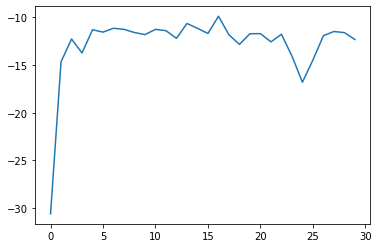

In [86]:
alg = eNAC

agent = experiment(alg, n_epochs=30, n_iterations=4, ep_per_run=200)

In [74]:
base_dir = Path(r'C:\Users\mvijitha22\tailbased')
file_name = base_dir / 'agent_tail.msh'
path = agent.save(file_name)

In [75]:
agent1 = Serializable.load(file_name)

In [66]:
desired_state = np.array([-10,0])  # Replace with desired state values

# Set the current state to the desired state
current_state = desired_state


In [67]:
action_rf = agent1.draw_action(current_state)
action_rf

array([2.41376324])